# 0.Import

## 0.1 라이브러리 설치 및 불러오기

In [97]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")

import tqdm 
from tqdm import tqdm
from tqdm.auto import tqdm
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import scipy.stats as stats

from scipy.stats.mstats import winsorize

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
)
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

import prince

In [98]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

## 0.2 글자 깨짐 방지

In [99]:
# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 한글 글꼴 설정
plt.rcParams["font.family"] = 'NanumGothic'

In [100]:
# size, family
print('# 설정 되어있는 폰트 사이즈')
print (plt.rcParams['font.size'] ) 
print('# 설정 되어있는 폰트 글꼴')
print (plt.rcParams['font.family'] )

# 설정 되어있는 폰트 사이즈
10.0
# 설정 되어있는 폰트 글꼴
['NanumGothic']


Text(0.5, 0, '시간(분)')

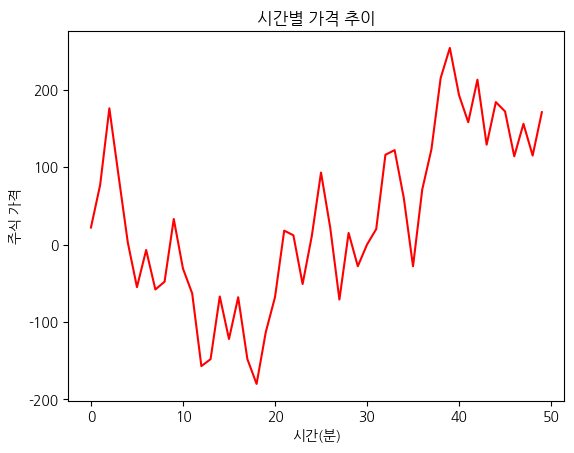

In [101]:
# 글자 깨짐 테스트
data = np.random.randint(-100, 100, 50).cumsum()
plt.plot(range(50), data, 'r')
mpl.rcParams['axes.unicode_minus'] = False
plt.title('시간별 가격 추이')
plt.ylabel('주식 가격')
plt.xlabel('시간(분)')

In [102]:
pd.set_option('display.max_columns',None)
# pd.reset_option('display.max_columns')

# 1. 데이터 로드 + preprocessing

In [103]:
cluster_total = pd.read_csv('cluster_total.csv')
cluster_total

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cc01m(이용금액_백화점),cc02m(이용금액_마트),cc03m(이용금액_편의점),cc04m(이용금액_이커머스),cc05m(이용금액_면세점),cc06m(이용금액_의류),cc07m(이용금액_화장품),cc08m(이용금액_가전),cc09m(이용금액_생활용품),cc10o(이용금액_신차),cc11o(이용금액_중고차),cc12o(이용금액_수입차),cc13o(이용금액_오토바이),cd01m(이용금액_식당),cd02m(이용금액_대형고가커피),cd03m(이용금액_소형저가커피),cd04m(이용금액_배달앱),ce01m(이용금액_고속버스),ce02m(이용금액_택시),ce03m(이용금액_항공),ce04m(이용금액_철도),ce05m(이용금액_여객선),ce06m(이용금액_통신요금),ce07m(이용금액_서점),ce08m(이용금액_네컷사진),ce09m(이용금액_안경),ce10m(이용금액_세탁소),ce11m(이용금액_미용실),ce12m(이용금액_렌터카),ce13m(이용금액_주유소),ce14m(이용금액_LPG가스),ce15m(이용금액_전기차충전),cf01m(이용금액_학원학습지),cf02m(이용금액_병원),cf03m(이용금액_치과),cf04m(이용금액_약국),cf05m(이용금액_예식),cf06m(이용금액_장례),cf07m(이용금액_보험),cf08m(이용금액_기부금),cg01m(이용금액_특급호텔),cg02m(이용금액_숙박),cg03m(이용금액_여행사),cg04m(이용금액_제주여행),cg05m(이용금액_동해여행),cg06m(이용금액_남해여행),cg07m(이용금액_스포츠센터),cg08m(이용금액_수영장),cg09m(이용금액_당구장),cg10m(이용금액_실외골프장),cg11m(이용금액_실내골프장),cg12m(이용금액_테니스장),cg13m(이용금액_볼링장),cg14m(이용금액_놀이동산),cg15m(이용금액_자전거),cg16m(이용금액_레져용품),cg17m(이용금액_예술품),cg18m(이용금액_화원),cg19m(이용금액_전시/관람/체험),cg20m(이용금액_오락실/PC방),cg21m(이용금액_OTT서비스),cg22m(이용금액_해외여행직구),cluster,pk
0,2.515000,3.016667,4.975000,5.360000,0.805000,1.640000,1.250000,1.000000,1.506667,4.190000,2.301667,4.288333,9.513333,1.513333,1.408333,0.500000,1.000000,0.991667,1.073333,2.603333,1.268333,5.545000,0.166667,1.950000,2.276667,15.770000,0.666667,1.203333,1.666667,1.101667,2.810000,3.433333,0.066667,42743.540662,23519.174579,6747.177065,31189.759542,83575.187970,65078.808006,91820.000000,77500.000000,26375.440195,1.000000,1.0,1.00,1.000000,28473.273223,17078.491721,4880.000000,24546.958713,12000.000000,9379.959233,327111.428571,41879.194895,5000.000000,61270.854336,22935.359717,5666.666667,125000.000000,1.000000,54201.372701,59000.0,49596.064594,46600.000000,0.000000,169070.165167,45338.303905,143251.378446,13930.310066,3.000000e+03,40300.000000,64043.374991,0.0,1.000000,126913.533835,40000.000000,64915.614705,27212.157982,231000.000000,107508.333333,0.000000,0.000000,252666.666667,0.000000,0.000000,113000.000000,31500.000000,0.000000,108600.000000,55750.000000,43129.239766,12077.022461,3000.000000,13461.852806,91216.089071,4,F-30e-11110515
1,2.621667,2.970000,5.293333,4.568333,1.390000,1.246667,1.125000,1.000000,1.346667,4.363333,2.768333,4.265000,9.675000,1.305000,1.468333,1.000000,1.033333,1.210000,1.073333,2.236667,1.585000,5.833333,0.500000,1.276667,3.456667,10.328333,0.666667,1.290000,1.750000,1.091667,2.620000,4.683333,0.081667,52309.431599,18723.688479,6639.289714,35489.337206,99061.377246,66462.287546,49622.222222,55000.000000,17900.964001,1.000000,1.0,1.00,1.000000,29615.823554,16317.089912,4204.366484,25059.418327,8066.666667,9598.405069,303780.952381,44230.824028,36000.000000,56247.035992,26932.435612,5200.000000,100694.444444,22445.590472,58603.296726,67000.0,58253.901169,2000.000000,1.000000,194649.964446,55989.049685,132276.274519,12946.223031,1.752250e+06,52913.951546,80692.160793,0.0,105269.806734,192739.028849,28000.000000,23075.000000,75309.098543,68693.939394,126044.598961,16000.000000,0.000000,102000.000000,38666.666667,0.000000,49000.000000,9321.428571,0.000000,105000.000000,9750.000000,45500.000000,13377.341670,1423.076923,11918.306006,89801.312528,4,F-30e-11110530
2,2.680000,3.275000,8.873333,2.956667,0.000000,1.666667,0.500000,0.000000,1.138333,4.498333,4.665000,4.273333,9.465000,1.415000,1.166667,0.333333,0.500000,0.333333,0.833333,2.570000,1.166667,5.393333,0.000000,1.170000,2.333333,6.750000,0.000000,0.750000,0.500000,1.000000,3.108333,2.583333,0.118333,42934.780187,30107.438611,6918.378979,40135.679661,0.000000,52000.000000,31250.000000,0.000000,17454.469507,1.000000,1.0,1.00,1.000000,28228.573759,10946.532999,3738.095238,28841.344587,15000.000000,11590.967542,234333.333333,25687.267267,0.000000,45264.901765,20466.666667,5000.000000,38333.333333,21000.000000,35600.000000,0.0,30705.216964,0.000000,0.000000,105083.333333,63606.875450,10440

In [104]:
# 기존 컬럼 정의
cluster_prev = list(cluster_total.columns[:33])
cluster_prev.append('cluster')
cluster_prev.append('pk')
cluster_prev

['백화점',
 '마트',
 '편의점',
 '이커머스',
 '면세점',
 '의류',
 '화장품',
 '가전',
 '생활용품',
 '요식',
 '커피',
 '배달앱',
 '대중교통',
 '통신요금',
 '서점',
 '사진',
 '안경',
 '세탁소',
 '미용실',
 '연료',
 '교육',
 '의료',
 '예식',
 '보험',
 '숙박',
 '여행',
 '예술품',
 '전시/관람/체험',
 '오락실/PC방',
 'OTT서비스',
 '해외',
 '레져/레져용품/',
 'lb04r(보험계약고객비율_어린이)',
 'cluster',
 'pk']

In [105]:
card_selected_col_count = [col for col in cluster_total.columns if '이용금액' in col and col[1] != 'a']
card_selected_col_count

['cc01m(이용금액_백화점)',
 'cc02m(이용금액_마트)',
 'cc03m(이용금액_편의점)',
 'cc04m(이용금액_이커머스)',
 'cc05m(이용금액_면세점)',
 'cc06m(이용금액_의류)',
 'cc07m(이용금액_화장품)',
 'cc08m(이용금액_가전)',
 'cc09m(이용금액_생활용품)',
 'cc10o(이용금액_신차)',
 'cc11o(이용금액_중고차)',
 'cc12o(이용금액_수입차)',
 'cc13o(이용금액_오토바이)',
 'cd01m(이용금액_식당)',
 'cd02m(이용금액_대형고가커피)',
 'cd03m(이용금액_소형저가커피)',
 'cd04m(이용금액_배달앱)',
 'ce01m(이용금액_고속버스)',
 'ce02m(이용금액_택시)',
 'ce03m(이용금액_항공)',
 'ce04m(이용금액_철도)',
 'ce05m(이용금액_여객선)',
 'ce06m(이용금액_통신요금)',
 'ce07m(이용금액_서점)',
 'ce08m(이용금액_네컷사진)',
 'ce09m(이용금액_안경)',
 'ce10m(이용금액_세탁소)',
 'ce11m(이용금액_미용실)',
 'ce12m(이용금액_렌터카)',
 'ce13m(이용금액_주유소)',
 'ce14m(이용금액_LPG가스)',
 'ce15m(이용금액_전기차충전)',
 'cf01m(이용금액_학원학습지)',
 'cf02m(이용금액_병원)',
 'cf03m(이용금액_치과)',
 'cf04m(이용금액_약국)',
 'cf05m(이용금액_예식)',
 'cf06m(이용금액_장례)',
 'cf07m(이용금액_보험)',
 'cf08m(이용금액_기부금)',
 'cg01m(이용금액_특급호텔)',
 'cg02m(이용금액_숙박)',
 'cg03m(이용금액_여행사)',
 'cg04m(이용금액_제주여행)',
 'cg05m(이용금액_동해여행)',
 'cg06m(이용금액_남해여행)',
 'cg07m(이용금액_스포츠센터)',
 'cg08m(이용금액_수영장)',
 'cg09m(이용금액_당구장)',
 'cg10m(이용금액_

In [106]:
# 빈 딕셔너리 생성
middle_category = {}

# 주어진 데이터를 딕셔너리에 매핑
data = [
    ['백화점', '이용금액_백화점', 'cc01m'],
    ['마트', '이용금액_마트', 'cc02m'],
    ['편의점', '이용금액_편의점', 'cc03m'],
    ['이커머스', '이용금액_이커머스', 'cc04m'],
    ['면세점', '이용금액_면세점', 'cc05m'],
    ['의류', '이용금액_의류', 'cc06m'],
    ['화장품', '이용금액_화장품', 'cc07m'],
    ['가전', '이용금액_가전', 'cc08m'],
    ['생활용품', '이용금액_생활용품', 'cc09m'],
    ['자동차', '이용금액_신차', 'cc10o'],
    ['자동차', '이용금액_중고차', 'cc11o'],
    ['자동차', '이용금액_수입차', 'cc12o'],
    ['자동차', '이용금액_오토바이', 'cc13o'],
    ['요식', '이용금액_식당', 'cd01m'],
    ['커피', '이용금액_대형고가커피', 'cd02m'],
    ['커피', '이용금액_소형저가커피', 'cd03m'],
    ['배달앱', '이용금액_배달앱', 'cd04m'],
    ['대중교통', '이용금액_고속버스', 'ce01m'],
    ['대중교통', '이용금액_택시', 'ce02m'],
    ['대중교통', '이용금액_항공', 'ce03m'],
    ['대중교통', '이용금액_철도', 'ce04m'],
    ['대중교통', '이용금액_여객선', 'ce05m'],
    ['통신요금', '이용금액_통신요금', 'ce06m'],
    ['서점', '이용금액_서점', 'ce07m'],
    ['사진', '이용금액_네컷사진', 'ce08m'],
    ['안경', '이용금액_안경', 'ce09m'],
    ['세탁소', '이용금액_세탁소', 'ce10m'],
    ['미용실', '이용금액_미용실', 'ce11m'],
    ['자동차', '이용금액_렌터카', 'ce12m'],
    ['연료', '이용금액_주유소', 'ce13m'],
    ['연료', '이용금액_LPG가스', 'ce14m'],
    ['연료', '이용금액_전기차충전', 'ce15m'],
    ['교육', '이용금액_학원학습지', 'cf01m'],
    ['의료', '이용금액_병원', 'cf02m'],
    ['의료', '이용금액_치과', 'cf03m'],
    ['의료', '이용금액_약국', 'cf04m'],
    ['예식', '이용금액_예식', 'cf05m'],
    ['장례', '이용금액_장례', 'cf06m'],
    ['보험', '이용금액_보험', 'cf07m'],
    ['숙박', '이용금액_특급호텔', 'cg01m'],
    ['숙박', '이용금액_숙박', 'cg02m'],
    ['여행', '이용금액_여행사', 'cg03m'],
    ['여행', '이용금액_제주여행', 'cg04m'],
    ['여행', '이용금액_동해여행', 'cg05m'],
    ['여행', '이용금액_남해여행', 'cg06m'],
    ['레져', '이용금액_스포츠센터', 'cg07m'],
    ['레져', '이용금액_수영장', 'cg08m'],
    ['레져', '이용금액_당구장', 'cg09m'],
    ['레져', '이용금액_실외골프장', 'cg10m'],
    ['레져', '이용금액_실내골프장', 'cg11m'],
    ['레져', '이용금액_테니스장', 'cg12m'],
    ['레져', '이용금액_볼링장', 'cg13m'],
    ['레져', '이용금액_놀이동산', 'cg14m'],
    ['레져용품', '이용금액_자전거', 'cg15m'],
    ['레져용품', '이용금액_레져용품', 'cg16m'],
    ['예술품', '이용금액_예술품', 'cg17m'],
    ['화원', '이용금액_화원', 'cg18m'],
    ['전시/관람/체험', '이용금액_전시/관람/체험', 'cg19m'],
    ['오락실/PC방', '이용금액_오락실/PC방', 'cg20m'],
    ['OTT서비스', '이용금액_OTT서비스', 'cg21m'],
    ['해외', '이용금액_해외여행직구', 'cg22m']
]





for item in data:
    key = item[0]
    value = f"{item[2]}({item[1]})"
    
    if key in middle_category:
        middle_category[key].append(value)
    else:
        middle_category[key] = [value]




# 중분류끼리 병합할 때 필요한 코드
def merge_values(data: dict, col_names: list) -> dict:
    
    combined_list = []
    new_key_name = ""
    for name in col_names:
        combined_list += data[name]
        new_key_name += f"{name}/"

        # 기존 키 삭제
        del data[name]

    new_key_name.rstrip('/')
    data[new_key_name] = combined_list

    return data


# for item in data:
#     key = item[0]
#     value = f"{item[2]}({item[1]})"
    
#     if key in middle_category:
#         middle_category[key].append(value)
#     else:
#         middle_category[key] = [value]

#레져, 레져용품 병합
# final_middle_category = merge_values(middle_category, ['레져', '레져용품'])
# final_middle_category

middle_category

{'백화점': ['cc01m(이용금액_백화점)'],
 '마트': ['cc02m(이용금액_마트)'],
 '편의점': ['cc03m(이용금액_편의점)'],
 '이커머스': ['cc04m(이용금액_이커머스)'],
 '면세점': ['cc05m(이용금액_면세점)'],
 '의류': ['cc06m(이용금액_의류)'],
 '화장품': ['cc07m(이용금액_화장품)'],
 '가전': ['cc08m(이용금액_가전)'],
 '생활용품': ['cc09m(이용금액_생활용품)'],
 '자동차': ['cc10o(이용금액_신차)',
  'cc11o(이용금액_중고차)',
  'cc12o(이용금액_수입차)',
  'cc13o(이용금액_오토바이)',
  'ce12m(이용금액_렌터카)'],
 '요식': ['cd01m(이용금액_식당)'],
 '커피': ['cd02m(이용금액_대형고가커피)', 'cd03m(이용금액_소형저가커피)'],
 '배달앱': ['cd04m(이용금액_배달앱)'],
 '대중교통': ['ce01m(이용금액_고속버스)',
  'ce02m(이용금액_택시)',
  'ce03m(이용금액_항공)',
  'ce04m(이용금액_철도)',
  'ce05m(이용금액_여객선)'],
 '통신요금': ['ce06m(이용금액_통신요금)'],
 '서점': ['ce07m(이용금액_서점)'],
 '사진': ['ce08m(이용금액_네컷사진)'],
 '안경': ['ce09m(이용금액_안경)'],
 '세탁소': ['ce10m(이용금액_세탁소)'],
 '미용실': ['ce11m(이용금액_미용실)'],
 '연료': ['ce13m(이용금액_주유소)', 'ce14m(이용금액_LPG가스)', 'ce15m(이용금액_전기차충전)'],
 '교육': ['cf01m(이용금액_학원학습지)'],
 '의료': ['cf02m(이용금액_병원)', 'cf03m(이용금액_치과)', 'cf04m(이용금액_약국)'],
 '예식': ['cf05m(이용금액_예식)'],
 '장례': ['cf06m(이용금액_장례)'],
 '보험': ['cf07m(이용금

In [107]:
# 평균금액 중괄호 비용 하기
card_amt_df = pd.DataFrame()
for key, value in middle_category.items():
    key_name = f'{key}(amt/건)'
    card_amt_df[key_name] = cluster_total[value].mean(axis=1)
card_amt_df

,백화점(amt/건),마트(amt/건),편의점(amt/건),이커머스(amt/건),면세점(amt/건),의류(amt/건),화장품(amt/건),가전(amt/건),생활용품(amt/건),자동차(amt/건),요식(amt/건),커피(amt/건),배달앱(amt/건),대중교통(amt/건),통신요금(amt/건),서점(amt/건),사진(amt/건),안경(amt/건),세탁소(amt/건),미용실(amt/건),연료(amt/건),교육(amt/건),의료(amt/건),예식(amt/건),장례(amt/건),보험(amt/건),숙박(amt/건),여행(amt/건),레져(amt/건),레져용품(amt/건),예술품(amt/건),화원(amt/건),전시/관람/체험(amt/건),오락실/PC방(amt/건),OTT서비스(amt/건),해외(amt/건)
0,42743.540662,23519.174579,6747.177065,31189.759542,83575.187970,65078.808006,91820.000000,77500.000000,26375.440195,11800.800000,28473.273223,10979.245861,24546.958713,79074.116540,61270.854336,22935.359717,5666.666667,125000.000000,1.000000,54201.372701,32065.354865,169070.165167,67506.664139,3.000000e+03,40300.000000,64043.374991,63457.266917,90781.943172,63084.375000,54300.000000,55750.000000,43129.239766,12077.022461,3000.000000,13461.852806,91216.089071
1,52309.431599,18723.688479,6639.289714,35489.337206,99061.377246,66462.287546,49622.222222,55000.000000,17900.964001,13400.800000,29615.823554,10260.728198,25059.418327,80335.369629,56247.035992,26932.435612,5200.000000,100694.444444,22445.590472,58603.296726,20084.967056,194649.964446,67070.515745,1.752250e+06,52913.951546,80692.160793,149004.417792,48769.509484,42629.086775,52500.000000,9750.000000,45500.000000,13377.341670,1423.076923,11918.306006,89801.312528
2,42934.780187,30107.438611,6918.378979,40135.679661,0.000000,52000.000000,31250.000000,0.000000,17454.469507,0.800000,28228.573759,7342.314119,28841.344587,57322.313629,45264.901765,20466.666667,5000.000000,38333.333333,21000.000000,35600.000000,10235.072321,105083.333333,59807.110356,0.000000e+00,30000.000000,146162.887840,123400.000000,48326.659452,66218.750000,18500.000000,0.000000,0.000000,6555.555556,10000.000000,14333.333333,105450.264550
3,56679.403938,23778.286164,7368.249006,37473.406104,105833.333333,122468.102555,90416.666667,26333.333333,14039.248168,6000.800000,30933.069580,8305.369728,29396.297213,49299.961734,56850.493030,29190.722627,4000.000000,101500.000000,23000.000000,59166.666667,34015.101726,199462.497340,32885.358214,1.100000e+04,56260.811710,95079.365079,36598.595238,21190.751259,84400.000000,73000.000000,24000.000000,19250.000000,10867.585631,5833.333333,10975.904526,93401.694495
4,51857.132947,24827.189441,7543.045646,35206.757040,28013.533835,74365.574696,73578.884965,30500.000000,18167.532532,6000.800000,34019.420757,10578.589464,28504.199817,10726.743454,68817.532256,22696.965637,5875.000000,123333.333333,21747.619048,56672.688749,34552.919208,185459.716807,41998.231461,0.000000e+00,51920.634921,62468.741663,101327.748152,22145.150347,77993.710894,35028.277778,12022.556391,29916.666667,13422.998508,4833.333333,12867.924528,90366.283043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,52555.496221,28148.400314,8774.563658,38806.784881,113090.476190,79940.633362,1.000000,69836.074087,22387.159268,94000.893333,35220.413190,10451.586388,27198.789508,55671.646452,67874.346719,31845.165130,5433.333333,80800.000000,19514.540589,30110.950456,36344.141753,212341.892808,68323.503917,2.833333e+04,48881.027632,105408.114340,59418.391235,25114.461582,58187.377112,39560.495175,26000.000000,25000.000000,16207.398720,5451.323631,12229.234608,76792.129085
7540,52657.677484,26955.332966,7890.980235,34082.607823,94350.575764,59060.271836,55000.000000,78164.457583,21550.226244,11350.850000,33385.309000,11292.902920,26771.956434,67258.217372,55210.123135,24440.218646,5598.398169,102047.169811,20331.495546,30375.703877,34256.083778,208878.358484,47527.952870,2.322500e+05,48071.444081,105987.689260,76069.154027,35297.046766,85194.959100,65269.419916,16500.000000,30202.134377,13692.725263,4270.070483,13825.178389,66883.384121
7541,63799.397160,28330.792436,9558.231307,37080.306808,110685.571576,68700.694841,66913.904730,61078.970747,21144.252267,67801.235681,33644.901669,11206.445018,27760.721730,73111.312452,61330.

In [108]:
cluster_final_real = pd.concat([cluster_total[cluster_prev], card_amt_df], axis=1)
cluster_final_real.to_csv('cluster_final.csv', index=False)

In [109]:
cluster_0 = cluster_final_real[cluster_final_real['cluster'] == 0]
cluster_1 = cluster_final_real[cluster_final_real['cluster'] == 1]
cluster_2 = cluster_final_real[cluster_final_real['cluster'] == 2]
cluster_3 = cluster_final_real[cluster_final_real['cluster'] == 3]
cluster_4 = cluster_final_real[cluster_final_real['cluster'] == 4]
cluster_5 = cluster_final_real[cluster_final_real['cluster'] == 5]


In [110]:
c0 = cluster_0.drop(columns='pk').mean().sort_values(ascending=False)
c1 = cluster_1.drop(columns='pk').mean().sort_values(ascending=False)
c2 = cluster_2.drop(columns='pk').mean().sort_values(ascending=False)
c3 = cluster_3.drop(columns='pk').mean().sort_values(ascending=False)
c4 = cluster_4.drop(columns='pk').mean().sort_values(ascending=False)
c5 = cluster_5.drop(columns='pk').mean().sort_values(ascending=False)

cluster_list = [c0, c1, c2, c3, c4, c5]
cluster_list[0]

교육(amt/건)              192549.622559
예식(amt/건)              179581.017219
보험(amt/건)               89121.178975
면세점(amt/건)              83077.475557
가전(amt/건)               82502.920113
                           ...      
면세점                         0.576404
예식                          0.209925
lb04r(보험계약고객비율_어린이)         0.098534
예술품                         0.088264
cluster                     0.000000
Length: 70, dtype: float64

In [111]:
cluster_final_real

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster,pk,백화점(amt/건),마트(amt/건),편의점(amt/건),이커머스(amt/건),면세점(amt/건),의류(amt/건),화장품(amt/건),가전(amt/건),생활용품(amt/건),자동차(amt/건),요식(amt/건),커피(amt/건),배달앱(amt/건),대중교통(amt/건),통신요금(amt/건),서점(amt/건),사진(amt/건),안경(amt/건),세탁소(amt/건),미용실(amt/건),연료(amt/건),교육(amt/건),의료(amt/건),예식(amt/건),장례(amt/건),보험(amt/건),숙박(amt/건),여행(amt/건),레져(amt/건),레져용품(amt/건),예술품(amt/건),화원(amt/건),전시/관람/체험(amt/건),오락실/PC방(amt/건),OTT서비스(amt/건),해외(amt/건)
0,2.515000,3.016667,4.975000,5.360000,0.805000,1.640000,1.250000,1.000000,1.506667,4.190000,2.301667,4.288333,9.513333,1.513333,1.408333,0.500000,1.000000,0.991667,1.073333,2.603333,1.268333,5.545000,0.166667,1.950000,2.276667,15.770000,0.666667,1.203333,1.666667,1.101667,2.810000,3.433333,0.066667,4,F-30e-11110515,42743.540662,23519.174579,6747.177065,31189.759542,83575.187970,65078.808006,91820.000000,77500.000000,26375.440195,11800.800000,28473.273223,10979.245861,24546.958713,79074.116540,61270.854336,22935.359717,5666.666667,125000.000000,1.000000,54201.372701,32065.354865,169070.165167,67506.664139,3.000000e+03,40300.000000,64043.374991,63457.266917,90781.943172,63084.375000,54300.000000,55750.000000,43129.239766,12077.022461,3000.000000,13461.852806,91216.089071
1,2.621667,2.970000,5.293333,4.568333,1.390000,1.246667,1.125000,1.000000,1.346667,4.363333,2.768333,4.265000,9.675000,1.305000,1.468333,1.000000,1.033333,1.210000,1.073333,2.236667,1.585000,5.833333,0.500000,1.276667,3.456667,10.328333,0.666667,1.290000,1.750000,1.091667,2.620000,4.683333,0.081667,4,F-30e-11110530,52309.431599,18723.688479,6639.289714,35489.337206,99061.377246,66462.287546,49622.222222,55000.000000,17900.964001,13400.800000,29615.823554,10260.728198,25059.418327,80335.369629,56247.035992,26932.435612,5200.000000,100694.444444,22445.590472,58603.296726,20084.967056,194649.964446,67070.515745,1.752250e+06,52913.951546,80692.160793,149004.417792,48769.509484,42629.086775,52500.000000,9750.000000,45500.000000,13377.341670,1423.076923,11918.306006,89801.312528
2,2.680000,3.275000,8.873333,2.956667,0.000000,1.666667,0.500000,0.000000,1.138333,4.498333,4.665000,4.273333,9.465000,1.415000,1.166667,0.333333,0.500000,0.333333,0.833333,2.570000,1.166667,5.393333,0.000000,1.170000,2.333333,6.750000,0.000000,0.750000,0.500000,1.000000,3.108333,2.583333,0.118333,2,F-30e-11110540,42934.780187,30107.438611,6918.378979,40135.679661,0.000000,52000.000000,31250.000000,0.000000,17454.469507,0.800000,28228.573759,7342.314119,28841.344587,57322.313629,45264.901765,20466.666667,5000.000000,38333.333333,21000.000000,35600.000000,10235.072321,105083.333333,59807.110356,0.000000e+00,30000.000000,146162.887840,123400.000000,48326.659452,66218.750000,18500.000000,0.000000,0.000000,6555.555556,10000.000000,14333.333333,105450.264550
3,3.093333,2.730000,4.768333,5.096667,0.750000,1.160000,0.750000,1.000000,1.413333,3.705000,2.368333,3.741667,9.268333,1.383333,1.503333,0.500000,0.666667,0.666667,1.000000,3.338333,2.141667,5.566667,0.166667,1.233333,2.800000,7.711667,0.500000,1.288333,0.666667,1.076667,2.695000,3.416667,0.076667,1,F-30e-11110550,56679.403938,23778.286164,7368.249006,37473.406104,105833.333333,122468.102555,90416.666667,26333.333333,14039.248168,6000.800000,30933.069580,8305.369728,29396.297213,49299.961734,56850.493030,29190.722627,4000.000000,101500.000000,23000.000000,59166.666667,34015.101726,199462.497340,32885.358214,1.100000e+04,56260.811710,95079.365079,36598.595238,21190.751259,84400.000000,73000.000000,24000.000000,19250.000000,10867.585631,5833.333333,10975.904526,93401.694495
4,2.565000,3.761667,3.580000,5.308333,1.055000,1.301667,1.173333,1.000000,1.496667,3.673333,2.943333,3.726667,8.588333,1.285000,1.380000,1.000000,1.000000,1.191667,1.145000,4.281667,1.798333,5.726667,0.000000,1.855000,2.873333,7.475000,0.388333,1.463333,0.666667,1.010000,2.386667,5.646667,0.081667,4,F-30e-11110560,51857.132947,2

In [112]:
cluster_info_df = pd.DataFrame()

for idx, c in enumerate(cluster_list):
    cluster_info_df[idx] = c

cluster_info_df.T.columns[:36]

Index(['교육(amt/건)', '예식(amt/건)', '보험(amt/건)', '면세점(amt/건)', '가전(amt/건)',
       '안경(amt/건)', '해외(amt/건)', '숙박(amt/건)', '의류(amt/건)', '통신요금(amt/건)',
       '레져용품(amt/건)', '백화점(amt/건)', '의료(amt/건)', '대중교통(amt/건)', '화장품(amt/건)',
       '레져(amt/건)', '장례(amt/건)', '미용실(amt/건)', '이커머스(amt/건)', '여행(amt/건)',
       '요식(amt/건)', '연료(amt/건)', '화원(amt/건)', '배달앱(amt/건)', '마트(amt/건)',
       '서점(amt/건)', '생활용품(amt/건)', '세탁소(amt/건)', '전시/관람/체험(amt/건)',
       'OTT서비스(amt/건)', '커피(amt/건)', '자동차(amt/건)', '편의점(amt/건)', '예술품(amt/건)',
       '오락실/PC방(amt/건)', '사진(amt/건)'],
      dtype='object')

In [129]:
cluster_info_df = cluster_info_df.rename(columns={0:1, 1:2, 2:3, 3:4, 4:5, 5:6})
cluster_info_df

,1,2,3,4,5,6
교육(amt/건),192549.622559,190172.521158,151138.234126,190109.464099,215673.731983,210589.039693
예식(amt/건),179581.017219,92088.283997,161752.083333,125034.994973,197344.867446,245915.686158
보험(amt/건),89121.178975,92024.622138,96966.910382,91348.724963,78382.178668,100156.164673
면세점(amt/건),83077.475557,69686.244418,51889.476515,66531.858045,94356.719437,93254.123335
가전(amt/건),82502.920113,67183.722804,80800.168750,109159.700106,63859.445129,77504.251116
...,...,...,...,...,...,...
면세점,0.576404,0.440045,0.282083,0.479521,0.987409,1.056862
예식,0.209925,0.119413,0.079896,0.131224,0.344430,0.445156
lb04r(보험계약고객비율_어린이),0.098534,0.126903,0.096975,0.097705,0.205194,0.052692
예술품,0.088264,0.056751,0.030312,0.081433,0.292223,0.225478


In [130]:
cluster_amt_col = cluster_info_df.T.columns[:36]
cluster_cnt_col = cluster_info_df.T.columns[36:]

cluster_amt_df = cluster_info_df.loc[cluster_amt_col]
cluster_cnt_df = cluster_info_df.loc[cluster_cnt_col]

In [131]:
data = {'A': [10, 20, 15, 25],
        'B': [5, 10, 10, 35]}
df = pd.DataFrame(data)

# 각 행에 대한 순위 계산
df_ranked = df.rank(axis=1)

print(df_ranked)

     A    B
0  2.0  1.0
1  2.0  1.0
2  2.0  1.0
3  1.0  2.0


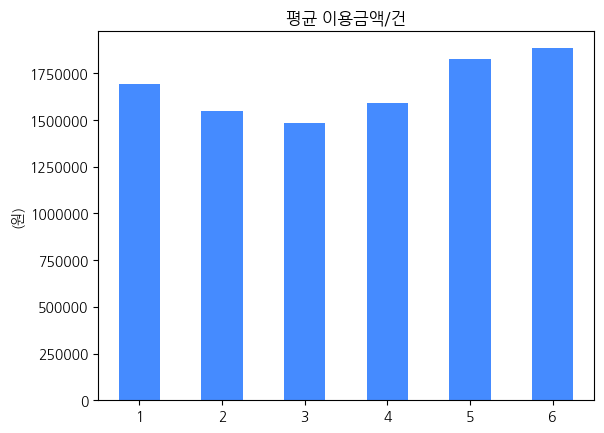

In [151]:
cluster_amt_df.sum().plot(kind='bar', color='#458bff')
plt.title('평균 이용금액/건')
plt.ylabel('(원)')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=0)
plt.show()

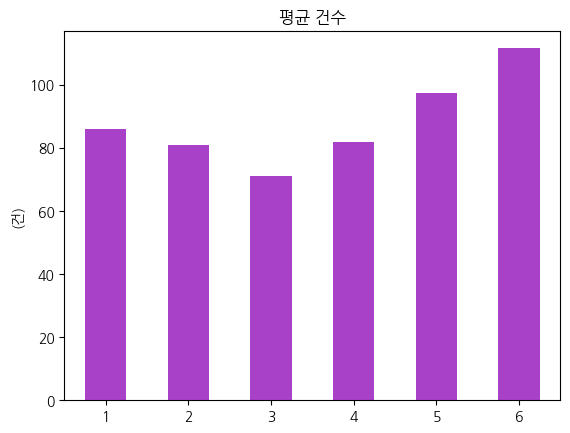

In [152]:
cluster_cnt_df.sum().plot(kind='bar', color='#a941c8')
plt.title('평균 건수')
plt.ylabel('(건)')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=0)
plt.show()

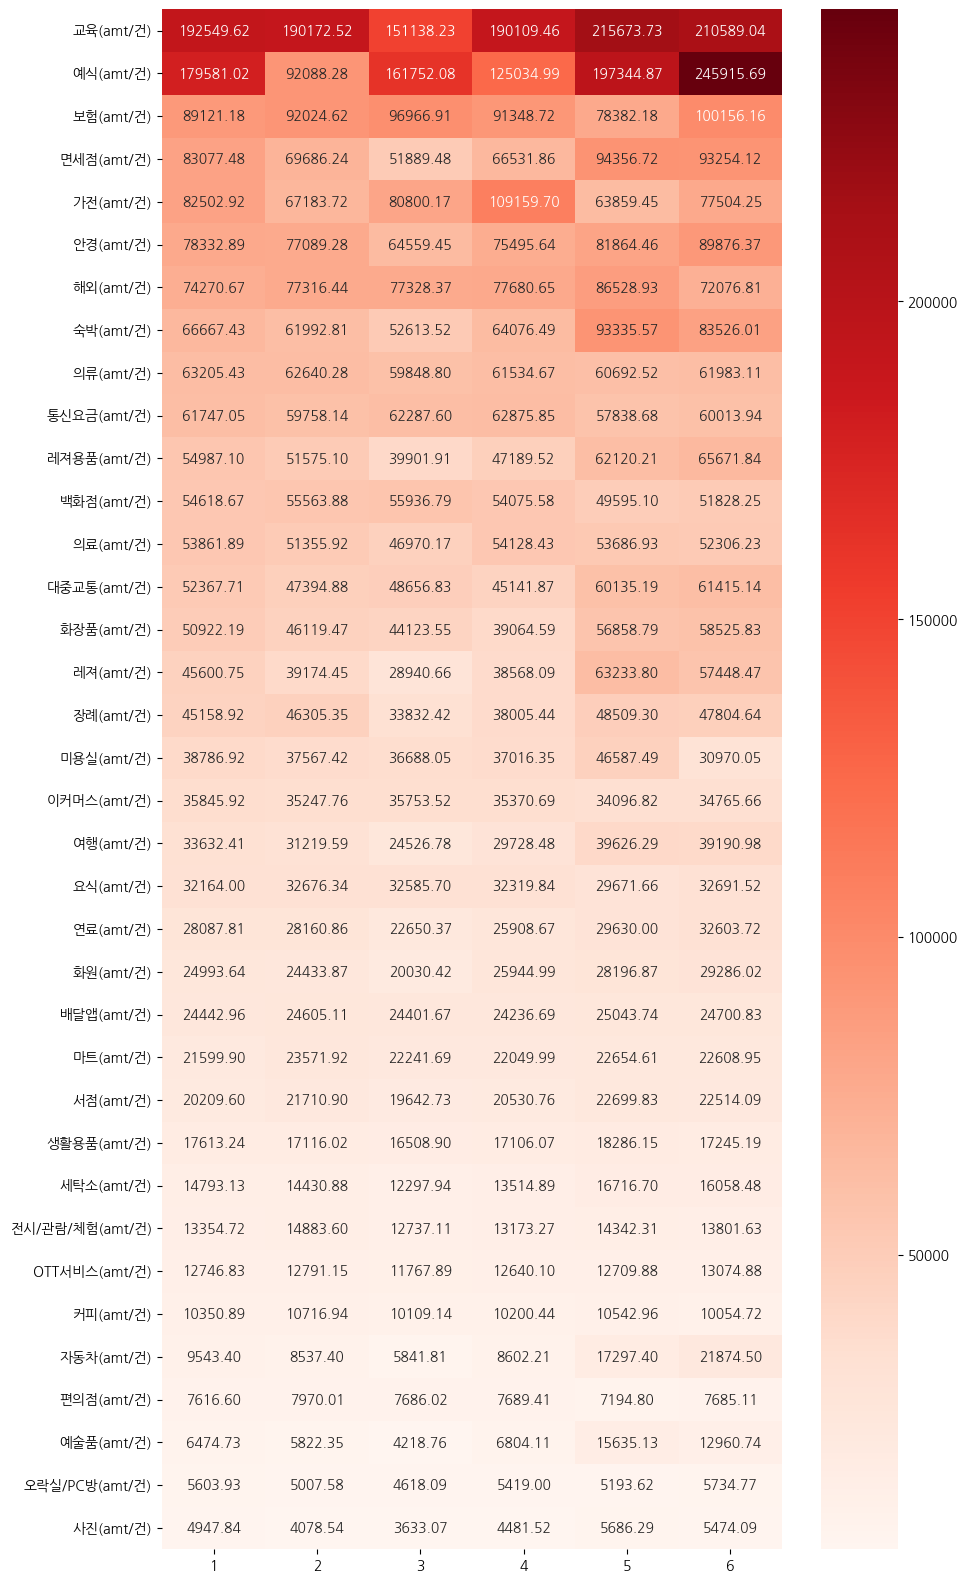

In [133]:
# 건당 비결
plt.figure(figsize=(10, 20))

sns.heatmap(cluster_amt_df, cmap='Reds', annot=True, fmt=".2f")
plt.savefig('heatmap_건당구매비용.png')

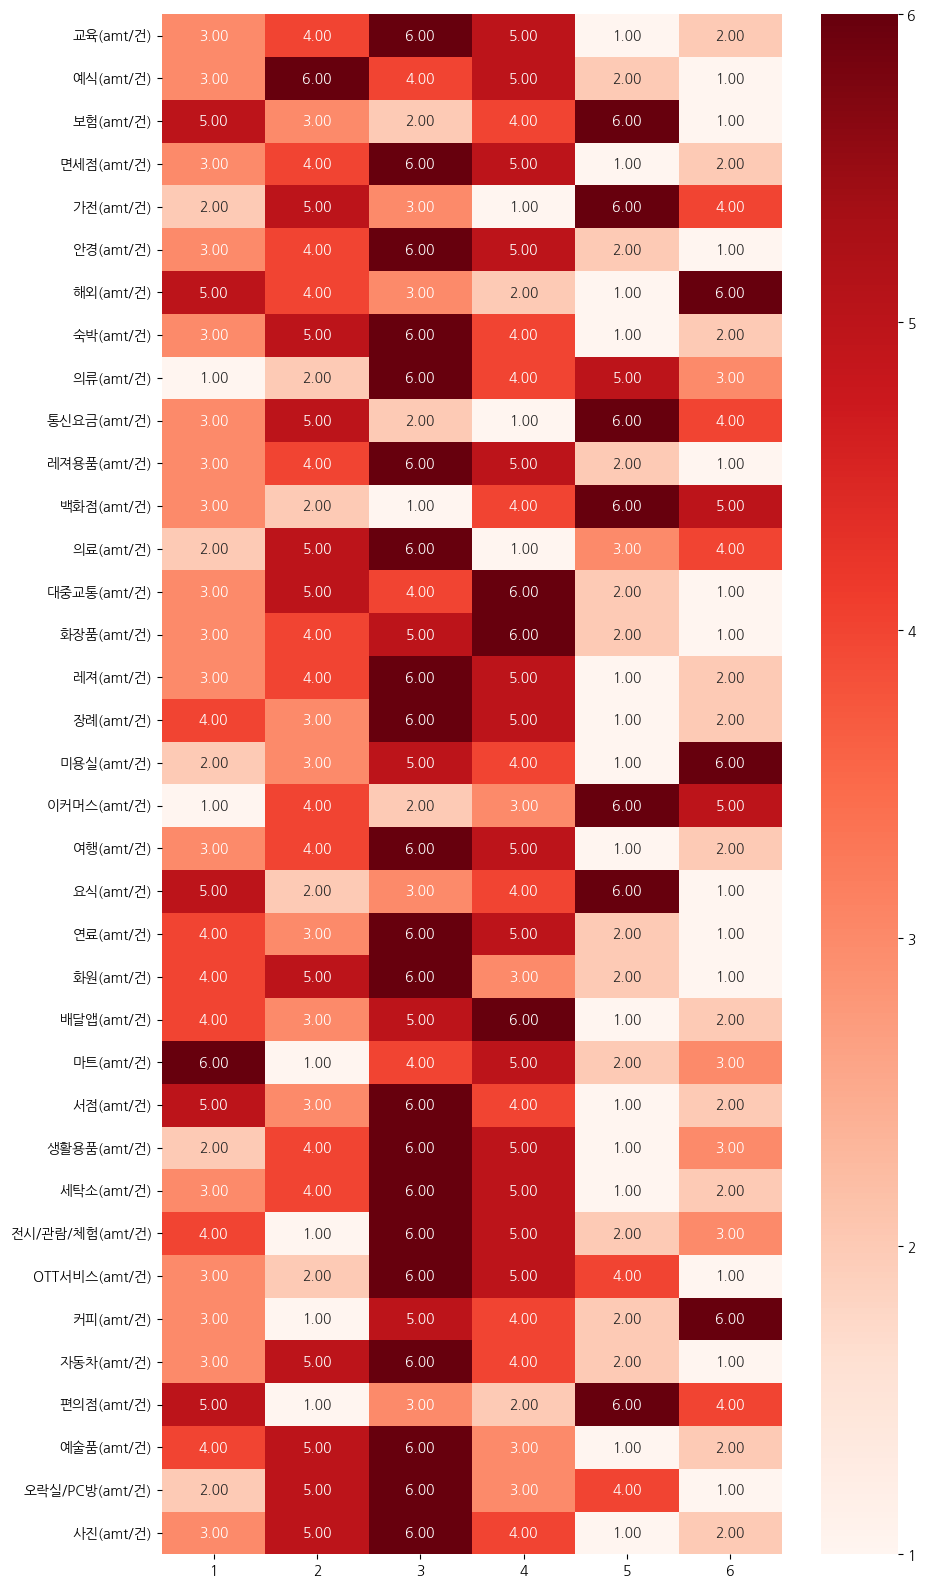

In [134]:
# 건당 비결
plt.figure(figsize=(10, 20))

sns.heatmap(cluster_amt_df.rank(axis=1, ascending=False), cmap='Reds', annot=True, fmt=".2f")
plt.savefig('heatmap_건당구매비용_RANK.png')

In [135]:
df.rank(axis=1)

,A,B
0,2.0,1.0
1,2.0,1.0
2,2.0,1.0
3,1.0,2.0


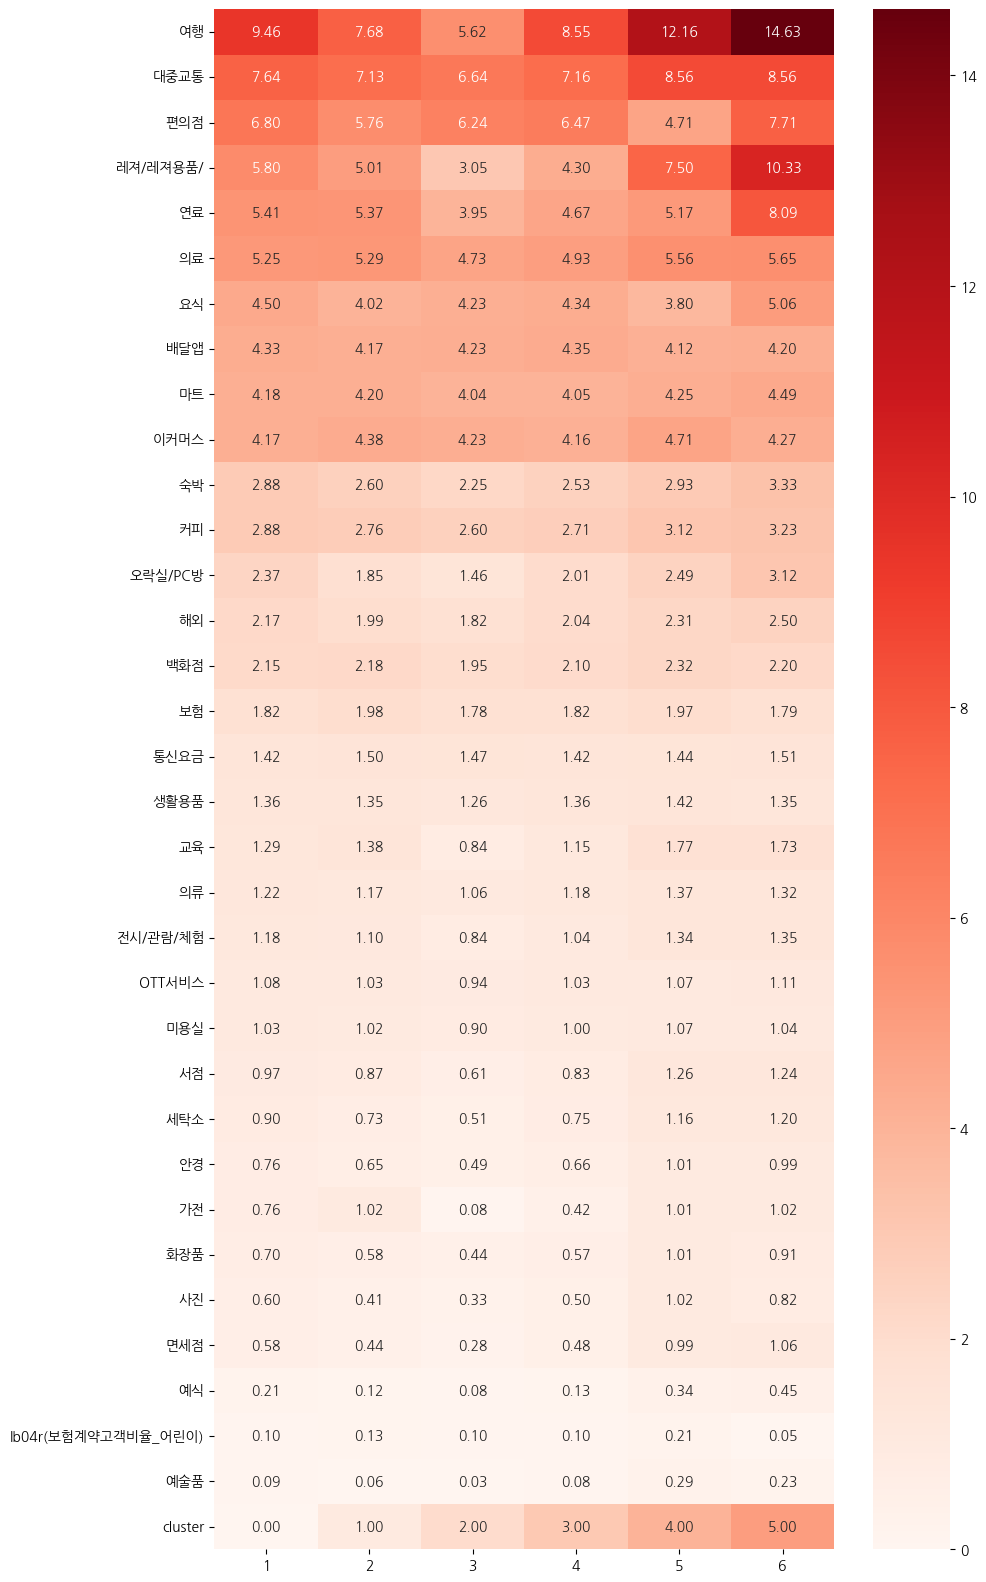

In [136]:
plt.figure(figsize=(10, 20))

sns.heatmap(cluster_cnt_df, cmap='Reds', annot=True, fmt=".2f")
plt.savefig('heatmap_개수.png')

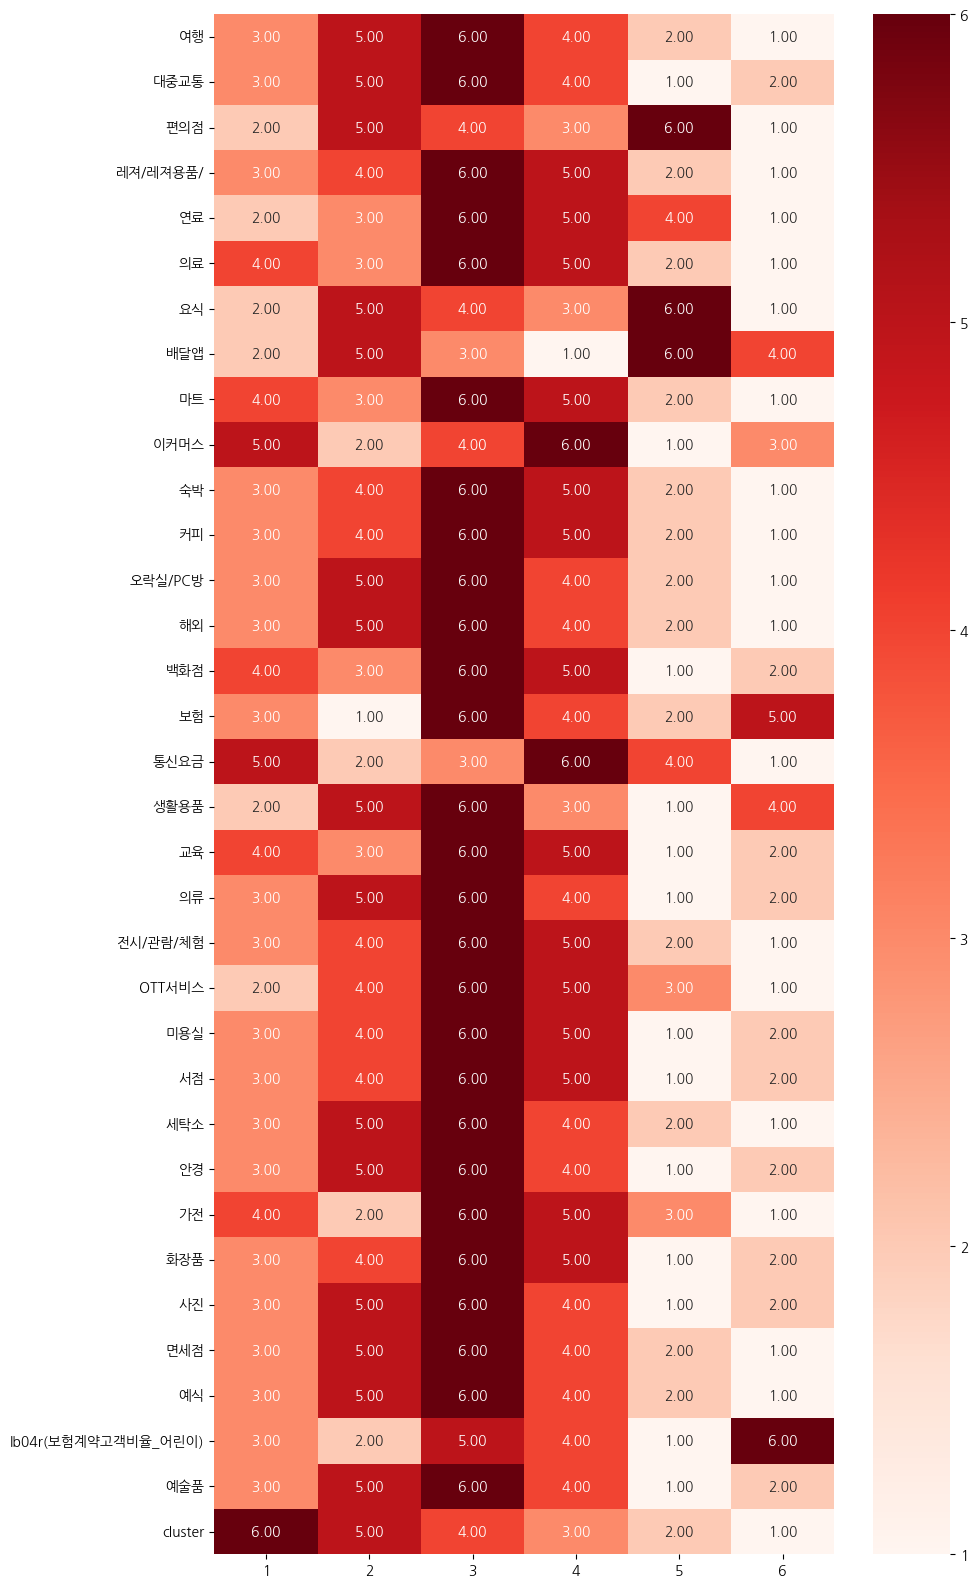

In [137]:
plt.figure(figsize=(10, 20))

sns.heatmap(cluster_cnt_df.rank(axis=1, ascending=False), cmap='Reds', annot=True, fmt=".2f")
plt.savefig('heatmap_개수_RANK.png')

In [120]:
# primary key
primary_col = [col for col in data_total.columns if col.startswith('p')]

# 은행사 데이터 
bank_col = [col for col in data_total.columns if col.startswith('b')]

# 카드사 데이터
card_col = [col for col in data_total.columns if col.startswith('c')]

# 증권사 데이터
secu_col = [col for col in data_total.columns if col.startswith('s')]

# 생명보험사 데이터 
life_col = [col for col in data_total.columns if col.startswith('l')] 

NameError: name 'data_total' is not defined

## 1-1 카드 + 보험
- 보험의 어린이보험 관련 데이터 사용하기 위함
- 1. 결측치 처리
- 2. 이상치 처리, 나이대 범위 좁히기(30초~40후)
- 3. 중분류화
     

In [ ]:
#카드 + 보험
card_life_data = data_total[primary_col+card_col+life_col]
card_life_data

In [ ]:
card_life_data[~card_life_data['ca03r(이용금액100만원이상_비율)'].isna() & card_life_data['le13r(고객비율_최근계약_10년_15년미만)'].isna()]

### 1.1.1 결측치 제거

In [ ]:
card_life_data.isnull().sum()[-50:]

In [ ]:
# 결측값 확인
card_life_data.isnull().sum().sum()

In [ ]:
pd.set_option('display.max_columns',None)
# pd.reset_option('display.max_columns')

In [ ]:
# 결측값은 row가 아예 결측이 되어 있거나 
row_null = card_life_data[card_life_data.isna().any(axis=1)]
row_null

In [ ]:
# 아니면 카드 데이터 자체가 없다고 생각하면 됨
null_columns = row_null.columns[row_null.isnull().all()]
print(null_columns,'\n\n')

# 직접 비교해본결과, 결측된 컬럼은 모두 카드 데이터라는 것을 확인할 수 있음
difference = set(card_col) - set(null_columns)
print(difference)

In [17]:
# 결측치제거
card_life_data = card_life_data.dropna()
card_life_data = card_life_data.reset_index(drop=True)

In [18]:
# 결측값이 없음
card_life_data.isnull().sum().sum()

0

In [19]:
# 11만개에서 9만개로 다이어트
## 여기 데이터는 카드사 데이터 + life_col data뽑아내ㄱ
card_life_data

,pk1(기준년월),pk2(성별),pk3(연령대),pk4(지역),ca01m(이용금액_전체),ca02m(이용건수_전체),ca03r(이용금액100만원이상_비율),cb01o(카드론이용비율_등급),cb02o(현금서비스이용비율_등급),cc01m(이용금액_백화점),cc02m(이용금액_마트),cc03m(이용금액_편의점),cc04m(이용금액_이커머스),cc05m(이용금액_면세점),cc06m(이용금액_의류),cc07m(이용금액_화장품),cc08m(이용금액_가전),cc09m(이용금액_생활용품),cc10o(이용금액_신차),cc11o(이용금액_중고차),cc12o(이용금액_수입차),cc13o(이용금액_오토바이),cc14m(이용건수_백화점),cc15m(이용건수_마트),cc16m(이용건수_편의점),cc17m(이용건수_이커머스),cc18m(이용건수_면세점),cc19m(이용건수_의류),cc20m(이용건수_화장품),cc21m(이용건수_가전),cc22m(이용건수_생활용품),cc23m(이용건수_신차),cc24m(이용건수_중고차),cc25m(이용건수_수입차),cc26m(이용건수_오토바이),cc27r(이용비율_백화점),cc28r(이용비율_마트),cc29r(이용비율_편의점),cc30r(이용비율_이커머스),cc31r(이용비율_면세점),cc32r(이용비율_의류),cc33r(이용비율_화장품),cc34r(이용비율_가전),cc35r(이용비율_생활용품),cc36r(이용비율_신차),cc37r(이용비율_중고차),cc38r(이용비율_수입차),cc39r(이용비율_오토바이),cd01m(이용금액_식당),cd02m(이용금액_대형고가커피),cd03m(이용금액_소형저가커피),cd04m(이용금액_배달앱),cd05m(이용건수_식당),cd06m(이용건수_대형고가커피),cd07m(이용건수_소형저가커피),cd08m(이용건수_배달앱),cd09r(이용비율_식당),cd10r(이용비율_대형고가커피),cd11r(이용비율_소형저가커피),cd12r(이용비율_배달앱),ce01m(이용금액_고속버스),ce02m(이용금액_택시),ce03m(이용금액_항공),ce04m(이용금액_철도),ce05m(이용금액_여객선),ce06m(이용금액_통신요금),ce07m(이용금액_서점),ce08m(이용금액_네컷사진),ce09m(이용금액_안경),ce10m(이용금액_세탁소),ce11m(이용금액_미용실),ce12m(이용금액_렌터카),ce13m(이용금액_주유소),ce14m(이용금액_LPG가스),ce15m(이용금액_전기차충전),ce16m(이용건수_고속버스),ce17m(이용건수_택시),ce18m(이용건수_항공),ce19m(이용건수_철도),ce20m(이용건수_여객선),ce21m(이용건수_통신요금),ce22m(이용건수_서점),ce23m(이용건수_네컷사진),ce24m(이용건수_안경),ce25m(이용건수_세탁소),ce26m(이용건수_미용실),ce27m(이용건수_렌터카),ce28m(이용건수_주유소),ce29m(이용건수_LPG가스),ce30m(이용건수_전기차충전),ce31r(이용비율_고속버스),ce32r(이용비율_택시),ce33r(이용비율_항공),ce34r(이용비율_철도),ce35r(이용비율_여객선),ce36r(이용비율_통신요금),ce37r(이용비율_서점),ce38r(이용비율_네컷사진),ce39r(이용비율_안경),ce40r(이용비율_세탁소),ce41r(이용비율_미용실),ce42r(이용비율_렌터카),ce43r(이용비율_주유소),ce44r(이용비율_LPG가스),ce45r(이용비율_전기차충전),cf01m(이용금액_학원학습지),cf02m(이용금액_병원),cf03m(이용금액_치과),cf04m(이용금액_약국),cf05m(이용금액_예식),cf06m(이용금액_장례),cf07m(이용금액_보험),cf08m(이용금액_기부금),cf09m(이용건수_학원학습지),cf10m(이용건수_병원),cf11m(이용건수_치과),cf12m(이용건수_약국),cf13m(이용건수_예식),cf14m(이용건수_장례),cf15m(이용건수_보험),cf16m(이용건수_기부금),cf17r(이용비율_학원학습지),cf18r(이용비율_병원),cf19r(이용비율_치과),cf20r(이용비율_약국),cf21r(이용비율_예식),cf22r(이용비율_장례),cf23r(이용비율_보험),cf24r(이용비율_기부금),cg01m(이용금액_특급호텔),cg02m(이용금액_숙박),cg03m(이용금액_여행사),cg04m(이용금액_제주여행),cg05m(이용금액_동해여행),cg06m(이용금액_남해여행),cg07m(이용금액_스포츠센터),cg08m(이용금액_수영장),cg09m(이용금액_당구장),cg10m(이용금액_실외골프장),cg11m(이용금액_실내골프장),cg12m(이용금액_테니스장),cg13m(이용금액_볼링장),cg14m(이용금액_놀이동산),cg15m(이용금액_자전거),cg16m(이용금액_레져용품),cg17m(이용금액_예술품),cg18m(이용금액_화원),cg19m(이용금액_전시/관람/체험),cg20m(이용금액_오락실/PC방),cg21m(이용금액_OTT서비스),cg22m(이용금액_해외여행직구),cg23m(이용건수_특급호텔),cg24m(이용건수_숙박),cg25m(이용건수_여행사),cg26m(이용건수_제주여행),cg27m(이용건수_동해여행),cg28m(이용건수_남해여행),cg29m(이용건수_스포츠센터),cg30m(이용건수_수영장),cg31m(이용건수_당구장),cg32m(이용건수_실외골프장),cg33m(이용건수_실내골프장),cg34m(이용건수_테니스장),cg35m(이용건수_볼링장),cg36m(이용건수_놀이동산),cg37m(이용건수_자전거),cg38m(이용건수_레져용품),cg39m(이용건수_예술품),cg40m(이용건수_화원),cg41m(이용건수_전시/관람/체험),cg42m(이용건수_오락실/PC방),cg43m(이용건수_OTT서비스),cg44m(이용건수_해외여행직구),cg45r(이용비율_특급호텔),cg46r(이용비율_숙박),cg47r(이용비율_여행사),cg48r(이용비율_제주여행),cg49r(이용비율_동해여행),cg50r(이용비율_남해여행),cg51r(이용비율_스포츠센터),cg52r(이용비율_수영장),cg53r(이용비율_당구장),cg54r(이용비율_실외골프장),cg55r(이용비율_실내골프장),cg56r(이용비율_테니스장),cg57r(이용비율_볼링장),cg58r(이용비율_놀이동산),cg59r(이용비율_자전거),cg60r(이용비율_레져용품),cg61r(이용비율_예술품),cg62r(이용비율_화원),cg63r(이용비율_전시/관람/체험),cg64r(이용비율_오락실/PC방),cg65r(이용비율_OTT서비스),cg66r(이용비율_해외여행직구),ch01r(은행 교차거래고객 비율),ch02r(증권 교차거래고객 비율),ch03r(라이프 교차거래고객 비율),ch04r(카드 단독 거래고객 비율),ch05r(2개사 교차거래고객 비율),ch06r(3개사 교차거래고객 비율),ch07r(4개사 교차거래고객 비율),la01r(최근1년보험계약고객비율_종신),la02r(최근1년보험계약고객비율_건강),la03r(최근1년보험계약고객비율_상해),la04r(최근1년보험계약고객비율_어린이),la05r(최근1년보험계약고객비율_연금저축),la06r(최근1년보험계약고객비율_변액),la07r(최근1년보험계약고객비율_기타),lb01r(보험계약고객비율_종신),lb02r(보험계약고객비율_건강),lb03r(보험계약고객비율_상해),lb04r(보험계약고객비율_어린이),lb05r(보험계약고객비율_연금저축),lb06r(보험계약고객비율_변액),lb07r(보험계약고객비율_기타),lb08m(보험계약월납보험료),lb09m(보험계약월납보험료_종신),lb10m(보험계약월납보험료_건강),lb11m(보험계약월납보험료_상해),lb12m(보험계약월납보험료_어린이),lb13m(보험계약월납보험료_연금저축),lb14m(보험계약월납보험료_변액),lb15m(보험계약월납보험료_기타),lc01r(보험금지급경험고객비율),lc02r(보험금지급경험고객비율_종신),lc03r(보험금지급경험고객비율_건강),lc04r(보험금지급경험고객비율_상해),lc05r(보험금지급경험고객비율_어린이),lc06r(보험금지급경험고객비율_연금저축),lc07r(보험금지급경험고객비율_변액),lc08r(보험금지급경험고객비율_기타),ld01r(보험계약대출경험고객비율),ld02r(보험계약대출경

### 1.1.2 범위 줄이기 + 이상치 제거
- 밀레니엄 세대(1981년생부터 1997년)을 정의하려고 함
- 편의상 30대초 ~ 40대 후로 정의(30e~40s)

- 사용 column 정의(평균 금액건수)
- 이상치 제거(금액, 비율 가지고) 이상한 경우 존재! 이것을 제거하려고 함

In [20]:
# 밀레니엄 세데만 check하는 filter걸어주려고!
age_filter = ['30e', '30s', '40e', '40s']
age_filter

['30e', '30s', '40e', '40s']

In [21]:
# 필터 걸어줘서 30~40대만 할 수 있도록 함
card_life_data = card_life_data[card_life_data['pk3(연령대)'].isin(age_filter)].reset_index(drop=True)

# 잘 뽑아졌나 확인차~
card_life_data['pk3(연령대)'].unique()

array(['30e', '30s', '40e', '40s'], dtype=object)

In [22]:
# 4만개로 줄음!
card_life_data

,pk1(기준년월),pk2(성별),pk3(연령대),pk4(지역),ca01m(이용금액_전체),ca02m(이용건수_전체),ca03r(이용금액100만원이상_비율),cb01o(카드론이용비율_등급),cb02o(현금서비스이용비율_등급),cc01m(이용금액_백화점),cc02m(이용금액_마트),cc03m(이용금액_편의점),cc04m(이용금액_이커머스),cc05m(이용금액_면세점),cc06m(이용금액_의류),cc07m(이용금액_화장품),cc08m(이용금액_가전),cc09m(이용금액_생활용품),cc10o(이용금액_신차),cc11o(이용금액_중고차),cc12o(이용금액_수입차),cc13o(이용금액_오토바이),cc14m(이용건수_백화점),cc15m(이용건수_마트),cc16m(이용건수_편의점),cc17m(이용건수_이커머스),cc18m(이용건수_면세점),cc19m(이용건수_의류),cc20m(이용건수_화장품),cc21m(이용건수_가전),cc22m(이용건수_생활용품),cc23m(이용건수_신차),cc24m(이용건수_중고차),cc25m(이용건수_수입차),cc26m(이용건수_오토바이),cc27r(이용비율_백화점),cc28r(이용비율_마트),cc29r(이용비율_편의점),cc30r(이용비율_이커머스),cc31r(이용비율_면세점),cc32r(이용비율_의류),cc33r(이용비율_화장품),cc34r(이용비율_가전),cc35r(이용비율_생활용품),cc36r(이용비율_신차),cc37r(이용비율_중고차),cc38r(이용비율_수입차),cc39r(이용비율_오토바이),cd01m(이용금액_식당),cd02m(이용금액_대형고가커피),cd03m(이용금액_소형저가커피),cd04m(이용금액_배달앱),cd05m(이용건수_식당),cd06m(이용건수_대형고가커피),cd07m(이용건수_소형저가커피),cd08m(이용건수_배달앱),cd09r(이용비율_식당),cd10r(이용비율_대형고가커피),cd11r(이용비율_소형저가커피),cd12r(이용비율_배달앱),ce01m(이용금액_고속버스),ce02m(이용금액_택시),ce03m(이용금액_항공),ce04m(이용금액_철도),ce05m(이용금액_여객선),ce06m(이용금액_통신요금),ce07m(이용금액_서점),ce08m(이용금액_네컷사진),ce09m(이용금액_안경),ce10m(이용금액_세탁소),ce11m(이용금액_미용실),ce12m(이용금액_렌터카),ce13m(이용금액_주유소),ce14m(이용금액_LPG가스),ce15m(이용금액_전기차충전),ce16m(이용건수_고속버스),ce17m(이용건수_택시),ce18m(이용건수_항공),ce19m(이용건수_철도),ce20m(이용건수_여객선),ce21m(이용건수_통신요금),ce22m(이용건수_서점),ce23m(이용건수_네컷사진),ce24m(이용건수_안경),ce25m(이용건수_세탁소),ce26m(이용건수_미용실),ce27m(이용건수_렌터카),ce28m(이용건수_주유소),ce29m(이용건수_LPG가스),ce30m(이용건수_전기차충전),ce31r(이용비율_고속버스),ce32r(이용비율_택시),ce33r(이용비율_항공),ce34r(이용비율_철도),ce35r(이용비율_여객선),ce36r(이용비율_통신요금),ce37r(이용비율_서점),ce38r(이용비율_네컷사진),ce39r(이용비율_안경),ce40r(이용비율_세탁소),ce41r(이용비율_미용실),ce42r(이용비율_렌터카),ce43r(이용비율_주유소),ce44r(이용비율_LPG가스),ce45r(이용비율_전기차충전),cf01m(이용금액_학원학습지),cf02m(이용금액_병원),cf03m(이용금액_치과),cf04m(이용금액_약국),cf05m(이용금액_예식),cf06m(이용금액_장례),cf07m(이용금액_보험),cf08m(이용금액_기부금),cf09m(이용건수_학원학습지),cf10m(이용건수_병원),cf11m(이용건수_치과),cf12m(이용건수_약국),cf13m(이용건수_예식),cf14m(이용건수_장례),cf15m(이용건수_보험),cf16m(이용건수_기부금),cf17r(이용비율_학원학습지),cf18r(이용비율_병원),cf19r(이용비율_치과),cf20r(이용비율_약국),cf21r(이용비율_예식),cf22r(이용비율_장례),cf23r(이용비율_보험),cf24r(이용비율_기부금),cg01m(이용금액_특급호텔),cg02m(이용금액_숙박),cg03m(이용금액_여행사),cg04m(이용금액_제주여행),cg05m(이용금액_동해여행),cg06m(이용금액_남해여행),cg07m(이용금액_스포츠센터),cg08m(이용금액_수영장),cg09m(이용금액_당구장),cg10m(이용금액_실외골프장),cg11m(이용금액_실내골프장),cg12m(이용금액_테니스장),cg13m(이용금액_볼링장),cg14m(이용금액_놀이동산),cg15m(이용금액_자전거),cg16m(이용금액_레져용품),cg17m(이용금액_예술품),cg18m(이용금액_화원),cg19m(이용금액_전시/관람/체험),cg20m(이용금액_오락실/PC방),cg21m(이용금액_OTT서비스),cg22m(이용금액_해외여행직구),cg23m(이용건수_특급호텔),cg24m(이용건수_숙박),cg25m(이용건수_여행사),cg26m(이용건수_제주여행),cg27m(이용건수_동해여행),cg28m(이용건수_남해여행),cg29m(이용건수_스포츠센터),cg30m(이용건수_수영장),cg31m(이용건수_당구장),cg32m(이용건수_실외골프장),cg33m(이용건수_실내골프장),cg34m(이용건수_테니스장),cg35m(이용건수_볼링장),cg36m(이용건수_놀이동산),cg37m(이용건수_자전거),cg38m(이용건수_레져용품),cg39m(이용건수_예술품),cg40m(이용건수_화원),cg41m(이용건수_전시/관람/체험),cg42m(이용건수_오락실/PC방),cg43m(이용건수_OTT서비스),cg44m(이용건수_해외여행직구),cg45r(이용비율_특급호텔),cg46r(이용비율_숙박),cg47r(이용비율_여행사),cg48r(이용비율_제주여행),cg49r(이용비율_동해여행),cg50r(이용비율_남해여행),cg51r(이용비율_스포츠센터),cg52r(이용비율_수영장),cg53r(이용비율_당구장),cg54r(이용비율_실외골프장),cg55r(이용비율_실내골프장),cg56r(이용비율_테니스장),cg57r(이용비율_볼링장),cg58r(이용비율_놀이동산),cg59r(이용비율_자전거),cg60r(이용비율_레져용품),cg61r(이용비율_예술품),cg62r(이용비율_화원),cg63r(이용비율_전시/관람/체험),cg64r(이용비율_오락실/PC방),cg65r(이용비율_OTT서비스),cg66r(이용비율_해외여행직구),ch01r(은행 교차거래고객 비율),ch02r(증권 교차거래고객 비율),ch03r(라이프 교차거래고객 비율),ch04r(카드 단독 거래고객 비율),ch05r(2개사 교차거래고객 비율),ch06r(3개사 교차거래고객 비율),ch07r(4개사 교차거래고객 비율),la01r(최근1년보험계약고객비율_종신),la02r(최근1년보험계약고객비율_건강),la03r(최근1년보험계약고객비율_상해),la04r(최근1년보험계약고객비율_어린이),la05r(최근1년보험계약고객비율_연금저축),la06r(최근1년보험계약고객비율_변액),la07r(최근1년보험계약고객비율_기타),lb01r(보험계약고객비율_종신),lb02r(보험계약고객비율_건강),lb03r(보험계약고객비율_상해),lb04r(보험계약고객비율_어린이),lb05r(보험계약고객비율_연금저축),lb06r(보험계약고객비율_변액),lb07r(보험계약고객비율_기타),lb08m(보험계약월납보험료),lb09m(보험계약월납보험료_종신),lb10m(보험계약월납보험료_건강),lb11m(보험계약월납보험료_상해),lb12m(보험계약월납보험료_어린이),lb13m(보험계약월납보험료_연금저축),lb14m(보험계약월납보험료_변액),lb15m(보험계약월납보험료_기타),lc01r(보험금지급경험고객비율),lc02r(보험금지급경험고객비율_종신),lc03r(보험금지급경험고객비율_건강),lc04r(보험금지급경험고객비율_상해),lc05r(보험금지급경험고객비율_어린이),lc06r(보험금지급경험고객비율_연금저축),lc07r(보험금지급경험고객비율_변액),lc08r(보험금지급경험고객비율_기타),ld01r(보험계약대출경험고객비율),ld02r(보험계약대출경

In [23]:
# 사용 column 정의(이용건수, 이용금액)

card_selected_col = [col for col in card_col if '이용건수' in col and col[1] != 'a']
card_selected_col_2 = [col for col in card_col if '이용금액' in col and col[1] != 'a']

life_child_col = ['lb04r(보험계약고객비율_어린이)']

# life_child_col = ['lb04r(보험계약고객비율_어린이)',
#                   'lb12m(보험계약월납보험료_어린이)',
#                   'lc05r(보험금지급경험고객비율_어린이)',
#                   'ld05r(보험계약대출경험고객비율_어린이)'] 

In [24]:
# # 군집화에 필요한 데이터만 추출
# cluster_data = card_life_data[card_selected_col + card_selected_col_2 + life_child_col]
# cluster_data

미리 inf가 얼마나 있는지 파악해보자!

In [25]:
# 이상치 보여주기
card_life_data[(card_life_data['cc05m(이용금액_면세점)'] > 0) & (card_life_data['cc18m(이용건수_면세점)'] == 0)][['cc05m(이용금액_면세점)', 'cc18m(이용건수_면세점)']]

,cc05m(이용금액_면세점),cc18m(이용건수_면세점)
106,153000.0,0.0
138,84000.0,0.0
322,72000.0,0.0
372,275000.0,0.0
611,294000.0,0.0
...,...,...
39032,277000.0,0.0
39821,514000.0,0.0
39920,200000.0,0.0
40104,18000.0,0.0


In [26]:
# # 건당 이용금액 파생변수

per_amt_df = card_life_data[primary_col]

for amt_col,num_col in zip(card_selected_col_2, card_selected_col):
    amt = card_life_data[amt_col]
    num = card_life_data[num_col]

    # 건당 이용금액 series
    per_amt = amt/num

    # 새로운 col name(우선 뒤의 개별 합치고 => 중분류 작업을 원활하기 위해 금액 col그대로 사용)
    # col_name = f'건당{amt_col[6:-1]}'
    per_amt_df[amt_col] = per_amt

per_amt_df

,pk1(기준년월),pk2(성별),pk3(연령대),pk4(지역),cc01m(이용금액_백화점),cc02m(이용금액_마트),cc03m(이용금액_편의점),cc04m(이용금액_이커머스),cc05m(이용금액_면세점),cc06m(이용금액_의류),cc07m(이용금액_화장품),cc08m(이용금액_가전),cc09m(이용금액_생활용품),cc10o(이용금액_신차),cc11o(이용금액_중고차),cc12o(이용금액_수입차),cc13o(이용금액_오토바이),cd01m(이용금액_식당),cd02m(이용금액_대형고가커피),cd03m(이용금액_소형저가커피),cd04m(이용금액_배달앱),ce01m(이용금액_고속버스),ce02m(이용금액_택시),ce03m(이용금액_항공),ce04m(이용금액_철도),ce05m(이용금액_여객선),ce06m(이용금액_통신요금),ce07m(이용금액_서점),ce08m(이용금액_네컷사진),ce09m(이용금액_안경),ce10m(이용금액_세탁소),ce11m(이용금액_미용실),ce12m(이용금액_렌터카),ce13m(이용금액_주유소),ce14m(이용금액_LPG가스),ce15m(이용금액_전기차충전),cf01m(이용금액_학원학습지),cf02m(이용금액_병원),cf03m(이용금액_치과),cf04m(이용금액_약국),cf05m(이용금액_예식),cf06m(이용금액_장례),cf07m(이용금액_보험),cf08m(이용금액_기부금),cg01m(이용금액_특급호텔),cg02m(이용금액_숙박),cg03m(이용금액_여행사),cg04m(이용금액_제주여행),cg05m(이용금액_동해여행),cg06m(이용금액_남해여행),cg07m(이용금액_스포츠센터),cg08m(이용금액_수영장),cg09m(이용금액_당구장),cg10m(이용금액_실외골프장),cg11m(이용금액_실내골프장),cg12m(이용금액_테니스장),cg13m(이용금액_볼링장),cg14m(이용금액_놀이동산),cg15m(이용금액_자전거),cg16m(이용금액_레져용품),cg17m(이용금액_예술품),cg18m(이용금액_화원),cg19m(이용금액_전시/관람/체험),cg20m(이용금액_오락실/PC방),cg21m(이용금액_OTT서비스),cg22m(이용금액_해외여행직구)
0,2208,F,30e,11110515.0,51681.957187,30434.782609,6355.932203,31801.470588,NaN,50000.000000,38000.000000,61000.000000,22500.000000,inf,inf,inf,inf,26792.452830,13846.153846,4000.000000,22641.509434,8000.000000,8089.887640,192857.142857,49500.000000,NaN,68000.000000,17054.263566,NaN,53000.000000,14000.000000,66666.666667,NaN,63981.042654,56000.000000,NaN,132330.827068,52123.552124,68000.000000,11152.416357,NaN,60000.000000,66086.956522,NaN,1.045113e+05,27067.669173,NaN,18800.000000,44539.614561,NaN,174000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131000.000000,18000.0,17000.0,15384.615385,NaN,13043.478261,120361.990950
1,2208,F,30e,11110530.0,35269.709544,15714.285714,7170.542636,36974.789916,95808.383234,76056.338028,35000.000000,133000.000000,20689.655172,inf,inf,2.0,inf,27826.086957,18978.102190,3821.656051,25845.410628,5000.000000,8585.858586,112000.000000,39463.601533,NaN,60162.601626,21000.000000,4000.000000,103000.000000,24786.324786,63888.888889,94000.0,57988.165680,NaN,30000.000000,124731.182796,55868.544601,89221.556886,12206.572770,654500.0,40666.666667,65137.614679,NaN,1.029412e+05,91764.705882,28000.0,27500.000000,40042.826552,20636.363636,76571.428571,NaN,NaN,NaN,NaN,NaN,38000.000000,8000.000000,NaN,46000.000000,14000.0,21000.0,15646.258503,NaN,12380.952381,135593.220339
2,2208,F,30e,11110540.0,33333.333333,30337.078652,5945.945946,41176.470588,NaN,28000.000000,15500.000000,NaN,18666.666667,inf,inf,inf,inf,20618.556701,9774.436090,2666.666667,27016.885553,1000.000000,18444.444444,NaN,43000.000000,NaN,43333.333333,14666.666667,5000.000000,60000.000000,NaN,67000.000000,NaN,36666.666667,NaN,NaN,139000.000000,67574.931880,365000.000000,14666.666667,NaN,30000.000000,206766.917293,NaN,0.000000e+00,167000.000000,NaN,20909.090909,6500.000000,64285.714286,NaN,NaN,NaN,255000.000000,12000.000000,NaN,NaN,14666.666667,NaN,43333.333333,NaN,NaN,12666.666667,10000.000000,13000.000000,393000.000000
3,2208,F,30e,11110550.0,62666.666667,20661.157025,7296.137339,35714.285714,NaN,135658.914729,105000.000000,26000.000000,20300.751880,inf,inf,inf,inf,25428.571429,11403.508772,3000.000000,27254.098361,19500.000000,10852.713178,NaN,38785.046729,NaN,58156.028369,39000.000000,4000.000000,74000.000000,17000.000000,85000.000000,NaN,70414.201183,62000.000000,3000.000000,205333.333333,46696.035242,21600.000000,13375.796178,NaN,60000.000000,82000.000000,NaN,inf,NaN,5000.0,24000.000000,17050.691244,12857.142857,54000.000000,NaN,NaN,NaN,NaN,NaN,NaN,5000.000000,NaN,15000.000000,5000.0,13000.0,14000.000000,2000.000000,11111.111111,69774.919614
4,2208,F,30e,11110560.0,53816.793893,21329.639889,7541.899441,37109.375000,40000.000000,47368.421053,88034.188034,56000.000000,19047.619048,inf,inf,inf,inf,36997.319035,15441.176471,5600.000000,26327.944573,2000.000000,10141.509434,788000.000000,44871.794872,NaN,72093.023256,30827.067669,6000.000000,100000.000000,16000.000000,61417.322835,NaN,52611.940299,NaN,NaN,177600.000000,

In [27]:
# # 모든 열에 대해 무한대 값을 포함하는 행의 개수 계산
# def count_rows_with_inf(df):
#     # 각 행에 대해 무한대 값을 포함하는지 여부를 검사하고, any(axis=1)로 행 기준으로 합산
#     return len(df[df.isin([np.inf, -np.inf]).any(axis=1)])

# # 결과 출력
# drop_col = ["cc10o(이용금액_신차)", 
#             "cc11o(이용금액_중고차)",
#             "cc12o(이용금액_수입차)",
#             "cc13o(이용금액_오토바이)",
#             "cg18m(이용금액_화원)",
#             "cf06m(이용금액_장례)",
#             "cf08m(이용금액_기부금)"]

# count = count_rows_with_inf(per_amt_df.drop(columns=drop_col))
# print(f"무한대 값을 포함하는 행의 개수: {count}")

In [28]:
# 전체의 20% 안팎 지워도 큰 문제 없을 것이라 생각
40294 - 7860
7860/40294

0.19506626296719115

In [29]:
# 10개월 데이터를 10개월 평균 내주기
per_amt_df_10_month = per_amt_df.drop(columns='pk1(기준년월)').groupby(['pk2(성별)', 'pk3(연령대)', 'pk4(지역)']).mean().reset_index()
per_amt_df_10_month

,pk2(성별),pk3(연령대),pk4(지역),cc01m(이용금액_백화점),cc02m(이용금액_마트),cc03m(이용금액_편의점),cc04m(이용금액_이커머스),cc05m(이용금액_면세점),cc06m(이용금액_의류),cc07m(이용금액_화장품),cc08m(이용금액_가전),cc09m(이용금액_생활용품),cc10o(이용금액_신차),cc11o(이용금액_중고차),cc12o(이용금액_수입차),cc13o(이용금액_오토바이),cd01m(이용금액_식당),cd02m(이용금액_대형고가커피),cd03m(이용금액_소형저가커피),cd04m(이용금액_배달앱),ce01m(이용금액_고속버스),ce02m(이용금액_택시),ce03m(이용금액_항공),ce04m(이용금액_철도),ce05m(이용금액_여객선),ce06m(이용금액_통신요금),ce07m(이용금액_서점),ce08m(이용금액_네컷사진),ce09m(이용금액_안경),ce10m(이용금액_세탁소),ce11m(이용금액_미용실),ce12m(이용금액_렌터카),ce13m(이용금액_주유소),ce14m(이용금액_LPG가스),ce15m(이용금액_전기차충전),cf01m(이용금액_학원학습지),cf02m(이용금액_병원),cf03m(이용금액_치과),cf04m(이용금액_약국),cf05m(이용금액_예식),cf06m(이용금액_장례),cf07m(이용금액_보험),cf08m(이용금액_기부금),cg01m(이용금액_특급호텔),cg02m(이용금액_숙박),cg03m(이용금액_여행사),cg04m(이용금액_제주여행),cg05m(이용금액_동해여행),cg06m(이용금액_남해여행),cg07m(이용금액_스포츠센터),cg08m(이용금액_수영장),cg09m(이용금액_당구장),cg10m(이용금액_실외골프장),cg11m(이용금액_실내골프장),cg12m(이용금액_테니스장),cg13m(이용금액_볼링장),cg14m(이용금액_놀이동산),cg15m(이용금액_자전거),cg16m(이용금액_레져용품),cg17m(이용금액_예술품),cg18m(이용금액_화원),cg19m(이용금액_전시/관람/체험),cg20m(이용금액_오락실/PC방),cg21m(이용금액_OTT서비스),cg22m(이용금액_해외여행직구)
0,F,30e,11110515.0,42743.540662,23519.174579,6747.177065,31189.759542,83575.187970,65078.808006,9.182000e+04,77500.000000,26375.440195,inf,inf,inf,inf,28473.273223,17078.491721,4880.000000,24546.958713,1.200000e+04,9379.959233,3.271114e+05,41879.194895,5000.000000,61270.854336,22935.359717,5666.666667,125000.000000,inf,54201.372701,59000.0,49596.064594,46600.000000,NaN,169070.165167,45338.303905,143251.378446,13930.310066,3.000000e+03,40300.000000,64043.374991,NaN,inf,126913.533835,4.000000e+04,64915.614705,27212.157982,231000.000000,107508.333333,NaN,NaN,252666.666667,NaN,NaN,113000.000000,31500.000000,NaN,108600.000000,55750.000000,43129.239766,12077.022461,3000.000000,13461.852806,91216.089071
1,F,30e,11110530.0,52309.431599,18723.688479,6639.289714,35489.337206,99061.377246,66462.287546,4.962222e+04,55000.000000,17900.964001,inf,inf,inf,inf,29615.823554,16317.089912,4204.366484,25059.418327,8.066667e+03,9598.405069,3.037810e+05,44230.824028,36000.000000,56247.035992,26932.435612,5200.000000,100694.444444,2.244559e+04,58603.296726,67000.0,58253.901169,2000.000000,inf,194649.964446,55989.049685,132276.274519,12946.223031,1.752250e+06,52913.951546,80692.160793,NaN,1.052698e+05,192739.028849,2.800000e+04,23075.000000,75309.098543,68693.939394,126044.598961,16000.000000,NaN,102000.000000,38666.666667,NaN,49000.000000,9321.428571,NaN,105000.000000,9750.000000,45500.000000,13377.341670,1423.076923,11918.306006,89801.312528
2,F,30e,11110540.0,42934.780187,30107.438611,6918.378979,40135.679661,NaN,52000.000000,3.125000e+04,NaN,17454.469507,inf,inf,inf,inf,28228.573759,10946.532999,3738.095238,28841.344587,1.500000e+04,11590.967542,2.343333e+05,25687.267267,NaN,45264.901765,20466.666667,5000.000000,38333.333333,2.100000e+04,35600.000000,NaN,30705.216964,NaN,NaN,105083.333333,63606.875450,104400.000000,11414.455618,NaN,30000.000000,146162.887840,NaN,6.200000e+04,184800.000000,4.200000e+04,64298.701299,22722.222222,64285.714286,255333.333333,NaN,NaN,248000.000000,6000.000000,NaN,NaN,20416.666667,NaN,37000.000000,NaN,NaN,6555.555556,10000.000000,14333.333333,105450.264550
3,F,30e,11110550.0,56679.403938,23778.286164,7368.249006,37473.406104,105833.333333,122468.102555,9.041667e+04,26333.333333,14039.248168,inf,inf,inf,inf,30933.069580,12827.406122,3783.333333,29396.297213,inf,11155.716834,1.768333e+05,23509.758500,35000.000000,56850.493030,29190.722627,4000.000000,101500.000000,2.300000e+04,59166.666667,30000.0,50628.638512,50083.333333,1.333333e+03,199462.497340,49710.705397,36766.666667,12178.702578,1.100000e+04,56260.811710,95079.365079,NaN,inf,73196.190476,5.000000e+03,31752.777778,25391.179639,22619.047619,92200.000000,NaN,NaN,54166.666667,220000.000000,300000.000000,NaN,8833.333333,1.190000e+05,27000.000000,24000.000000,19250.000000,10867.585631,5833.333333,10975.904526,93401.694495
4,F,30e,11110560.0,51857.132947,24827.189441,7543.045646,35206.757040,28013.533835,74365.574696,7.357888e+04,30500.000000,1

In [30]:
per_amt_df_10_month = per_amt_df_10_month.fillna(0)
per_amt_df_10_month.replace([np.inf, -np.inf], 1, inplace=True)


In [31]:
per_amt_df_10_month

,pk2(성별),pk3(연령대),pk4(지역),cc01m(이용금액_백화점),cc02m(이용금액_마트),cc03m(이용금액_편의점),cc04m(이용금액_이커머스),cc05m(이용금액_면세점),cc06m(이용금액_의류),cc07m(이용금액_화장품),cc08m(이용금액_가전),cc09m(이용금액_생활용품),cc10o(이용금액_신차),cc11o(이용금액_중고차),cc12o(이용금액_수입차),cc13o(이용금액_오토바이),cd01m(이용금액_식당),cd02m(이용금액_대형고가커피),cd03m(이용금액_소형저가커피),cd04m(이용금액_배달앱),ce01m(이용금액_고속버스),ce02m(이용금액_택시),ce03m(이용금액_항공),ce04m(이용금액_철도),ce05m(이용금액_여객선),ce06m(이용금액_통신요금),ce07m(이용금액_서점),ce08m(이용금액_네컷사진),ce09m(이용금액_안경),ce10m(이용금액_세탁소),ce11m(이용금액_미용실),ce12m(이용금액_렌터카),ce13m(이용금액_주유소),ce14m(이용금액_LPG가스),ce15m(이용금액_전기차충전),cf01m(이용금액_학원학습지),cf02m(이용금액_병원),cf03m(이용금액_치과),cf04m(이용금액_약국),cf05m(이용금액_예식),cf06m(이용금액_장례),cf07m(이용금액_보험),cf08m(이용금액_기부금),cg01m(이용금액_특급호텔),cg02m(이용금액_숙박),cg03m(이용금액_여행사),cg04m(이용금액_제주여행),cg05m(이용금액_동해여행),cg06m(이용금액_남해여행),cg07m(이용금액_스포츠센터),cg08m(이용금액_수영장),cg09m(이용금액_당구장),cg10m(이용금액_실외골프장),cg11m(이용금액_실내골프장),cg12m(이용금액_테니스장),cg13m(이용금액_볼링장),cg14m(이용금액_놀이동산),cg15m(이용금액_자전거),cg16m(이용금액_레져용품),cg17m(이용금액_예술품),cg18m(이용금액_화원),cg19m(이용금액_전시/관람/체험),cg20m(이용금액_오락실/PC방),cg21m(이용금액_OTT서비스),cg22m(이용금액_해외여행직구)
0,F,30e,11110515.0,42743.540662,23519.174579,6747.177065,31189.759542,83575.187970,65078.808006,91820.000000,77500.000000,26375.440195,1.000000,1.0,1.00,1.000000,28473.273223,17078.491721,4880.000000,24546.958713,12000.000000,9379.959233,327111.428571,41879.194895,5000.000000,61270.854336,22935.359717,5666.666667,125000.000000,1.000000,54201.372701,59000.0,49596.064594,46600.000000,0.000000,169070.165167,45338.303905,143251.378446,13930.310066,3.000000e+03,40300.000000,64043.374991,0.0,1.000000,126913.533835,40000.000000,64915.614705,27212.157982,231000.000000,107508.333333,0.000000,0.000000,252666.666667,0.000000,0.000000,113000.000000,31500.000000,0.000000,108600.000000,55750.000000,43129.239766,12077.022461,3000.000000,13461.852806,91216.089071
1,F,30e,11110530.0,52309.431599,18723.688479,6639.289714,35489.337206,99061.377246,66462.287546,49622.222222,55000.000000,17900.964001,1.000000,1.0,1.00,1.000000,29615.823554,16317.089912,4204.366484,25059.418327,8066.666667,9598.405069,303780.952381,44230.824028,36000.000000,56247.035992,26932.435612,5200.000000,100694.444444,22445.590472,58603.296726,67000.0,58253.901169,2000.000000,1.000000,194649.964446,55989.049685,132276.274519,12946.223031,1.752250e+06,52913.951546,80692.160793,0.0,105269.806734,192739.028849,28000.000000,23075.000000,75309.098543,68693.939394,126044.598961,16000.000000,0.000000,102000.000000,38666.666667,0.000000,49000.000000,9321.428571,0.000000,105000.000000,9750.000000,45500.000000,13377.341670,1423.076923,11918.306006,89801.312528
2,F,30e,11110540.0,42934.780187,30107.438611,6918.378979,40135.679661,0.000000,52000.000000,31250.000000,0.000000,17454.469507,1.000000,1.0,1.00,1.000000,28228.573759,10946.532999,3738.095238,28841.344587,15000.000000,11590.967542,234333.333333,25687.267267,0.000000,45264.901765,20466.666667,5000.000000,38333.333333,21000.000000,35600.000000,0.0,30705.216964,0.000000,0.000000,105083.333333,63606.875450,104400.000000,11414.455618,0.000000e+00,30000.000000,146162.887840,0.0,62000.000000,184800.000000,42000.000000,64298.701299,22722.222222,64285.714286,255333.333333,0.000000,0.000000,248000.000000,6000.000000,0.000000,0.000000,20416.666667,0.000000,37000.000000,0.000000,0.000000,6555.555556,10000.000000,14333.333333,105450.264550
3,F,30e,11110550.0,56679.403938,23778.286164,7368.249006,37473.406104,105833.333333,122468.102555,90416.666667,26333.333333,14039.248168,1.000000,1.0,1.00,1.000000,30933.069580,12827.406122,3783.333333,29396.297213,1.000000,11155.716834,176833.333333,23509.758500,35000.000000,56850.493030,29190.722627,4000.000000,101500.000000,23000.000000,59166.666667,30000.0,50628.638512,50083.333333,1333.333333,199462.497340,49710.705397,36766.666667,12178.702578,1.100000e+04,56260.811710,95079.365079,0.0,1.000000,73196.190476,5000.000000,31752.777778,25391.179639,22619.047619,92200.000000,0.000000,0.000000,54166.666667,220000.000000,300000.000000,0.000000,8833.333333,119000.000000,27000.000000

### 1.1.3 중분류화

In [32]:
## 이용 건수만으로 중분류화해보기
middle_category = {}

#GPT야 싸룽해~
data = [
    ["백화점", "이용건수_백화점", "cc14m"],
    ["마트", "이용건수_마트", "cc15m"],
    ["편의점", "이용건수_편의점", "cc16m"],
    ["이커머스", "이용건수_이커머스", "cc17m"],
    ["면세점", "이용건수_면세점", "cc18m"],
    ["의류", "이용건수_의류", "cc19m"],
    ["화장품", "이용건수_화장품", "cc20m"],
    ["가전", "이용건수_가전", "cc21m"],
    ["생활용품", "이용건수_생활용품", "cc22m"],
    ["자동차", "이용건수_신차", "cc23m"],
    ["자동차", "이용건수_중고차", "cc24m"],
    ["자동차", "이용건수_수입차", "cc25m"],
    ["자동차", "이용건수_오토바이", "cc26m"],
    ["요식", "이용건수_식당", "cd05m"],
    ["커피", "이용건수_대형고가커피", "cd06m"],
    ["커피", "이용건수_소형저가커피", "cd07m"],
    ["배달앱", "이용건수_배달앱", "cd08m"],
    ["대중교통", "이용건수_고속버스", "ce16m"],
    ["대중교통", "이용건수_택시", "ce17m"],
    ["대중교통", "이용건수_항공", "ce18m"],
    ["대중교통", "이용건수_철도", "ce19m"],
    ["대중교통", "이용건수_여객선", "ce20m"],
    ["통신요금", "이용건수_통신요금", "ce21m"],
    ["서점", "이용건수_서점", "ce22m"],
    ["사진", "이용건수_네컷사진", "ce23m"],
    ["안경", "이용건수_안경", "ce24m"],
    ["세탁소", "이용건수_세탁소", "ce25m"],
    ["미용실", "이용건수_미용실", "ce26m"],
    ["자동차", "이용건수_렌터카", "ce27m"],
    ["연료", "이용건수_주유소", "ce28m"],
    ["연료", "이용건수_LPG가스", "ce29m"],
    ["연료", "이용건수_전기차충전", "ce30m"],
    ["교육", "이용건수_학원학습지", "cf09m"],
    ["의료", "이용건수_병원", "cf10m"],
    ["의료", "이용건수_치과", "cf11m"],
    ["의료", "이용건수_약국", "cf12m"],
    ["예식", "이용건수_예식", "cf13m"],
    ["장례", "이용건수_장례", "cf14m"],
    ["보험", "이용건수_보험", "cf15m"],
    ["기부금", "이용건수_기부금", "cf16m"],
    ["숙박", "이용건수_특급호텔", "cg23m"],
    ["숙박", "이용건수_숙박", "cg24m"],
    ["여행", "이용건수_여행사", "cg25m"],
    ["여행", "이용건수_제주여행", "cg26m"],
    ["여행", "이용건수_동해여행", "cg27m"],
    ["여행", "이용건수_남해여행", "cg28m"],
    ["레져", "이용건수_스포츠센터", "cg29m"],
    ["레져", "이용건수_수영장", "cg30m"],
    ["레져", "이용건수_당구장", "cg31m"],
    ["레져", "이용건수_실외골프장", "cg32m"],
    ["레져", "이용건수_실내골프장", "cg33m"],
    ["레져", "이용건수_테니스장", "cg34m"],
    ["레져", "이용건수_볼링장", "cg35m"],
    ["레져", "이용건수_놀이동산", "cg36m"],
    ["레져용품", "이용건수_자전거", "cg37m"],
    ["레져용품", "이용건수_레져용품", "cg38m"],
    ["예술품", "이용건수_예술품", "cg39m"],
    ["화원", "이용건수_화원", "cg40m"],
    ["전시/관람/체험", "이용건수_전시/관람/체험", "cg41m"],
    ["오락실/PC방", "이용건수_오락실/PC방", "cg42m"],
    ["OTT서비스", "이용건수_OTT서비스", "cg43m"],
    ["해외", "이용건수_해외여행직구", "cg44m"],
]

for item in data:
    key = item[0]
    value = f"{item[2]}({item[1]})"
    
    if key in middle_category:
        middle_category[key].append(value)
    else:
        middle_category[key] = [value]

middle_category


{'백화점': ['cc14m(이용건수_백화점)'],
 '마트': ['cc15m(이용건수_마트)'],
 '편의점': ['cc16m(이용건수_편의점)'],
 '이커머스': ['cc17m(이용건수_이커머스)'],
 '면세점': ['cc18m(이용건수_면세점)'],
 '의류': ['cc19m(이용건수_의류)'],
 '화장품': ['cc20m(이용건수_화장품)'],
 '가전': ['cc21m(이용건수_가전)'],
 '생활용품': ['cc22m(이용건수_생활용품)'],
 '자동차': ['cc23m(이용건수_신차)',
  'cc24m(이용건수_중고차)',
  'cc25m(이용건수_수입차)',
  'cc26m(이용건수_오토바이)',
  'ce27m(이용건수_렌터카)'],
 '요식': ['cd05m(이용건수_식당)'],
 '커피': ['cd06m(이용건수_대형고가커피)', 'cd07m(이용건수_소형저가커피)'],
 '배달앱': ['cd08m(이용건수_배달앱)'],
 '대중교통': ['ce16m(이용건수_고속버스)',
  'ce17m(이용건수_택시)',
  'ce18m(이용건수_항공)',
  'ce19m(이용건수_철도)',
  'ce20m(이용건수_여객선)'],
 '통신요금': ['ce21m(이용건수_통신요금)'],
 '서점': ['ce22m(이용건수_서점)'],
 '사진': ['ce23m(이용건수_네컷사진)'],
 '안경': ['ce24m(이용건수_안경)'],
 '세탁소': ['ce25m(이용건수_세탁소)'],
 '미용실': ['ce26m(이용건수_미용실)'],
 '연료': ['ce28m(이용건수_주유소)', 'ce29m(이용건수_LPG가스)', 'ce30m(이용건수_전기차충전)'],
 '교육': ['cf09m(이용건수_학원학습지)'],
 '의료': ['cf10m(이용건수_병원)', 'cf11m(이용건수_치과)', 'cf12m(이용건수_약국)'],
 '예식': ['cf13m(이용건수_예식)'],
 '장례': ['cf14m(이용건수_장례)'],
 '보험': ['cf15m(이용건

In [33]:
# 필요없는 col 제거
remove_cols = ['자동차', '장례', '화원', '기부금']
for col in remove_cols:
    middle_category.pop(col)

In [34]:
# 중분류끼리 병합할 때 필요한 코드
def merge_values(data: dict, col_names: list) -> dict:
    
    combined_list = []
    new_key_name = ""
    for name in col_names:
        combined_list += data[name]
        new_key_name += f"{name}/"

        # 기존 키 삭제
        del data[name]

    new_key_name.rstrip('/')
    data[new_key_name] = combined_list

    return data


In [35]:
#레져, 레져용품 병합
final_middle_category = merge_values(middle_category, ['레져', '레져용품'])
final_middle_category

{'백화점': ['cc14m(이용건수_백화점)'],
 '마트': ['cc15m(이용건수_마트)'],
 '편의점': ['cc16m(이용건수_편의점)'],
 '이커머스': ['cc17m(이용건수_이커머스)'],
 '면세점': ['cc18m(이용건수_면세점)'],
 '의류': ['cc19m(이용건수_의류)'],
 '화장품': ['cc20m(이용건수_화장품)'],
 '가전': ['cc21m(이용건수_가전)'],
 '생활용품': ['cc22m(이용건수_생활용품)'],
 '요식': ['cd05m(이용건수_식당)'],
 '커피': ['cd06m(이용건수_대형고가커피)', 'cd07m(이용건수_소형저가커피)'],
 '배달앱': ['cd08m(이용건수_배달앱)'],
 '대중교통': ['ce16m(이용건수_고속버스)',
  'ce17m(이용건수_택시)',
  'ce18m(이용건수_항공)',
  'ce19m(이용건수_철도)',
  'ce20m(이용건수_여객선)'],
 '통신요금': ['ce21m(이용건수_통신요금)'],
 '서점': ['ce22m(이용건수_서점)'],
 '사진': ['ce23m(이용건수_네컷사진)'],
 '안경': ['ce24m(이용건수_안경)'],
 '세탁소': ['ce25m(이용건수_세탁소)'],
 '미용실': ['ce26m(이용건수_미용실)'],
 '연료': ['ce28m(이용건수_주유소)', 'ce29m(이용건수_LPG가스)', 'ce30m(이용건수_전기차충전)'],
 '교육': ['cf09m(이용건수_학원학습지)'],
 '의료': ['cf10m(이용건수_병원)', 'cf11m(이용건수_치과)', 'cf12m(이용건수_약국)'],
 '예식': ['cf13m(이용건수_예식)'],
 '보험': ['cf15m(이용건수_보험)'],
 '숙박': ['cg23m(이용건수_특급호텔)', 'cg24m(이용건수_숙박)'],
 '여행': ['cg25m(이용건수_여행사)',
  'cg26m(이용건수_제주여행)',
  'cg27m(이용건수_동해여행)',
  'cg28m(이용건수

In [36]:
# 32개
len(final_middle_category.keys())

32

## 1.2 최종 데이터 만짐
- 중분류화 한 카드데이터 + 보험데이터 합침
- scaling해줘야할듯

### 1.2.1 중분류 + 카드데이터 합치기

In [37]:
# 기존 카드 데이터데이터 => 중분류화 시키기
## 기존 카드 데이터 변수명 : card_life_data

card_middle_data = card_life_data[primary_col]
for key, value in final_middle_category.items():
    card_middle_data[key] = card_life_data[value].sum(axis=1)
card_middle_data


,pk1(기준년월),pk2(성별),pk3(연령대),pk4(지역),백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/
0,2208,F,30e,11110515.0,3.27,2.53,7.08,5.44,0.00,1.00,1.00,1.00,2.00,5.30,2.30,4.77,14.45,1.50,1.29,0.00,1.00,1.00,1.17,3.11,1.33,6.78,0.0,2.30,2.66,19.67,1.0,1.43,0.00,1.15,2.21,2.00
1,2208,F,30e,11110530.0,2.41,2.80,5.16,4.76,1.67,1.42,1.00,1.00,1.16,4.60,2.94,4.14,10.55,1.23,2.00,1.00,1.00,1.17,1.08,2.69,1.86,5.93,2.0,1.09,3.40,22.67,1.0,1.47,0.00,1.05,1.77,4.75
2,2208,F,30e,11110540.0,2.25,3.56,7.40,2.38,0.00,2.00,2.00,0.00,1.50,5.82,2.83,5.33,7.50,1.50,1.50,1.00,1.00,0.00,1.00,1.80,1.00,7.92,0.0,1.33,4.00,22.00,0.0,1.50,1.00,1.00,1.00,7.50
3,2208,F,30e,11110550.0,3.00,2.42,4.66,4.20,0.00,1.29,1.00,1.00,1.33,3.50,2.14,4.88,8.01,1.41,1.00,1.00,1.00,1.00,1.00,3.69,3.00,5.09,0.0,1.00,0.00,7.67,1.0,1.50,1.00,1.08,3.11,3.00
4,2208,F,30e,11110560.0,2.62,3.61,3.58,5.12,1.00,1.14,1.17,1.00,1.47,3.73,2.61,4.33,8.80,1.29,1.33,2.00,1.00,1.00,1.27,2.68,1.25,5.26,0.0,1.54,3.00,8.10,0.0,1.36,0.00,1.00,2.55,5.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40289,2306,M,40s,41500253.0,2.38,4.42,8.80,3.65,1.50,1.55,1.00,1.09,1.14,4.74,3.17,3.67,8.60,1.66,1.63,1.50,1.00,1.18,1.02,8.66,1.59,5.00,2.0,2.33,5.30,16.89,0.0,1.57,3.60,1.08,2.84,15.38
40290,2306,M,40s,41570550.0,1.85,5.05,7.97,5.06,1.40,1.20,1.00,1.04,1.19,4.85,3.28,3.17,8.69,1.71,1.21,1.14,1.00,1.16,1.06,8.31,2.09,6.03,1.0,1.91,4.12,15.81,1.0,1.42,5.06,1.08,2.82,13.03
40291,2306,M,40s,41590259.0,2.63,5.19,8.29,4.10,1.55,1.54,1.00,1.00,1.42,4.62,3.38,4.15,7.72,1.71,1.14,1.08,1.19,1.14,1.06,8.54,1.68,6.18,1.0,2.19,3.42,17.19,1.0,1.50,2.94,1.19,2.52,14.10
40292,2306,M,40s,41590600.0,2.36,4.55,7.34,5.40,1.25,1.44,1.00,1.00,1.30,4.80,3.00,3.18,7.45,1.61,1.27,1.20,1.00,1.08,1.03,9.66,2.01,6.37,0.0,2.10,3.50,18.18,1.0,1.52,4.50,1.10,2.43,13.52


In [40]:
# 어린이보혐 데이터
life_child_data = card_life_data[life_child_col]
life_child_data

,lb04r(보험계약고객비율_어린이)
0,0.09
1,0.10
2,0.10
3,0.09
4,0.10
...,...
40289,0.03
40290,0.08
40291,0.09
40292,0.04


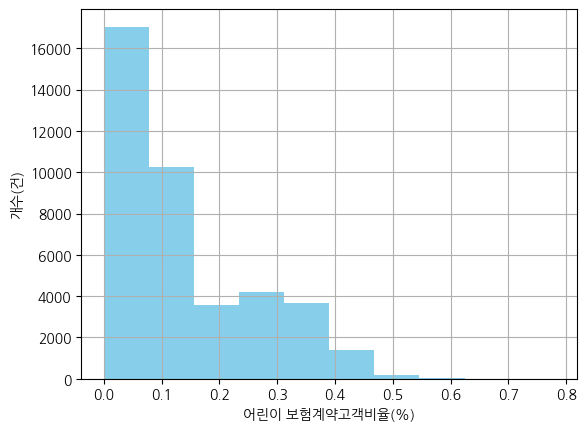

In [41]:
life_child_data["lb04r(보험계약고객비율_어린이)"].hist(color='skyblue')
plt.xlabel('어린이 보험계약고객비율(%)')
plt.ylabel('개수(건)')
plt.show()

In [42]:
# 10개월 평균 변환

In [43]:
# 두 개 병합
cluster_data = pd.concat([card_middle_data, life_child_data], axis=1)
cluster_data

,pk1(기준년월),pk2(성별),pk3(연령대),pk4(지역),백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이)
0,2208,F,30e,11110515.0,3.27,2.53,7.08,5.44,0.00,1.00,1.00,1.00,2.00,5.30,2.30,4.77,14.45,1.50,1.29,0.00,1.00,1.00,1.17,3.11,1.33,6.78,0.0,2.30,2.66,19.67,1.0,1.43,0.00,1.15,2.21,2.00,0.09
1,2208,F,30e,11110530.0,2.41,2.80,5.16,4.76,1.67,1.42,1.00,1.00,1.16,4.60,2.94,4.14,10.55,1.23,2.00,1.00,1.00,1.17,1.08,2.69,1.86,5.93,2.0,1.09,3.40,22.67,1.0,1.47,0.00,1.05,1.77,4.75,0.10
2,2208,F,30e,11110540.0,2.25,3.56,7.40,2.38,0.00,2.00,2.00,0.00,1.50,5.82,2.83,5.33,7.50,1.50,1.50,1.00,1.00,0.00,1.00,1.80,1.00,7.92,0.0,1.33,4.00,22.00,0.0,1.50,1.00,1.00,1.00,7.50,0.10
3,2208,F,30e,11110550.0,3.00,2.42,4.66,4.20,0.00,1.29,1.00,1.00,1.33,3.50,2.14,4.88,8.01,1.41,1.00,1.00,1.00,1.00,1.00,3.69,3.00,5.09,0.0,1.00,0.00,7.67,1.0,1.50,1.00,1.08,3.11,3.00,0.09
4,2208,F,30e,11110560.0,2.62,3.61,3.58,5.12,1.00,1.14,1.17,1.00,1.47,3.73,2.61,4.33,8.80,1.29,1.33,2.00,1.00,1.00,1.27,2.68,1.25,5.26,0.0,1.54,3.00,8.10,0.0,1.36,0.00,1.00,2.55,5.08,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40289,2306,M,40s,41500253.0,2.38,4.42,8.80,3.65,1.50,1.55,1.00,1.09,1.14,4.74,3.17,3.67,8.60,1.66,1.63,1.50,1.00,1.18,1.02,8.66,1.59,5.00,2.0,2.33,5.30,16.89,0.0,1.57,3.60,1.08,2.84,15.38,0.03
40290,2306,M,40s,41570550.0,1.85,5.05,7.97,5.06,1.40,1.20,1.00,1.04,1.19,4.85,3.28,3.17,8.69,1.71,1.21,1.14,1.00,1.16,1.06,8.31,2.09,6.03,1.0,1.91,4.12,15.81,1.0,1.42,5.06,1.08,2.82,13.03,0.08
40291,2306,M,40s,41590259.0,2.63,5.19,8.29,4.10,1.55,1.54,1.00,1.00,1.42,4.62,3.38,4.15,7.72,1.71,1.14,1.08,1.19,1.14,1.06,8.54,1.68,6.18,1.0,2.19,3.42,17.19,1.0,1.50,2.94,1.19,2.52,14.10,0.09
40292,2306,M,40s,41590600.0,2.36,4.55,7.34,5.40,1.25,1.44,1.00,1.00,1.30,4.80,3.00,3.18,7.45,1.61,1.27,1.20,1.00,1.08,1.03,9.66,2.01,6.37,0.0,2.10,3.50,18.18,1.0,1.52,4.50,1.10,2.43,13.52,0.04


In [44]:
cluster_data['pk1(기준년월)'].unique()

array(['2208', '2210', '2212', '2302', '2304', '2306'], dtype=object)

In [45]:
# 10개월 데이터를 10개월 평균 내주기
cluster_data_10_month = cluster_data.drop(columns='pk1(기준년월)').groupby(['pk2(성별)', 'pk3(연령대)', 'pk4(지역)']).mean().reset_index()
cluster_data_10_month

,pk2(성별),pk3(연령대),pk4(지역),백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이)
0,F,30e,11110515.0,2.515000,3.016667,4.975000,5.360000,0.805000,1.640000,1.250000,1.000000,1.506667,4.190000,2.301667,4.288333,9.513333,1.513333,1.408333,0.500000,1.000000,0.991667,1.073333,2.603333,1.268333,5.545000,0.166667,1.950000,2.276667,15.770000,0.666667,1.203333,1.666667,1.101667,2.810000,3.433333,0.066667
1,F,30e,11110530.0,2.621667,2.970000,5.293333,4.568333,1.390000,1.246667,1.125000,1.000000,1.346667,4.363333,2.768333,4.265000,9.675000,1.305000,1.468333,1.000000,1.033333,1.210000,1.073333,2.236667,1.585000,5.833333,0.500000,1.276667,3.456667,10.328333,0.666667,1.290000,1.750000,1.091667,2.620000,4.683333,0.081667
2,F,30e,11110540.0,2.680000,3.275000,8.873333,2.956667,0.000000,1.666667,0.500000,0.000000,1.138333,4.498333,4.665000,4.273333,9.465000,1.415000,1.166667,0.333333,0.500000,0.333333,0.833333,2.570000,1.166667,5.393333,0.000000,1.170000,2.333333,6.750000,0.000000,0.750000,0.500000,1.000000,3.108333,2.583333,0.118333
3,F,30e,11110550.0,3.093333,2.730000,4.768333,5.096667,0.750000,1.160000,0.750000,1.000000,1.413333,3.705000,2.368333,3.741667,9.268333,1.383333,1.503333,0.500000,0.666667,0.666667,1.000000,3.338333,2.141667,5.566667,0.166667,1.233333,2.800000,7.711667,0.500000,1.288333,0.666667,1.076667,2.695000,3.416667,0.076667
4,F,30e,11110560.0,2.565000,3.761667,3.580000,5.308333,1.055000,1.301667,1.173333,1.000000,1.496667,3.673333,2.943333,3.726667,8.588333,1.285000,1.380000,1.000000,1.000000,1.191667,1.145000,4.281667,1.798333,5.726667,0.000000,1.855000,2.873333,7.475000,0.388333,1.463333,0.666667,1.010000,2.386667,5.646667,0.081667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,M,40s,41500253.0,2.416000,4.104000,8.050000,3.304000,1.550000,1.300000,0.800000,1.030000,1.296000,4.696000,3.102000,3.450000,6.954000,1.656000,1.318000,1.300000,1.000000,1.200000,1.038000,9.698000,1.952000,5.702000,1.700000,2.194000,4.052000,16.118000,0.200000,1.394000,2.584000,1.096000,2.450000,12.970000,0.036000
7540,M,40s,41570550.0,1.937500,4.825000,7.080000,4.942500,1.272500,1.250000,1.000000,1.030000,1.195000,4.557500,3.337500,3.297500,9.000000,1.667500,1.275000,1.255000,1.015000,1.117500,1.060000,8.075000,1.980000,6.057500,1.000000,1.880000,3.700000,14.335000,0.500000,1.340000,3.580000,1.085000,2.590000,13.617500,0.092500
7541,M,40s,41590259.0,2.425000,5.116667,7.476667,3.713333,1.491667,1.368333,1.033333,1.008333,1.308333,4.608333,3.015000,4.046667,8.253333,1.701667,1.263333,1.123333,1.066667,1.131667,1.061667,9.323333,1.816667,6.056667,0.555000,2.008333,3.070000,15.755000,0.666667,1.398333,3.513333,1.150000,2.498333,13.305000,0.050000
7542,M,40s,41590600.0,2.421667,4.485000,6.695000,5.140000,1.406667,1.451667,1.041667,1.010000,1.373333,4.596667,3.148333,3.293333,7.766667,1.651667,1.321667,1.223333,1.000000,1.168333,1.058333,9.288333,1.990000,5.928333,1.250000,1.950000,3.283333,16.243333,0.500000,1.401667,3.173333,1.115000,2.635000,13.938333,0.045000


### 1.2.2 Scaling
- 보험데이터 : 보험계약비율, 보험료와 같은 수치
- 카드데이터 : 건수
- 따라서 스케일링 필요!
- 이상치가 많은 데이터 특성 상, `RobustScaler()`를 활용

- 참고 : https://dacon.io/codeshare/4526

In [46]:
# scaling하기 전, pk데이터와 범주형 데이터 나누기

# # 지역 컬럼 str타입으로 만들기
cluster_data_10_month['pk4(지역)'] = cluster_data_10_month['pk4(지역)'].astype(int).astype(str)

object_columns = cluster_data_10_month.select_dtypes(include=['object']).columns.tolist()
float_int_columns = cluster_data_10_month.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 범주형 데이터만 모아둔 데이터셋
object_data = cluster_data_10_month[object_columns]
object_data['pk5'] = object_data['pk2(성별)'] + '-' +object_data['pk3(연령대)'] +'-'+object_data['pk4(지역)']

# 수치형 데이터만 모아둔 데이터셋
float_data = cluster_data_10_month[float_int_columns]

In [47]:
cluster_data_10_month

,pk2(성별),pk3(연령대),pk4(지역),백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이)
0,F,30e,11110515,2.515000,3.016667,4.975000,5.360000,0.805000,1.640000,1.250000,1.000000,1.506667,4.190000,2.301667,4.288333,9.513333,1.513333,1.408333,0.500000,1.000000,0.991667,1.073333,2.603333,1.268333,5.545000,0.166667,1.950000,2.276667,15.770000,0.666667,1.203333,1.666667,1.101667,2.810000,3.433333,0.066667
1,F,30e,11110530,2.621667,2.970000,5.293333,4.568333,1.390000,1.246667,1.125000,1.000000,1.346667,4.363333,2.768333,4.265000,9.675000,1.305000,1.468333,1.000000,1.033333,1.210000,1.073333,2.236667,1.585000,5.833333,0.500000,1.276667,3.456667,10.328333,0.666667,1.290000,1.750000,1.091667,2.620000,4.683333,0.081667
2,F,30e,11110540,2.680000,3.275000,8.873333,2.956667,0.000000,1.666667,0.500000,0.000000,1.138333,4.498333,4.665000,4.273333,9.465000,1.415000,1.166667,0.333333,0.500000,0.333333,0.833333,2.570000,1.166667,5.393333,0.000000,1.170000,2.333333,6.750000,0.000000,0.750000,0.500000,1.000000,3.108333,2.583333,0.118333
3,F,30e,11110550,3.093333,2.730000,4.768333,5.096667,0.750000,1.160000,0.750000,1.000000,1.413333,3.705000,2.368333,3.741667,9.268333,1.383333,1.503333,0.500000,0.666667,0.666667,1.000000,3.338333,2.141667,5.566667,0.166667,1.233333,2.800000,7.711667,0.500000,1.288333,0.666667,1.076667,2.695000,3.416667,0.076667
4,F,30e,11110560,2.565000,3.761667,3.580000,5.308333,1.055000,1.301667,1.173333,1.000000,1.496667,3.673333,2.943333,3.726667,8.588333,1.285000,1.380000,1.000000,1.000000,1.191667,1.145000,4.281667,1.798333,5.726667,0.000000,1.855000,2.873333,7.475000,0.388333,1.463333,0.666667,1.010000,2.386667,5.646667,0.081667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,M,40s,41500253,2.416000,4.104000,8.050000,3.304000,1.550000,1.300000,0.800000,1.030000,1.296000,4.696000,3.102000,3.450000,6.954000,1.656000,1.318000,1.300000,1.000000,1.200000,1.038000,9.698000,1.952000,5.702000,1.700000,2.194000,4.052000,16.118000,0.200000,1.394000,2.584000,1.096000,2.450000,12.970000,0.036000
7540,M,40s,41570550,1.937500,4.825000,7.080000,4.942500,1.272500,1.250000,1.000000,1.030000,1.195000,4.557500,3.337500,3.297500,9.000000,1.667500,1.275000,1.255000,1.015000,1.117500,1.060000,8.075000,1.980000,6.057500,1.000000,1.880000,3.700000,14.335000,0.500000,1.340000,3.580000,1.085000,2.590000,13.617500,0.092500
7541,M,40s,41590259,2.425000,5.116667,7.476667,3.713333,1.491667,1.368333,1.033333,1.008333,1.308333,4.608333,3.015000,4.046667,8.253333,1.701667,1.263333,1.123333,1.066667,1.131667,1.061667,9.323333,1.816667,6.056667,0.555000,2.008333,3.070000,15.755000,0.666667,1.398333,3.513333,1.150000,2.498333,13.305000,0.050000
7542,M,40s,41590600,2.421667,4.485000,6.695000,5.140000,1.406667,1.451667,1.041667,1.010000,1.373333,4.596667,3.148333,3.293333,7.766667,1.651667,1.321667,1.223333,1.000000,1.168333,1.058333,9.288333,1.990000,5.928333,1.250000,1.950000,3.283333,16.243333,0.500000,1.401667,3.173333,1.115000,2.635000,13.938333,0.045000


In [48]:
object_data.head()

,pk2(성별),pk3(연령대),pk4(지역),pk5
0,F,30e,11110515,F-30e-11110515
1,F,30e,11110530,F-30e-11110530
2,F,30e,11110540,F-30e-11110540
3,F,30e,11110550,F-30e-11110550
4,F,30e,11110560,F-30e-11110560


In [49]:
float_data.head()

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이)
0,2.515000,3.016667,4.975000,5.360000,0.805,1.640000,1.250000,1.0,1.506667,4.190000,2.301667,4.288333,9.513333,1.513333,1.408333,0.500000,1.000000,0.991667,1.073333,2.603333,1.268333,5.545000,0.166667,1.950000,2.276667,15.770000,0.666667,1.203333,1.666667,1.101667,2.810000,3.433333,0.066667
1,2.621667,2.970000,5.293333,4.568333,1.390,1.246667,1.125000,1.0,1.346667,4.363333,2.768333,4.265000,9.675000,1.305000,1.468333,1.000000,1.033333,1.210000,1.073333,2.236667,1.585000,5.833333,0.500000,1.276667,3.456667,10.328333,0.666667,1.290000,1.750000,1.091667,2.620000,4.683333,0.081667
2,2.680000,3.275000,8.873333,2.956667,0.000,1.666667,0.500000,0.0,1.138333,4.498333,4.665000,4.273333,9.465000,1.415000,1.166667,0.333333,0.500000,0.333333,0.833333,2.570000,1.166667,5.393333,0.000000,1.170000,2.333333,6.750000,0.000000,0.750000,0.500000,1.000000,3.108333,2.583333,0.118333
3,3.093333,2.730000,4.768333,5.096667,0.750,1.160000,0.750000,1.0,1.413333,3.705000,2.368333,3.741667,9.268333,1.383333,1.503333,0.500000,0.666667,0.666667,1.000000,3.338333,2.141667,5.566667,0.166667,1.233333,2.800000,7.711667,0.500000,1.288333,0.666667,1.076667,2.695000,3.416667,0.076667
4,2.565000,3.761667,3.580000,5.308333,1.055,1.301667,1.173333,1.0,1.496667,3.673333,2.943333,3.726667,8.588333,1.285000,1.380000,1.000000,1.000000,1.191667,1.145000,4.281667,1.798333,5.726667,0.000000,1.855000,2.873333,7.475000,0.388333,1.463333,0.666667,1.010000,2.386667,5.646667,0.081667


In [50]:
from sklearn.preprocessing import RobustScaler

# 이상치에 조금 더 강건하게 하기 위함!!!!!
rbs = RobustScaler()

# 특정 값만 스케일링 해줌!
float_data_scaled = rbs.fit_transform(float_data)

# 해당 값 가지고 군집분석 돌릴거임
float_data_scaled



array([[ 0.64072398, -1.29139073, -0.26187509, ...,  0.62421973,
        -1.04717655, -0.12896725],
       [ 0.87239819, -1.33774834, -0.15607257, ...,  0.36545228,
        -0.77912795, -0.03828715],
       [ 0.99909502, -1.03476821,  1.03379033, ...,  1.03053002,
        -1.22944961,  0.18337531],
       ...,
       [ 0.44524887,  0.79470199,  0.5695887 , ...,  0.19975031,
         1.06969264, -0.22972292],
       [ 0.43800905,  0.16721854,  0.30979089, ...,  0.38588128,
         1.20550393, -0.25994962],
       [ 0.        ,  0.10264901,  0.74352583, ...,  0.65599818,
         0.8470336 , -0.24987406]])

In [51]:
# 결측값 없음!!
np.isnan(float_data_scaled).any()

False

# 2. 군집분석

## 2.1 K-means 군집화

100%|███████████████████████████████████████████| 18/18 [00:09<00:00,  1.99it/s]


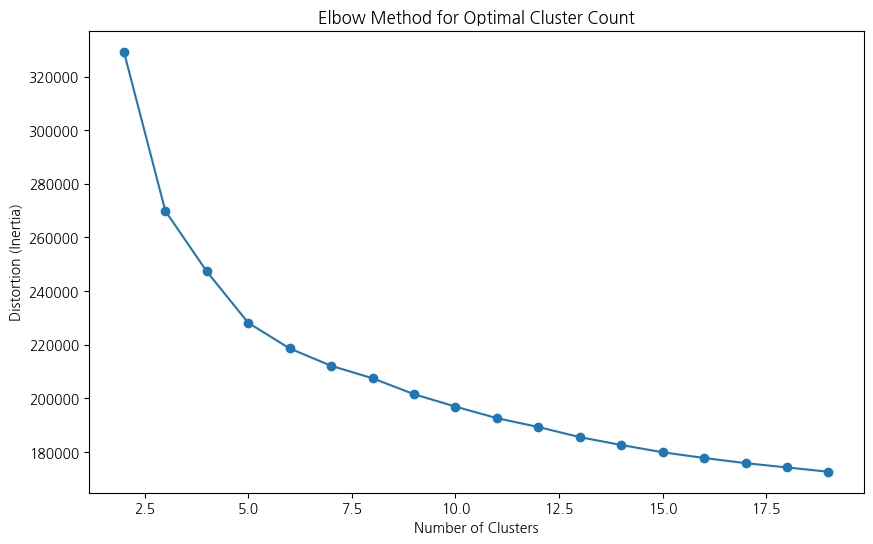

In [52]:
from tqdm.auto import tqdm


# 팩터화 이후 클러스터링 진행

cluster_counts = range(2, 20)

distortions = []
for k in tqdm(cluster_counts):
    km = KMeans(n_clusters=k,
                verbose=False,
                random_state=42)

    # 사전에 스케일링한 것으로 k-means 돌림
    km.fit(float_data_scaled)
    distortions.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, distortions, marker='o')
plt.title('Elbow Method for Optimal Cluster Count')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion (Inertia)')
plt.show()

## 2.2 실루엣 계수

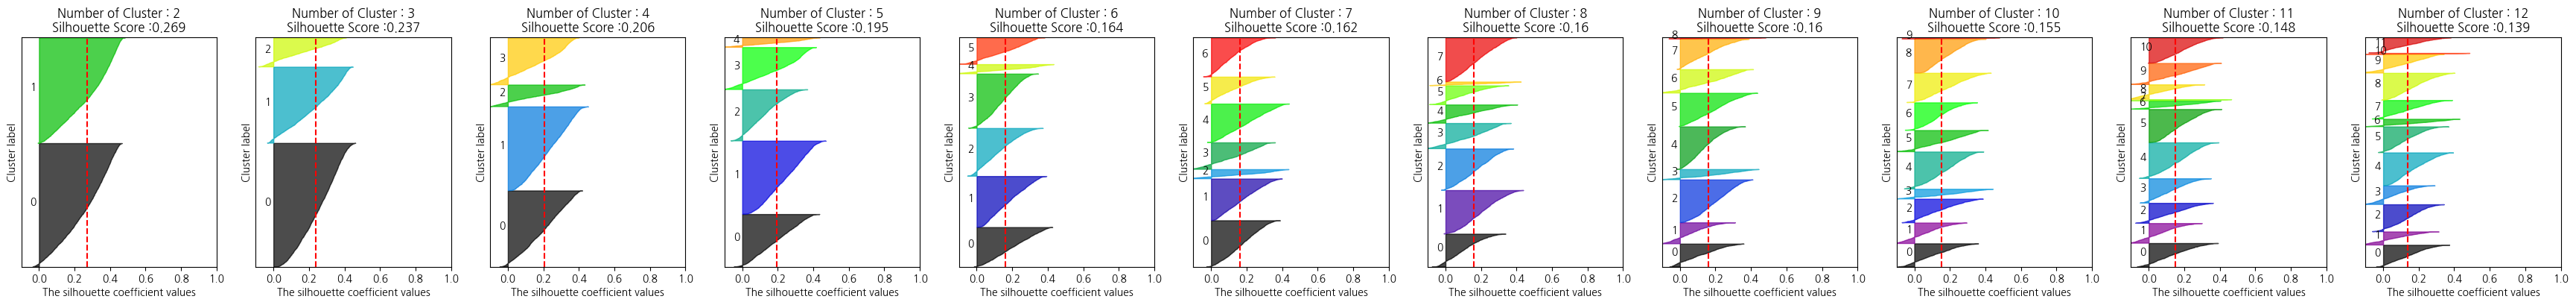

In [53]:
# 실루엣 계수로 최적 군집 수 찾기
## 6개가 더 깔끔해보임
visualize_silhouette([2,3,4,5,6,7,8,9,10,11,12], float_data)
plt.savefig("silhouette.png")

In [54]:
cluster_total_10_month = pd.concat([float_data, per_amt_df_10_month], axis=1)
cluster_total_10_month

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),pk2(성별),pk3(연령대),pk4(지역),cc01m(이용금액_백화점),cc02m(이용금액_마트),cc03m(이용금액_편의점),cc04m(이용금액_이커머스),cc05m(이용금액_면세점),cc06m(이용금액_의류),cc07m(이용금액_화장품),cc08m(이용금액_가전),cc09m(이용금액_생활용품),cc10o(이용금액_신차),cc11o(이용금액_중고차),cc12o(이용금액_수입차),cc13o(이용금액_오토바이),cd01m(이용금액_식당),cd02m(이용금액_대형고가커피),cd03m(이용금액_소형저가커피),cd04m(이용금액_배달앱),ce01m(이용금액_고속버스),ce02m(이용금액_택시),ce03m(이용금액_항공),ce04m(이용금액_철도),ce05m(이용금액_여객선),ce06m(이용금액_통신요금),ce07m(이용금액_서점),ce08m(이용금액_네컷사진),ce09m(이용금액_안경),ce10m(이용금액_세탁소),ce11m(이용금액_미용실),ce12m(이용금액_렌터카),ce13m(이용금액_주유소),ce14m(이용금액_LPG가스),ce15m(이용금액_전기차충전),cf01m(이용금액_학원학습지),cf02m(이용금액_병원),cf03m(이용금액_치과),cf04m(이용금액_약국),cf05m(이용금액_예식),cf06m(이용금액_장례),cf07m(이용금액_보험),cf08m(이용금액_기부금),cg01m(이용금액_특급호텔),cg02m(이용금액_숙박),cg03m(이용금액_여행사),cg04m(이용금액_제주여행),cg05m(이용금액_동해여행),cg06m(이용금액_남해여행),cg07m(이용금액_스포츠센터),cg08m(이용금액_수영장),cg09m(이용금액_당구장),cg10m(이용금액_실외골프장),cg11m(이용금액_실내골프장),cg12m(이용금액_테니스장),cg13m(이용금액_볼링장),cg14m(이용금액_놀이동산),cg15m(이용금액_자전거),cg16m(이용금액_레져용품),cg17m(이용금액_예술품),cg18m(이용금액_화원),cg19m(이용금액_전시/관람/체험),cg20m(이용금액_오락실/PC방),cg21m(이용금액_OTT서비스),cg22m(이용금액_해외여행직구)
0,2.515000,3.016667,4.975000,5.360000,0.805000,1.640000,1.250000,1.000000,1.506667,4.190000,2.301667,4.288333,9.513333,1.513333,1.408333,0.500000,1.000000,0.991667,1.073333,2.603333,1.268333,5.545000,0.166667,1.950000,2.276667,15.770000,0.666667,1.203333,1.666667,1.101667,2.810000,3.433333,0.066667,F,30e,11110515.0,42743.540662,23519.174579,6747.177065,31189.759542,83575.187970,65078.808006,91820.000000,77500.000000,26375.440195,1.000000,1.0,1.00,1.000000,28473.273223,17078.491721,4880.000000,24546.958713,12000.000000,9379.959233,327111.428571,41879.194895,5000.000000,61270.854336,22935.359717,5666.666667,125000.000000,1.000000,54201.372701,59000.0,49596.064594,46600.000000,0.000000,169070.165167,45338.303905,143251.378446,13930.310066,3.000000e+03,40300.000000,64043.374991,0.0,1.000000,126913.533835,40000.000000,64915.614705,27212.157982,231000.000000,107508.333333,0.000000,0.000000,252666.666667,0.000000,0.000000,113000.000000,31500.000000,0.000000,108600.000000,55750.000000,43129.239766,12077.022461,3000.000000,13461.852806,91216.089071
1,2.621667,2.970000,5.293333,4.568333,1.390000,1.246667,1.125000,1.000000,1.346667,4.363333,2.768333,4.265000,9.675000,1.305000,1.468333,1.000000,1.033333,1.210000,1.073333,2.236667,1.585000,5.833333,0.500000,1.276667,3.456667,10.328333,0.666667,1.290000,1.750000,1.091667,2.620000,4.683333,0.081667,F,30e,11110530.0,52309.431599,18723.688479,6639.289714,35489.337206,99061.377246,66462.287546,49622.222222,55000.000000,17900.964001,1.000000,1.0,1.00,1.000000,29615.823554,16317.089912,4204.366484,25059.418327,8066.666667,9598.405069,303780.952381,44230.824028,36000.000000,56247.035992,26932.435612,5200.000000,100694.444444,22445.590472,58603.296726,67000.0,58253.901169,2000.000000,1.000000,194649.964446,55989.049685,132276.274519,12946.223031,1.752250e+06,52913.951546,80692.160793,0.0,105269.806734,192739.028849,28000.000000,23075.000000,75309.098543,68693.939394,126044.598961,16000.000000,0.000000,102000.000000,38666.666667,0.000000,49000.000000,9321.428571,0.000000,105000.000000,9750.000000,45500.000000,13377.341670,1423.076923,11918.306006,89801.312528
2,2.680000,3.275000,8.873333,2.956667,0.000000,1.666667,0.500000,0.000000,1.138333,4.498333,4.665000,4.273333,9.465000,1.415000,1.166667,0.333333,0.500000,0.333333,0.833333,2.570000,1.166667,5.393333,0.000000,1.170000,2.333333,6.750000,0.000000,0.750000,0.500000,1.000000,3.108333,2.583333,0.118333,F,30e,11110540.0,42934.780187,30107.438611,6918.378979,40135.679661,0.000000,52000.000000,31250.000000,0.000000,17454.469507,1.000000,1.0,1.00,1.000000,28228.573759,10946.532999,3738.095238,28841.344587,15000.000000,11590.967542,234333.333333,25687.267267,0.000000,45264.901765,20466.666667,5000.000000,38333.333333,21000.000000,35600.000000,0.0,30705.216964,0.000000,0.000000,1

In [55]:
kmeans = KMeans(n_clusters=6, random_state=42)

cluster_labels = kmeans.fit_predict(float_data_scaled)

cluster_total_10_month['cluster'] = cluster_labels
cluster_data_10_month['cluster'] = cluster_labels
float_data['cluster'] = cluster_labels
cluster_total_10_month['pk'] = object_data['pk5']
cluster_total_10_month = cluster_total_10_month.drop(columns=["pk2(성별)","pk3(연령대)","pk4(지역)"])
cluster_data_10_month.head()

,pk2(성별),pk3(연령대),pk4(지역),백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster
0,F,30e,11110515,2.515000,3.016667,4.975000,5.360000,0.805,1.640000,1.250000,1.0,1.506667,4.190000,2.301667,4.288333,9.513333,1.513333,1.408333,0.500000,1.000000,0.991667,1.073333,2.603333,1.268333,5.545000,0.166667,1.950000,2.276667,15.770000,0.666667,1.203333,1.666667,1.101667,2.810000,3.433333,0.066667,4
1,F,30e,11110530,2.621667,2.970000,5.293333,4.568333,1.390,1.246667,1.125000,1.0,1.346667,4.363333,2.768333,4.265000,9.675000,1.305000,1.468333,1.000000,1.033333,1.210000,1.073333,2.236667,1.585000,5.833333,0.500000,1.276667,3.456667,10.328333,0.666667,1.290000,1.750000,1.091667,2.620000,4.683333,0.081667,4
2,F,30e,11110540,2.680000,3.275000,8.873333,2.956667,0.000,1.666667,0.500000,0.0,1.138333,4.498333,4.665000,4.273333,9.465000,1.415000,1.166667,0.333333,0.500000,0.333333,0.833333,2.570000,1.166667,5.393333,0.000000,1.170000,2.333333,6.750000,0.000000,0.750000,0.500000,1.000000,3.108333,2.583333,0.118333,2
3,F,30e,11110550,3.093333,2.730000,4.768333,5.096667,0.750,1.160000,0.750000,1.0,1.413333,3.705000,2.368333,3.741667,9.268333,1.383333,1.503333,0.500000,0.666667,0.666667,1.000000,3.338333,2.141667,5.566667,0.166667,1.233333,2.800000,7.711667,0.500000,1.288333,0.666667,1.076667,2.695000,3.416667,0.076667,1
4,F,30e,11110560,2.565000,3.761667,3.580000,5.308333,1.055,1.301667,1.173333,1.0,1.496667,3.673333,2.943333,3.726667,8.588333,1.285000,1.380000,1.000000,1.000000,1.191667,1.145000,4.281667,1.798333,5.726667,0.000000,1.855000,2.873333,7.475000,0.388333,1.463333,0.666667,1.010000,2.386667,5.646667,0.081667,4


In [56]:
cluster_total_10_month

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cc01m(이용금액_백화점),cc02m(이용금액_마트),cc03m(이용금액_편의점),cc04m(이용금액_이커머스),cc05m(이용금액_면세점),cc06m(이용금액_의류),cc07m(이용금액_화장품),cc08m(이용금액_가전),cc09m(이용금액_생활용품),cc10o(이용금액_신차),cc11o(이용금액_중고차),cc12o(이용금액_수입차),cc13o(이용금액_오토바이),cd01m(이용금액_식당),cd02m(이용금액_대형고가커피),cd03m(이용금액_소형저가커피),cd04m(이용금액_배달앱),ce01m(이용금액_고속버스),ce02m(이용금액_택시),ce03m(이용금액_항공),ce04m(이용금액_철도),ce05m(이용금액_여객선),ce06m(이용금액_통신요금),ce07m(이용금액_서점),ce08m(이용금액_네컷사진),ce09m(이용금액_안경),ce10m(이용금액_세탁소),ce11m(이용금액_미용실),ce12m(이용금액_렌터카),ce13m(이용금액_주유소),ce14m(이용금액_LPG가스),ce15m(이용금액_전기차충전),cf01m(이용금액_학원학습지),cf02m(이용금액_병원),cf03m(이용금액_치과),cf04m(이용금액_약국),cf05m(이용금액_예식),cf06m(이용금액_장례),cf07m(이용금액_보험),cf08m(이용금액_기부금),cg01m(이용금액_특급호텔),cg02m(이용금액_숙박),cg03m(이용금액_여행사),cg04m(이용금액_제주여행),cg05m(이용금액_동해여행),cg06m(이용금액_남해여행),cg07m(이용금액_스포츠센터),cg08m(이용금액_수영장),cg09m(이용금액_당구장),cg10m(이용금액_실외골프장),cg11m(이용금액_실내골프장),cg12m(이용금액_테니스장),cg13m(이용금액_볼링장),cg14m(이용금액_놀이동산),cg15m(이용금액_자전거),cg16m(이용금액_레져용품),cg17m(이용금액_예술품),cg18m(이용금액_화원),cg19m(이용금액_전시/관람/체험),cg20m(이용금액_오락실/PC방),cg21m(이용금액_OTT서비스),cg22m(이용금액_해외여행직구),cluster,pk
0,2.515000,3.016667,4.975000,5.360000,0.805000,1.640000,1.250000,1.000000,1.506667,4.190000,2.301667,4.288333,9.513333,1.513333,1.408333,0.500000,1.000000,0.991667,1.073333,2.603333,1.268333,5.545000,0.166667,1.950000,2.276667,15.770000,0.666667,1.203333,1.666667,1.101667,2.810000,3.433333,0.066667,42743.540662,23519.174579,6747.177065,31189.759542,83575.187970,65078.808006,91820.000000,77500.000000,26375.440195,1.000000,1.0,1.00,1.000000,28473.273223,17078.491721,4880.000000,24546.958713,12000.000000,9379.959233,327111.428571,41879.194895,5000.000000,61270.854336,22935.359717,5666.666667,125000.000000,1.000000,54201.372701,59000.0,49596.064594,46600.000000,0.000000,169070.165167,45338.303905,143251.378446,13930.310066,3.000000e+03,40300.000000,64043.374991,0.0,1.000000,126913.533835,40000.000000,64915.614705,27212.157982,231000.000000,107508.333333,0.000000,0.000000,252666.666667,0.000000,0.000000,113000.000000,31500.000000,0.000000,108600.000000,55750.000000,43129.239766,12077.022461,3000.000000,13461.852806,91216.089071,4,F-30e-11110515
1,2.621667,2.970000,5.293333,4.568333,1.390000,1.246667,1.125000,1.000000,1.346667,4.363333,2.768333,4.265000,9.675000,1.305000,1.468333,1.000000,1.033333,1.210000,1.073333,2.236667,1.585000,5.833333,0.500000,1.276667,3.456667,10.328333,0.666667,1.290000,1.750000,1.091667,2.620000,4.683333,0.081667,52309.431599,18723.688479,6639.289714,35489.337206,99061.377246,66462.287546,49622.222222,55000.000000,17900.964001,1.000000,1.0,1.00,1.000000,29615.823554,16317.089912,4204.366484,25059.418327,8066.666667,9598.405069,303780.952381,44230.824028,36000.000000,56247.035992,26932.435612,5200.000000,100694.444444,22445.590472,58603.296726,67000.0,58253.901169,2000.000000,1.000000,194649.964446,55989.049685,132276.274519,12946.223031,1.752250e+06,52913.951546,80692.160793,0.0,105269.806734,192739.028849,28000.000000,23075.000000,75309.098543,68693.939394,126044.598961,16000.000000,0.000000,102000.000000,38666.666667,0.000000,49000.000000,9321.428571,0.000000,105000.000000,9750.000000,45500.000000,13377.341670,1423.076923,11918.306006,89801.312528,4,F-30e-11110530
2,2.680000,3.275000,8.873333,2.956667,0.000000,1.666667,0.500000,0.000000,1.138333,4.498333,4.665000,4.273333,9.465000,1.415000,1.166667,0.333333,0.500000,0.333333,0.833333,2.570000,1.166667,5.393333,0.000000,1.170000,2.333333,6.750000,0.000000,0.750000,0.500000,1.000000,3.108333,2.583333,0.118333,42934.780187,30107.438611,6918.378979,40135.679661,0.000000,52000.000000,31250.000000,0.000000,17454.469507,1.000000,1.0,1.00,1.000000,28228.573759,10946.532999,3738.095238,28841.344587,15000.000000,11590.967542,234333.333333,25687.267267,0.000000,45264.901765,20466.666667,5000.000000,38333.333333,21000.000000,35600.000000,0.0,30705.216964,0.000000,0.000000,105083.333333,63606.875450,10440

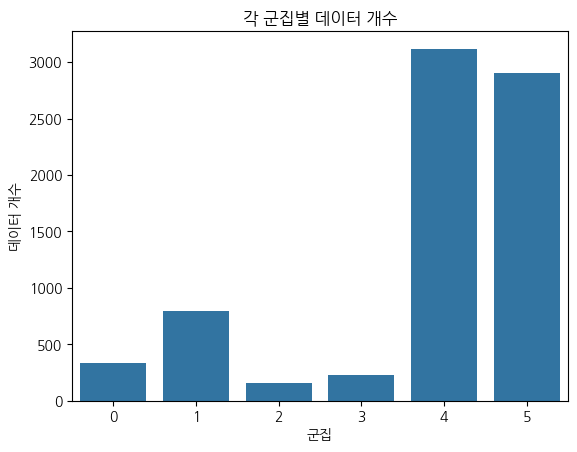

In [57]:
# bank_card_after_PCA_cluster 데이터프레임에서 군집 라벨별 빈도수 계산
cluster_counts = cluster_data_10_month['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']

# 막대 그래프 시각화
sns.barplot(data=cluster_counts, x='cluster', y='count')
plt.xlabel('군집')
plt.ylabel('데이터 개수')
plt.title('각 군집별 데이터 개수')
plt.show()

In [58]:
# 각 군집별로 어떠한 인구집단이 분포돼 있는지 궁금해짐
float_data['pk'] = object_data['pk5']

In [59]:
# cluster_uni = list(cluster['cluster'].unique())
# cluster_uni.sort()

# for i in cluster_uni :
#     cluster_tmp = cluster[cluster['cluster'] == i]['pk']
#     print(f"군집 {i} 에 소속돼 있는 pk는 다음과 같음:\n{cluster_tmp.unique()}\n")

### 군집별 특성 분석

In [60]:
def show_pk_info(cluster: pd.DataFrame, cluster_num: int):
    # 데이터를 저장할 빈 리스트 생성
    gender = []
    age = []
    region_code = []
    tmp = cluster['pk'][cluster['cluster'] == cluster_num]
    
    # 데이터를 '-'로 분할하고 각각의 정보를 해당 리스트에 추가
    for item in tmp:
        parts = item.split('-')
        gender.append(parts[0])
        age.append(parts[1])
        region_code.append(parts[2])
    
    # 데이터를 DataFrame으로 변환
    result_df = pd.DataFrame({'성별': gender, '연령': age, '지역코드': region_code})
    # 성별, 연령 기준으로 보기
    result_df = result_df[['성별', '연령']].value_counts().reset_index()
    
    # 결과 출력
    return result_df



In [118]:
# 두개의 pk를 기준으로 그림 그리는 함수
def plot_column_by_multiple_pk(df: pd.DataFrame,
                              pk_name_1: str, pk_name_2: str, col_name: str,
                              width: int=8, height: int=6) -> None:

    # 입력된 정보를 바탕으로 groupby => 우선 mean()함수를 활용해서 단순 합계를 만듦
    df_new = df.groupby([pk_name_1, pk_name_2])[col_name].mean().reset_index()

    # 그래프 사이즈 조정
    plt.figure(figsize=(width, height))


    # 막대그래프 그램 => color: 신한은행 파랑?!?!
    sns.barplot(data= df_new, x=pk_name_1, y = col_name, hue = pk_name_2,
                              palette=['#a941c8', '#458bff'])
    # 과학적표기법 제거
    plt.ticklabel_format(style='plain', axis='y')
    
    # x, y 라벨링
    plt.xlabel(pk_name_1)
    plt.ylabel(col_name)
    plt.title(f'{pk_name_1}에 따른 {col_name} 건수 평균')
    
    plt.show()

In [119]:
float_data

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster,pk
0,2.515000,3.016667,4.975000,5.360000,0.805000,1.640000,1.250000,1.000000,1.506667,4.190000,2.301667,4.288333,9.513333,1.513333,1.408333,0.500000,1.000000,0.991667,1.073333,2.603333,1.268333,5.545000,0.166667,1.950000,2.276667,15.770000,0.666667,1.203333,1.666667,1.101667,2.810000,3.433333,0.066667,4,F-30e-11110515
1,2.621667,2.970000,5.293333,4.568333,1.390000,1.246667,1.125000,1.000000,1.346667,4.363333,2.768333,4.265000,9.675000,1.305000,1.468333,1.000000,1.033333,1.210000,1.073333,2.236667,1.585000,5.833333,0.500000,1.276667,3.456667,10.328333,0.666667,1.290000,1.750000,1.091667,2.620000,4.683333,0.081667,4,F-30e-11110530
2,2.680000,3.275000,8.873333,2.956667,0.000000,1.666667,0.500000,0.000000,1.138333,4.498333,4.665000,4.273333,9.465000,1.415000,1.166667,0.333333,0.500000,0.333333,0.833333,2.570000,1.166667,5.393333,0.000000,1.170000,2.333333,6.750000,0.000000,0.750000,0.500000,1.000000,3.108333,2.583333,0.118333,2,F-30e-11110540
3,3.093333,2.730000,4.768333,5.096667,0.750000,1.160000,0.750000,1.000000,1.413333,3.705000,2.368333,3.741667,9.268333,1.383333,1.503333,0.500000,0.666667,0.666667,1.000000,3.338333,2.141667,5.566667,0.166667,1.233333,2.800000,7.711667,0.500000,1.288333,0.666667,1.076667,2.695000,3.416667,0.076667,1,F-30e-11110550
4,2.565000,3.761667,3.580000,5.308333,1.055000,1.301667,1.173333,1.000000,1.496667,3.673333,2.943333,3.726667,8.588333,1.285000,1.380000,1.000000,1.000000,1.191667,1.145000,4.281667,1.798333,5.726667,0.000000,1.855000,2.873333,7.475000,0.388333,1.463333,0.666667,1.010000,2.386667,5.646667,0.081667,4,F-30e-11110560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2.416000,4.104000,8.050000,3.304000,1.550000,1.300000,0.800000,1.030000,1.296000,4.696000,3.102000,3.450000,6.954000,1.656000,1.318000,1.300000,1.000000,1.200000,1.038000,9.698000,1.952000,5.702000,1.700000,2.194000,4.052000,16.118000,0.200000,1.394000,2.584000,1.096000,2.450000,12.970000,0.036000,5,M-40s-41500253
7540,1.937500,4.825000,7.080000,4.942500,1.272500,1.250000,1.000000,1.030000,1.195000,4.557500,3.337500,3.297500,9.000000,1.667500,1.275000,1.255000,1.015000,1.117500,1.060000,8.075000,1.980000,6.057500,1.000000,1.880000,3.700000,14.335000,0.500000,1.340000,3.580000,1.085000,2.590000,13.617500,0.092500,5,M-40s-41570550
7541,2.425000,5.116667,7.476667,3.713333,1.491667,1.368333,1.033333,1.008333,1.308333,4.608333,3.015000,4.046667,8.253333,1.701667,1.263333,1.123333,1.066667,1.131667,1.061667,9.323333,1.816667,6.056667,0.555000,2.008333,3.070000,15.755000,0.666667,1.398333,3.513333,1.150000,2.498333,13.305000,0.050000,5,M-40s-41590259
7542,2.421667,4.485000,6.695000,5.140000,1.406667,1.451667,1.041667,1.010000,1.373333,4.596667,3.148333,3.293333,7.766667,1.651667,1.321667,1.223333,1.000000,1.168333,1.058333,9.288333,1.990000,5.928333,1.250000,1.950000,3.283333,16.243333,0.500000,1.401667,3.173333,1.115000,2.635000,13.938333,0.045000,5,M-40s-41590600


#### 0번군집

In [120]:
tmp = float_data['pk'][float_data['cluster'] == 1]
tmp[:10]

3     F-30e-11110550
5     F-30e-11110570
7     F-30e-11110600
9     F-30e-11110630
14    F-30e-11110690
15    F-30e-11110700
18    F-30e-11140540
20    F-30e-11140570
21    F-30e-11140580
22    F-30e-11140590
Name: pk, dtype: object

In [121]:
# 연령, 성별 정보 보기
cluster_0_info = show_pk_info(float_data, 0)
cluster_0_info

,성별,연령,count
0,M,30s,91
1,F,30s,50
2,M,40e,44
3,M,30e,42
4,F,30e,31
5,F,40e,28
6,M,40s,28
7,F,40s,24


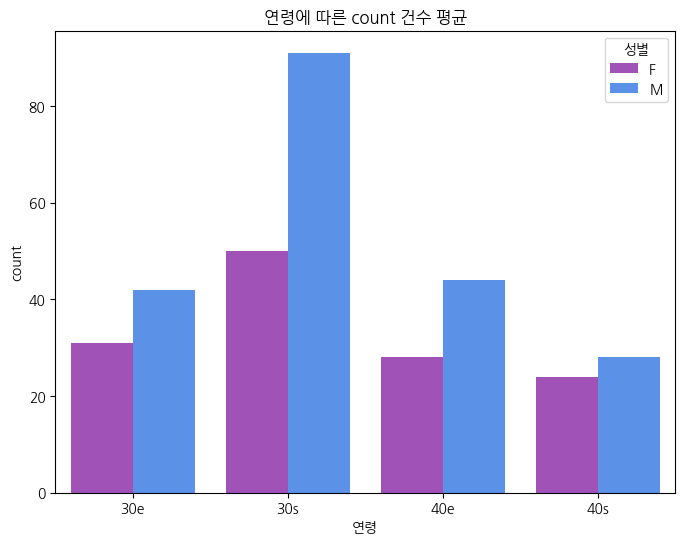

In [122]:
# 여성이 모든 부문에서 압도하네
## 여성은 30대가 주류?? => 나중에 비율 보기
plot_column_by_multiple_pk(df=cluster_0_info, pk_name_1='연령', pk_name_2 = '성별', col_name='count')

<Axes: ylabel='count'>

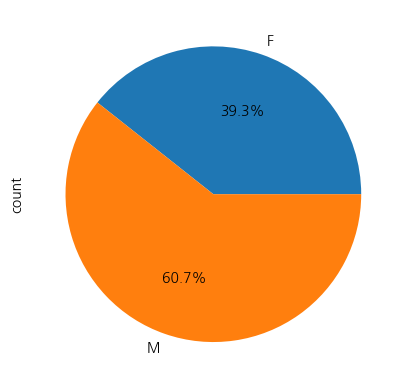

In [123]:
cluster_0_info.groupby(['성별'])['count'].sum().plot.pie(autopct='%1.1f%%')

In [124]:
cluster_0 = float_data[float_data['cluster'] == 0]
cluster_0.head()

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster,pk
13,2.295000,4.603333,5.320000,5.745000,0.000000,1.000000,0.500000,0.833333,1.611667,3.491667,3.418333,3.256667,6.361667,1.380000,0.666667,0.333333,0.500000,0.166667,1.166667,1.421667,0.833333,5.145000,0.000000,2.075000,1.000000,7.166667,0.166667,0.833333,0.666667,1.000000,2.110000,1.833333,0.090000,0,F-30e-11110680
34,3.235000,3.736667,5.483333,5.303333,0.833333,1.526667,0.583333,0.666667,1.613333,4.210000,3.238333,3.085000,8.836667,1.516667,1.166667,0.166667,0.833333,0.833333,1.056667,2.071667,1.311667,5.296667,0.000000,1.605000,2.026667,5.736667,0.000000,0.833333,0.166667,1.000000,1.591667,4.083333,0.091667,0,F-30e-11170530
51,1.830000,4.188333,5.098333,5.390000,0.500000,1.155000,1.000000,0.666667,1.326667,4.253333,3.171667,3.878333,8.058333,1.396667,1.388333,0.166667,0.333333,1.278333,1.076667,2.833333,1.500000,5.676667,0.166667,1.313333,2.640000,5.875000,0.000000,1.366667,0.611667,1.378333,1.978333,3.083333,0.128333,0,F-30e-11200550
145,2.266667,3.421667,5.365000,4.415000,0.000000,1.625000,1.083333,0.833333,1.448333,3.876667,2.883333,4.456667,10.355000,1.425000,1.138333,0.833333,1.000000,0.333333,1.000000,5.470000,1.403333,5.415000,0.500000,2.108333,2.166667,5.083333,0.000000,1.093333,1.000000,1.000000,1.411667,4.700000,0.095000,0,F-30e-11320513
166,2.313333,6.278333,5.486667,5.063333,0.666667,1.180000,0.833333,0.666667,1.563333,4.275000,3.206667,4.100000,7.905000,1.345000,1.386667,0.666667,0.833333,1.166667,1.178333,3.196667,2.043333,5.823333,0.000000,2.033333,3.330000,14.338333,0.000000,1.376667,1.000000,1.258333,3.525000,4.266667,0.151667,0,F-30e-11350624


In [125]:
# 단순평균
## 여행, 대중교통, 레저 다수!(여행을많이 가나보다)
## 반면 자동차
cluster_total_10_month.drop(columns='pk').mean().sort_values(ascending=False)

cf01m(이용금액_학원학습지)      207852.336696
ce03m(이용금액_항공)         204707.848235
cf05m(이용금액_예식)         201207.065898
cg10m(이용금액_실외골프장)      133956.416338
cg07m(이용금액_스포츠센터)      129337.556236
                           ...      
화장품                         0.885424
사진                          0.829322
예식                          0.341397
예술품                         0.220661
lb04r(보험계약고객비율_어린이)         0.127937
Length: 96, dtype: float64

<Axes: >

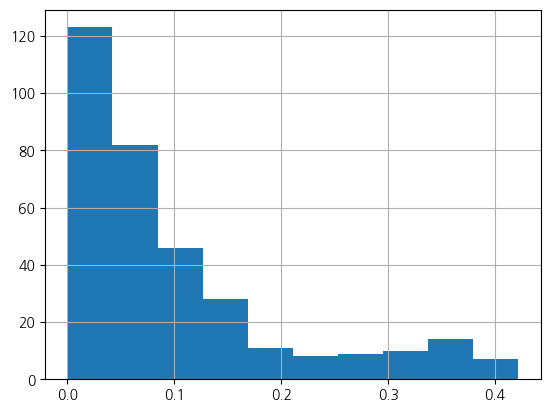

In [126]:
cluster_0['lb04r(보험계약고객비율_어린이)'].hist()

In [127]:
cluster_total_10_month[cluster_total_10_month['cluster'] == 0].drop(columns='pk').mean().sort_values(ascending=False)[:50]

cf01m(이용금액_학원학습지)       192549.622559
ce03m(이용금액_항공)          181443.508517
cf05m(이용금액_예식)          179581.017219
cg07m(이용금액_스포츠센터)       125623.523861
cg10m(이용금액_실외골프장)       115563.678954
cf03m(이용금액_치과)          108888.384016
cg02m(이용금액_숙박)           91844.157497
cf07m(이용금액_보험)           89121.178975
cc05m(이용금액_면세점)          83077.475557
cc08m(이용금액_가전)           82502.920113
ce09m(이용금액_안경)           78332.887432
cg16m(이용금액_레져용품)         78103.180254
cg22m(이용금액_해외여행직구)       74270.665848
cc06m(이용금액_의류)           63205.432929
ce06m(이용금액_통신요금)         61747.047805
cc01m(이용금액_백화점)          54618.674429
cc07m(이용금액_화장품)          50922.189445
ce12m(이용금액_렌터카)          47712.981262
cg04m(이용금액_제주여행)         46360.986721
ce13m(이용금액_주유소)          45590.221709
cf06m(이용금액_장례)           45158.923616
cg01m(이용금액_특급호텔)         41490.701525
cf02m(이용금액_병원)           40082.421131
ce11m(이용금액_미용실)          38786.921261
cc04m(이용금액_이커머스)         35845.923890
ce14m(이용금액_LPG가스)        32970.676436
cd01m(이용금액_식

In [207]:
cluster_total_10_month.to_csv('cluster_total.csv', index=False)

#### 1번군집

In [128]:
cluster_1 = float_data[float_data['cluster'] == 1]
cluster_1.head()

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster,pk
3,3.093333,2.730000,4.768333,5.096667,0.750000,1.160000,0.750000,1.000000,1.413333,3.705000,2.368333,3.741667,9.268333,1.383333,1.503333,0.500000,0.666667,0.666667,1.000000,3.338333,2.141667,5.566667,0.166667,1.233333,2.800000,7.711667,0.5,1.288333,0.666667,1.076667,2.695000,3.416667,0.076667,1,F-30e-11110550
5,2.781667,3.863333,3.920000,6.606667,0.333333,1.176667,0.666667,1.033333,1.370000,4.073333,2.851667,4.215000,8.913333,1.480000,1.285000,0.500000,0.666667,0.666667,1.083333,4.140000,1.951667,6.580000,0.000000,1.450000,2.783333,6.755000,0.5,1.343333,1.000000,1.053333,2.751667,5.758333,0.080000,1,F-30e-11110570
7,2.433333,3.901667,5.960000,4.658333,0.416667,1.096667,0.500000,1.000000,1.301667,5.001667,2.625000,3.540000,8.268333,1.666667,1.221667,0.500000,0.833333,0.000000,1.055000,2.956667,2.138333,5.203333,0.166667,2.711667,2.830000,7.028333,0.0,0.666667,0.333333,1.301667,2.638333,3.250000,0.063333,1,F-30e-11110600
9,3.093333,3.248333,5.006667,5.263333,0.000000,1.600000,0.666667,1.000000,1.850000,3.661667,2.611667,4.571667,9.308333,1.408333,0.666667,0.000000,0.500000,0.333333,1.083333,2.945000,1.041667,5.386667,0.000000,1.846667,2.533333,4.361667,0.0,0.833333,0.166667,1.345000,4.361667,2.500000,0.106667,1,F-30e-11110630
14,2.613333,3.100000,3.860000,4.351667,0.250000,1.415000,0.833333,1.033333,1.426667,3.413333,2.930000,3.565000,7.815000,1.365000,1.138333,0.166667,0.666667,0.666667,1.021667,1.933333,0.945000,5.061667,0.333333,2.073333,3.266667,6.083333,0.0,1.083333,0.166667,1.000000,2.026667,2.166667,0.091667,1,F-30e-11110690


In [129]:
cluster_1_info = show_pk_info(float_data, 1)
cluster_1_info

,성별,연령,count
0,F,30e,121
1,M,40e,117
2,M,40s,104
3,M,30e,101
4,F,40s,96
5,F,40e,95
6,F,30s,84
7,M,30s,77


<Axes: ylabel='count'>

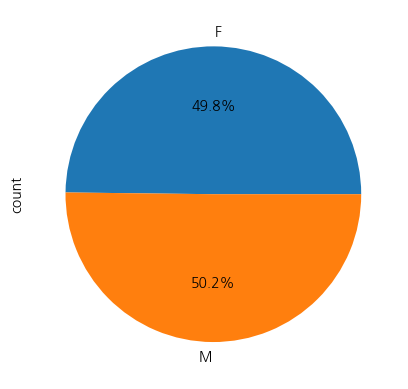

In [130]:
cluster_1_info.groupby(['성별'])['count'].sum().plot.pie(autopct='%1.1f%%')

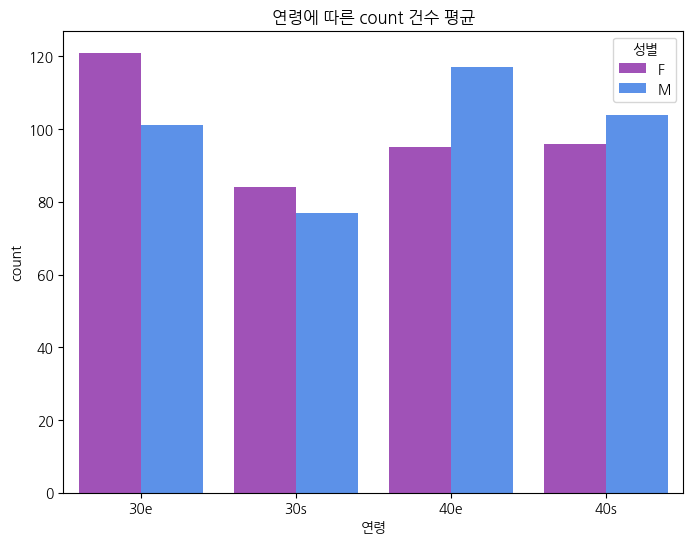

In [131]:
# 여성/성이 3:1?

plot_column_by_multiple_pk(df=cluster_1_info, pk_name_1='연령', pk_name_2 = '성별', col_name='count')

In [132]:
cluster_1.head()

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster,pk
3,3.093333,2.730000,4.768333,5.096667,0.750000,1.160000,0.750000,1.000000,1.413333,3.705000,2.368333,3.741667,9.268333,1.383333,1.503333,0.500000,0.666667,0.666667,1.000000,3.338333,2.141667,5.566667,0.166667,1.233333,2.800000,7.711667,0.5,1.288333,0.666667,1.076667,2.695000,3.416667,0.076667,1,F-30e-11110550
5,2.781667,3.863333,3.920000,6.606667,0.333333,1.176667,0.666667,1.033333,1.370000,4.073333,2.851667,4.215000,8.913333,1.480000,1.285000,0.500000,0.666667,0.666667,1.083333,4.140000,1.951667,6.580000,0.000000,1.450000,2.783333,6.755000,0.5,1.343333,1.000000,1.053333,2.751667,5.758333,0.080000,1,F-30e-11110570
7,2.433333,3.901667,5.960000,4.658333,0.416667,1.096667,0.500000,1.000000,1.301667,5.001667,2.625000,3.540000,8.268333,1.666667,1.221667,0.500000,0.833333,0.000000,1.055000,2.956667,2.138333,5.203333,0.166667,2.711667,2.830000,7.028333,0.0,0.666667,0.333333,1.301667,2.638333,3.250000,0.063333,1,F-30e-11110600
9,3.093333,3.248333,5.006667,5.263333,0.000000,1.600000,0.666667,1.000000,1.850000,3.661667,2.611667,4.571667,9.308333,1.408333,0.666667,0.000000,0.500000,0.333333,1.083333,2.945000,1.041667,5.386667,0.000000,1.846667,2.533333,4.361667,0.0,0.833333,0.166667,1.345000,4.361667,2.500000,0.106667,1,F-30e-11110630
14,2.613333,3.100000,3.860000,4.351667,0.250000,1.415000,0.833333,1.033333,1.426667,3.413333,2.930000,3.565000,7.815000,1.365000,1.138333,0.166667,0.666667,0.666667,1.021667,1.933333,0.945000,5.061667,0.333333,2.073333,3.266667,6.083333,0.0,1.083333,0.166667,1.000000,2.026667,2.166667,0.091667,1,F-30e-11110690


<Axes: >

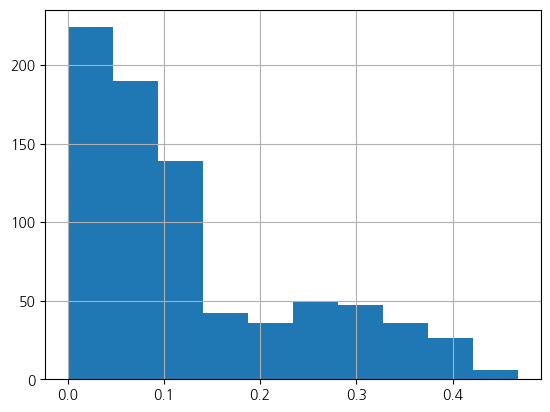

In [133]:
cluster_1['lb04r(보험계약고객비율_어린이)'].hist()

In [134]:
# 여기도 여행과 대중교통 이용 많이 하네
## 전반적으로 0과 비슷
cluster_1.drop(columns='pk').mean().sort_values(ascending=False)

여행                     7.676355
대중교통                   7.129001
편의점                    5.759568
연료                     5.365098
의료                     5.288379
레져/레져용품/               5.014703
이커머스                   4.380300
마트                     4.200325
배달앱                    4.173995
요식                     4.024807
커피                     2.756057
숙박                     2.604456
백화점                    2.180297
해외                     1.991295
보험                     1.975551
오락실/PC방                1.848256
통신요금                   1.497827
교육                     1.375893
생활용품                   1.345359
의류                     1.171235
전시/관람/체험               1.102132
OTT서비스                 1.031365
가전                     1.015545
미용실                    1.015541
cluster                1.000000
서점                     0.874397
세탁소                    0.729091
안경                     0.649710
화장품                    0.582592
면세점                    0.440045
사진                     0.409943
lb04r(보험

In [135]:
cluster_total_10_month[cluster_total_10_month['cluster'] == 1].drop(columns='pk').mean().sort_values(ascending=False)[:50]

cf01m(이용금액_학원학습지)       190172.521158
ce03m(이용금액_항공)          164880.004712
cg07m(이용금액_스포츠센터)       111763.939224
cg10m(이용금액_실외골프장)       101626.013796
cf03m(이용금액_치과)           99999.891930
cf05m(이용금액_예식)           92088.283997
cg02m(이용금액_숙박)           92047.078313
cf07m(이용금액_보험)           92024.622138
cg16m(이용금액_레져용품)         80053.528051
cg22m(이용금액_해외여행직구)       77316.437123
ce09m(이용금액_안경)           77089.276168
cc05m(이용금액_면세점)          69686.244418
cc08m(이용금액_가전)           67183.722804
cc06m(이용금액_의류)           62640.282391
ce06m(이용금액_통신요금)         59758.138512
cc01m(이용금액_백화점)          55563.882197
cg04m(이용금액_제주여행)         52383.777578
ce13m(이용금액_주유소)          46560.792755
cf06m(이용금액_장례)           46305.348609
cc07m(이용금액_화장품)          46119.473059
ce12m(이용금액_렌터카)          42682.993711
cf02m(이용금액_병원)           40719.022471
ce11m(이용금액_미용실)          37567.415709
cc04m(이용금액_이커머스)         35247.757874
ce14m(이용금액_LPG가스)        33614.701560
cd01m(이용금액_식당)           32676.338000
cg01m(이용금액_특

#### 2번군집

In [136]:
cluster_2 = float_data[float_data['cluster'] == 2]
cluster_2.head()

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster,pk
2,2.680000,3.275000,8.873333,2.956667,0.000000,1.666667,0.500000,0.000000,1.138333,4.498333,4.665000,4.273333,9.465000,1.415000,1.166667,0.333333,0.500000,0.333333,0.833333,2.570000,1.166667,5.393333,0.000000,1.170000,2.333333,6.750000,0.000000,0.750000,0.500000,1.000000,3.108333,2.583333,0.118333,2,F-30e-11110540
12,2.453333,4.420000,3.778333,3.486667,0.000000,0.541667,0.500000,0.166667,1.316667,5.201667,3.025000,4.430000,3.166667,1.165000,1.166667,0.166667,0.166667,0.638333,0.833333,2.321667,2.761667,4.713333,0.166667,1.375000,0.666667,3.250000,0.000000,1.000000,0.333333,0.500000,1.055000,1.666667,0.091667,2,F-30e-11110670
16,1.945000,3.738333,3.556667,5.100000,0.000000,1.430000,0.721667,0.000000,1.438333,3.248333,3.315000,5.071667,8.580000,1.306667,0.416667,0.000000,1.166667,0.666667,1.083333,2.158333,0.166667,5.026667,0.000000,2.103333,2.833333,3.695000,0.000000,1.348333,0.666667,1.023333,2.758333,1.750000,0.108333,2,F-30e-11110710
43,2.573333,4.066667,5.303333,5.343333,0.166667,1.431667,0.833333,0.166667,1.578333,4.690000,2.766667,4.316667,7.591667,1.370000,1.316667,1.150000,0.333333,0.500000,1.041667,2.343333,2.138333,5.555000,0.166667,1.445000,1.860000,3.083333,0.166667,1.125000,1.416667,1.000000,3.418333,4.138333,0.100000,2,F-30e-11170650
423,1.615000,3.896667,5.126667,7.268333,0.000000,1.166667,0.833333,0.166667,1.195000,4.230000,2.708333,6.953333,7.936667,1.615000,0.583333,0.000000,0.666667,0.500000,0.833333,4.196667,0.166667,6.035000,0.000000,2.666667,1.666667,2.945000,0.000000,0.833333,0.333333,1.000000,0.416667,0.666667,0.126667,2,F-30e-26110530


In [137]:
cluster_2_info = show_pk_info(float_data, 2)
cluster_2_info

,성별,연령,count
0,M,30s,34
1,F,30s,30
2,M,30e,22
3,F,30e,22
4,M,40e,16
5,F,40e,12
6,F,40s,12
7,M,40s,12


<Axes: ylabel='count'>

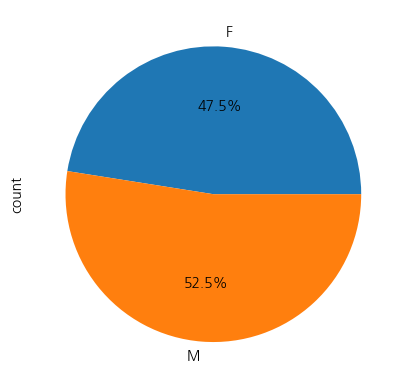

In [138]:
cluster_2_info.groupby(['성별'])['count'].sum().plot.pie(autopct='%1.1f%%')

In [139]:
cluster_total_10_month[cluster_total_10_month['cluster'] == 2].drop(columns='pk').mean().sort_values(ascending=False)[:50]

ce03m(이용금액_항공)          183677.790305
cf05m(이용금액_예식)          161752.083333
cf01m(이용금액_학원학습지)       151138.234126
cg07m(이용금액_스포츠센터)       103009.382122
cf07m(이용금액_보험)           96966.910382
cg02m(이용금액_숙박)           89999.599909
cf03m(이용금액_치과)           86660.173833
cc08m(이용금액_가전)           80800.168750
cg22m(이용금액_해외여행직구)       77328.374314
cg16m(이용금액_레져용품)         74218.381219
cg10m(이용금액_실외골프장)        70688.540358
ce09m(이용금액_안경)           64559.446133
ce06m(이용금액_통신요금)         62287.595594
cc06m(이용금액_의류)           59848.795978
cc01m(이용금액_백화점)          55936.787717
cc05m(이용금액_면세점)          51889.476515
cg04m(이용금액_제주여행)         50514.064380
cc07m(이용금액_화장품)          44123.550047
ce13m(이용금액_주유소)          43729.404516
cf02m(이용금액_병원)           40884.182026
ce11m(이용금액_미용실)          36688.053512
cc04m(이용금액_이커머스)         35753.519892
cf06m(이용금액_장례)           33832.421078
cd01m(이용금액_식당)           32585.703855
ce12m(이용금액_렌터카)          29205.006250
ce04m(이용금액_철도)           27537.306233
cg06m(이용금액_남

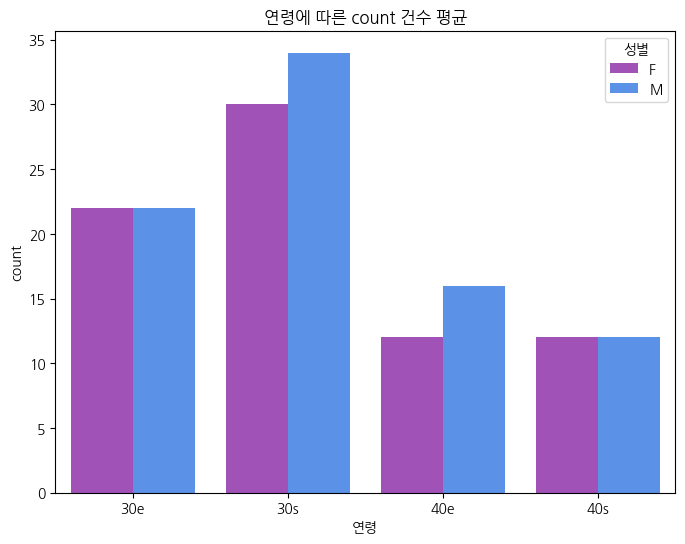

In [140]:
# 남성 30대가 압도적임

plot_column_by_multiple_pk(df=cluster_2_info, pk_name_1='연령', pk_name_2 = '성별', col_name='count')

In [141]:
print()

In [142]:
# 아니 다 여행이랑, 대중교통이 다 높아??
## 교육 : 1.23
cluster_2.drop(columns='pk').mean().sort_values(ascending=False)

대중교통                   6.635759
편의점                    6.240800
여행                     5.620998
의료                     4.732698
이커머스                   4.230574
배달앱                    4.228799
요식                     4.225492
마트                     4.038178
연료                     3.946253
레져/레져용품/               3.049797
커피                     2.600352
숙박                     2.248502
cluster                2.000000
백화점                    1.951971
해외                     1.819524
보험                     1.782999
통신요금                   1.470961
오락실/PC방                1.456147
생활용품                   1.255118
의류                     1.063190
OTT서비스                 0.944324
미용실                    0.901922
전시/관람/체험               0.843822
교육                     0.842638
서점                     0.609872
세탁소                    0.506626
안경                     0.489396
화장품                    0.443271
사진                     0.328390
면세점                    0.282083
lb04r(보험계약고객비율_어린이)    0.096975
가전      

<Axes: >

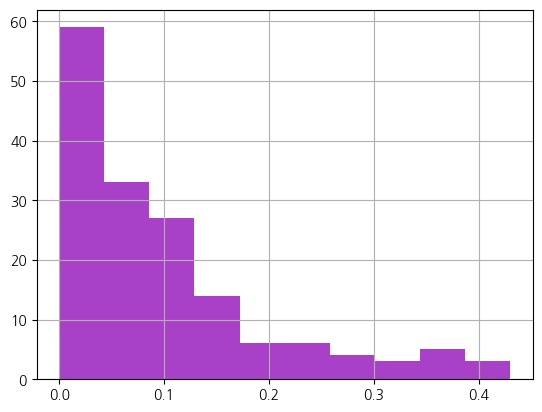

In [203]:
cluster_2['lb04r(보험계약고객비율_어린이)'].hist(color="#a941c8")

#### 3번 군집

In [144]:
cluster_3 = float_data[float_data['cluster'] == 3]
cluster_3.head()

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster,pk
10,2.111667,2.911667,4.350000,3.710000,0.500000,1.233333,0.833333,0.500000,1.461667,3.585000,3.250000,5.838333,7.078333,1.221667,1.055000,0.833333,0.666667,1.000000,1.041667,2.743333,1.666667,5.095000,0.000000,1.653333,2.693333,12.833333,0.333333,1.455000,1.166667,1.000000,1.855000,3.028333,0.080000,3,F-30e-11110640
148,2.131667,4.921667,5.576667,5.943333,0.166667,1.190000,0.916667,0.500000,1.340000,3.943333,3.285000,3.485000,8.000000,1.616667,1.255000,1.083333,0.833333,1.096667,1.071667,3.163333,1.345000,6.185000,0.000000,1.540000,1.776667,10.866667,0.000000,1.336667,2.000000,1.116667,1.928333,3.471667,0.153333,3,F-30e-11320521
266,1.796667,3.665000,6.300000,4.336667,0.333333,1.430000,0.833333,0.333333,1.510000,5.298333,2.808333,4.308333,4.973333,1.303333,1.041667,0.333333,1.000000,0.750000,1.116667,4.261667,1.305000,5.430000,0.166667,1.166667,2.500000,1.916667,0.000000,1.083333,1.416667,1.041667,1.096667,2.471667,0.123333,3,F-30e-11530595
421,2.345000,4.693333,6.746667,4.503333,0.721667,1.898333,0.500000,0.333333,1.648333,4.331667,2.423333,5.071667,8.033333,1.546667,0.833333,0.500000,0.833333,0.166667,1.125000,3.720000,2.083333,4.748333,0.000000,2.223333,1.333333,4.500000,0.000000,1.013333,0.916667,1.000000,1.666667,3.500000,0.135000,3,F-30e-26110510
428,2.515000,3.626667,5.523333,6.458333,0.000000,0.500000,0.500000,0.333333,1.431667,2.985000,2.833333,6.043333,5.928333,1.681667,0.000000,0.000000,0.000000,0.000000,0.666667,3.250000,1.000000,5.530000,0.000000,1.905000,2.666667,1.833333,0.000000,0.666667,0.000000,1.000000,1.333333,0.500000,0.101667,3,F-30e-26140520


In [145]:
cluster_3_info = show_pk_info(float_data, 3)
cluster_3_info

,성별,연령,count
0,M,30s,52
1,F,30s,48
2,M,40s,27
3,M,40e,25
4,F,30e,23
5,M,30e,22
6,F,40s,17
7,F,40e,14


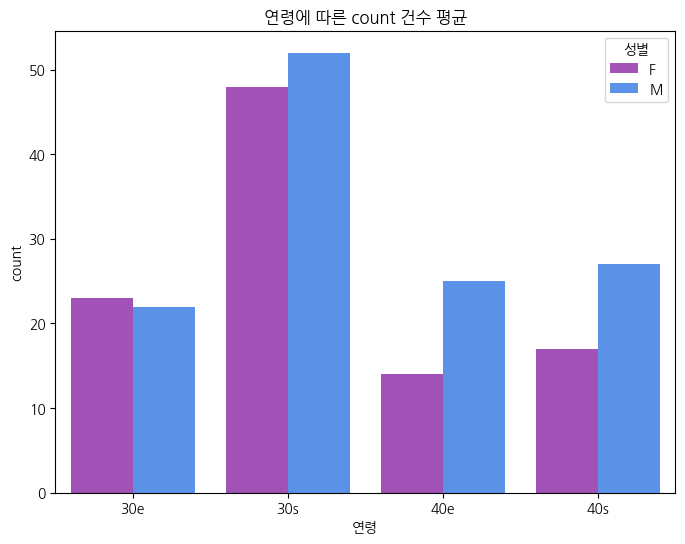

In [146]:
# 남성 40대가 많음

plot_column_by_multiple_pk(df=cluster_3_info, pk_name_1='연령', pk_name_2 = '성별', col_name='count')

In [147]:
cluster_total_10_month[cluster_total_10_month['cluster'] == 3].drop(columns='pk').mean().sort_values(ascending=False)[:50]

cf01m(이용금액_학원학습지)       190109.464099
ce03m(이용금액_항공)          155567.834480
cg07m(이용금액_스포츠센터)       129567.082314
cf05m(이용금액_예식)          125034.994973
cc08m(이용금액_가전)          109159.700106
cf03m(이용금액_치과)          105852.589584
cg02m(이용금액_숙박)           94864.436860
cf07m(이용금액_보험)           91348.724963
cg10m(이용금액_실외골프장)        81433.449757
cg16m(이용금액_레져용품)         78997.437911
cg22m(이용금액_해외여행직구)       77680.645795
ce09m(이용금액_안경)           75495.642290
cc05m(이용금액_면세점)          66531.858045
ce06m(이용금액_통신요금)         62875.853850
cc06m(이용금액_의류)           61534.670531
cc01m(이용금액_백화점)          54075.577172
cg04m(이용금액_제주여행)         53940.861145
ce13m(이용금액_주유소)          44601.658963
cf02m(이용금액_병원)           43382.069748
ce12m(이용금액_렌터카)          43007.035088
cc07m(이용금액_화장품)          39064.590867
cf06m(이용금액_장례)           38005.436560
ce11m(이용금액_미용실)          37016.347019
cc04m(이용금액_이커머스)         35370.686938
cg01m(이용금액_특급호텔)         33288.542318
cd01m(이용금액_식당)           32319.840442
ce04m(이용금액_철

In [148]:
# 아니 다 여행이랑, 대중교통이 다 높아??
## 여긴 연료가 높네 => 아무래도 자동차 끌고 다녀서 그런건가
cluster_3.drop(columns='pk').mean().sort_values(ascending=False)

여행                     8.550606
대중교통                   7.160916
편의점                    6.472941
의료                     4.933711
연료                     4.666572
배달앱                    4.349648
요식                     4.335029
레져/레져용품/               4.304046
이커머스                   4.160253
마트                     4.048086
cluster                3.000000
커피                     2.711143
숙박                     2.526643
백화점                    2.101302
해외                     2.039385
오락실/PC방                2.006639
보험                     1.816170
통신요금                   1.415289
생활용품                   1.359258
의류                     1.177439
교육                     1.151228
전시/관람/체험               1.041185
OTT서비스                 1.029794
미용실                    1.002631
서점                     0.832683
세탁소                    0.749493
안경                     0.663922
화장품                    0.572485
사진                     0.495412
면세점                    0.479521
가전                     0.424503
예식      

<Axes: >

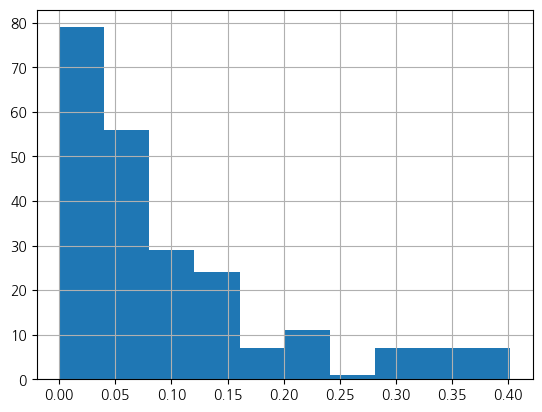

In [149]:
cluster_3['lb04r(보험계약고객비율_어린이)'].hist()

#### 4번 클러스터

In [150]:
cluster_4 = float_data[float_data['cluster'] == 4]
cluster_4.head()

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster,pk
0,2.515000,3.016667,4.975000,5.360000,0.805,1.640000,1.250000,1.0,1.506667,4.190000,2.301667,4.288333,9.513333,1.513333,1.408333,0.500000,1.000000,0.991667,1.073333,2.603333,1.268333,5.545000,0.166667,1.950000,2.276667,15.770000,0.666667,1.203333,1.666667,1.101667,2.810000,3.433333,0.066667,4,F-30e-11110515
1,2.621667,2.970000,5.293333,4.568333,1.390,1.246667,1.125000,1.0,1.346667,4.363333,2.768333,4.265000,9.675000,1.305000,1.468333,1.000000,1.033333,1.210000,1.073333,2.236667,1.585000,5.833333,0.500000,1.276667,3.456667,10.328333,0.666667,1.290000,1.750000,1.091667,2.620000,4.683333,0.081667,4,F-30e-11110530
4,2.565000,3.761667,3.580000,5.308333,1.055,1.301667,1.173333,1.0,1.496667,3.673333,2.943333,3.726667,8.588333,1.285000,1.380000,1.000000,1.000000,1.191667,1.145000,4.281667,1.798333,5.726667,0.000000,1.855000,2.873333,7.475000,0.388333,1.463333,0.666667,1.010000,2.386667,5.646667,0.081667,4,F-30e-11110560
6,3.075000,4.818333,4.256667,5.738333,1.055,1.485000,1.000000,1.0,1.340000,4.331667,2.875000,3.315000,10.441667,1.315000,1.236667,0.611667,1.000000,1.326667,1.050000,3.506667,2.240000,5.525000,0.000000,1.546667,3.203333,12.461667,0.500000,1.186667,0.666667,1.111667,2.771667,7.265000,0.085000,4,F-30e-11110580
8,2.401667,3.270000,4.050000,4.631667,0.750,1.355000,1.000000,1.0,1.611667,4.451667,2.605000,4.060000,9.833333,1.258333,1.498333,0.500000,0.833333,1.000000,1.123333,2.376667,1.471667,5.291667,0.000000,1.516667,2.750000,11.395000,0.333333,1.286667,1.000000,1.188333,2.920000,6.005000,0.088333,4,F-30e-11110615


In [151]:
cluster_4_info = show_pk_info(float_data, 4)
cluster_4_info

,성별,연령,count
0,F,40s,799
1,F,40e,799
2,F,30e,738
3,F,30s,700
4,M,40e,44
5,M,40s,23
6,M,30e,13
7,M,30s,4


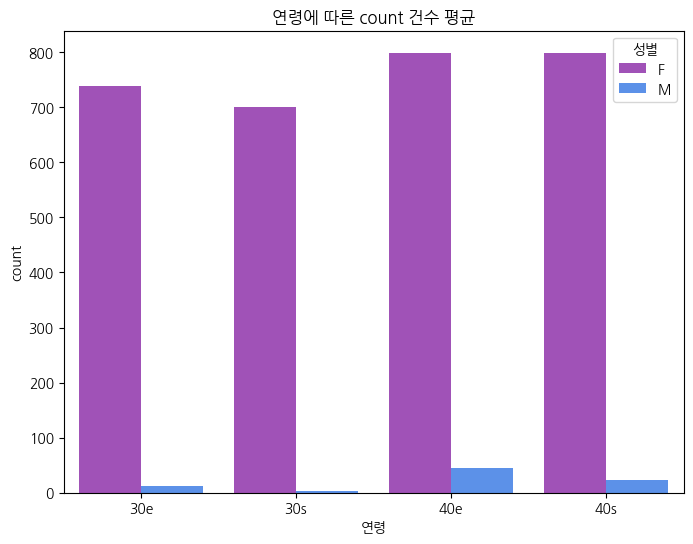

In [152]:
#남녀 섞여있음
plot_column_by_multiple_pk(df=cluster_4_info, pk_name_1='연령', pk_name_2 = '성별', col_name='count')

In [153]:
# 대중교통, 편의점 이용이 높다?!
## 상대적으로 교육에 대한 것이 적네
cluster_4.drop(columns='pk').mean().sort_values(ascending=False)

여행                     12.162371
대중교통                    8.559611
레져/레져용품/                7.503975
의료                      5.558863
연료                      5.167470
이커머스                    4.710011
편의점                     4.709506
마트                      4.245927
배달앱                     4.124592
cluster                 4.000000
요식                      3.796388
커피                      3.119929
숙박                      2.926833
오락실/PC방                 2.494525
백화점                     2.318375
해외                      2.310524
보험                      1.972193
교육                      1.769723
통신요금                    1.441689
생활용품                    1.418781
의류                      1.370949
전시/관람/체험                1.342363
서점                      1.255169
세탁소                     1.156523
OTT서비스                  1.073163
미용실                     1.070645
사진                      1.016846
안경                      1.013345
가전                      1.011500
화장품                     1.007193
면세점       

<Axes: >

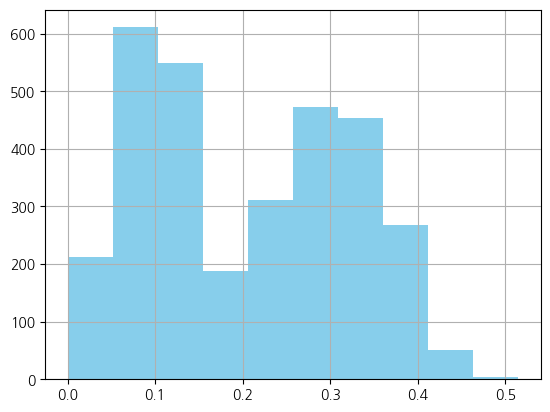

In [162]:
cluster_4['lb04r(보험계약고객비율_어린이)'].hist(color='skyblue')

In [155]:
cluster_total_10_month[cluster_total_10_month['cluster'] == 4].drop(columns='pk').mean().sort_values(ascending=False)[:50]

cf01m(이용금액_학원학습지)       215673.731983
ce03m(이용금액_항공)          211507.493884
cf05m(이용금액_예식)          197344.867446
cg07m(이용금액_스포츠센터)       161743.128713
cg10m(이용금액_실외골프장)       136405.482071
cg02m(이용금액_숙박)          109969.009071
cf03m(이용금액_치과)          106319.420172
cc05m(이용금액_면세점)          94356.719437
cg22m(이용금액_해외여행직구)       86528.928267
ce12m(이용금액_렌터카)          86482.976055
cg16m(이용금액_레져용품)         85252.238561
ce09m(이용금액_안경)           81864.459887
cf07m(이용금액_보험)           78382.178668
cg01m(이용금액_특급호텔)         76702.135289
cg08m(이용금액_수영장)          66806.989686
cc08m(이용금액_가전)           63859.445129
cc06m(이용금액_의류)           60692.516358
ce06m(이용금액_통신요금)         57838.683041
cg12m(이용금액_테니스장)         57236.584206
cc07m(이용금액_화장품)          56858.789616
cg03m(이용금액_여행사)          50944.489464
cc01m(이용금액_백화점)          49595.104468
cf06m(이용금액_장례)           48509.295448
ce11m(이용금액_미용실)          46587.493443
cg04m(이용금액_제주여행)         45442.962651
ce13m(이용금액_주유소)          45307.809490
cf02m(이용금액_병

#### 5번 클러스터

In [156]:
cluster_5 = float_data[float_data['cluster'] == 5]
cluster_5.head()

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster,pk
89,2.243333,3.951667,5.986667,4.678333,0.166667,1.311667,0.666667,1.000000,1.228333,4.181667,2.835000,3.645000,6.751667,1.105000,1.266667,0.333333,1.000000,0.500000,0.833333,2.383333,1.721667,4.995000,0.166667,1.083333,5.833333,6.416667,0.333333,1.731667,0.833333,1.176667,6.328333,3.721667,0.111667,5,F-30e-11230710
283,2.172000,4.472000,5.584000,4.278000,0.200000,1.408000,0.600000,1.000000,1.280000,3.362000,2.624000,3.426000,6.926000,1.362000,1.184000,0.600000,1.000000,1.034000,1.086000,3.506000,1.478000,6.258000,0.000000,1.514000,8.000000,6.014000,0.000000,1.080000,0.500000,1.000000,2.120000,3.616000,0.108000,5,F-30e-11545690
413,2.331667,4.753333,5.428333,4.616667,1.291667,1.676667,1.000000,1.041667,1.416667,4.623333,3.345000,4.688333,9.393333,1.413333,1.293333,0.583333,1.000000,1.181667,1.098333,4.175000,1.536667,5.703333,1.583333,1.470000,3.360000,14.008333,0.166667,1.330000,1.333333,1.131667,1.925000,9.873333,0.118333,5,F-30e-11740600
540,2.312000,5.070000,4.872000,4.314000,1.400000,1.274000,0.400000,1.000000,1.246000,3.470000,3.204000,3.978000,8.228000,1.244000,1.520000,0.600000,1.000000,1.582000,1.040000,4.454000,1.472000,5.994000,0.000000,1.904000,4.020000,13.230000,0.200000,1.100000,1.700000,1.158000,1.740000,4.098000,0.156000,5,F-30e-26380602
663,2.133333,4.453333,4.058333,4.640000,0.833333,1.461667,1.000000,1.016667,1.298333,3.366667,2.528333,3.765000,9.506667,1.480000,1.093333,0.500000,1.021667,1.113333,1.025000,8.258333,1.733333,6.095000,0.000000,1.918333,5.206667,18.645000,0.000000,1.213333,0.583333,1.166667,2.493333,6.203333,0.126667,5,F-30e-27710250


In [157]:
cluster_5_info = show_pk_info(float_data, 5)
cluster_5_info

,성별,연령,count
0,M,40s,760
1,M,30e,739
2,M,40e,709
3,M,30s,659
4,F,30s,13
5,F,30e,10
6,F,40s,7
7,F,40e,6


<Axes: ylabel='count'>

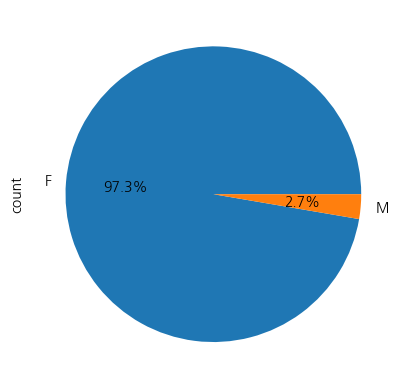

In [205]:
cluster_4_info.groupby(['성별'])['count'].sum().plot.pie(autopct='%1.1f%%')

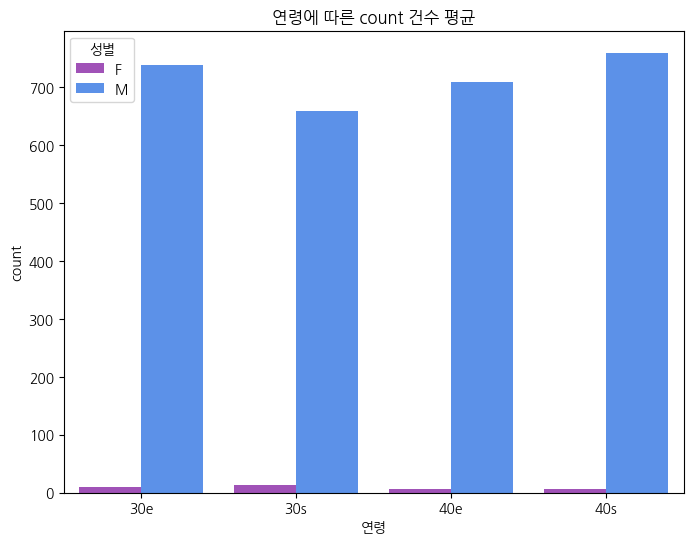

In [159]:
# 40대가 많음 - 남성은 30대 초도 많음

plot_column_by_multiple_pk(df=cluster_5_info, pk_name_1='연령', pk_name_2 = '성별', col_name='count')

<Axes: ylabel='count'>

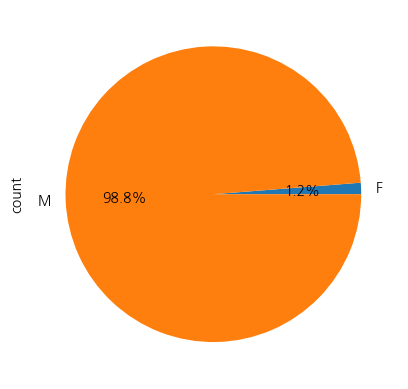

In [204]:
cluster_5_info.groupby(['성별'])['count'].sum().plot.pie(autopct='%1.1f%%')

In [160]:
cluster_total_10_month[cluster_total_10_month['cluster'] == 5].drop(columns='pk').mean().sort_values(ascending=False)[:50]

cf05m(이용금액_예식)          245915.686158
ce03m(이용금액_항공)          216034.172867
cf01m(이용금액_학원학습지)       210589.039693
cg10m(이용금액_실외골프장)       149931.761398
ce12m(이용금액_렌터카)         109368.462860
cf03m(이용금액_치과)          107835.228163
cg07m(이용금액_스포츠센터)       101187.765761
cf07m(이용금액_보험)          100156.164673
cc05m(이용금액_면세점)          93254.123335
cg02m(이용금액_숙박)           92005.964950
ce09m(이용금액_안경)           89876.370071
cg16m(이용금액_레져용품)         78139.737463
cc08m(이용금액_가전)           77504.251116
cg01m(이용금액_특급호텔)         75046.052672
cg22m(이용금액_해외여행직구)       72076.811296
cc06m(이용금액_의류)           61983.113682
ce06m(이용금액_통신요금)         60013.944430
cg08m(이용금액_수영장)          58722.355247
cc07m(이용금액_화장품)          58525.834274
cg15m(이용금액_자전거)          53203.950186
cg12m(이용금액_테니스장)         52342.279328
cc01m(이용금액_백화점)          51828.247069
cg03m(이용금액_여행사)          49126.145217
ce13m(이용금액_주유소)          48782.055417
cf06m(이용금액_장례)           47804.643695
cg04m(이용금액_제주여행)         44434.239154
ce05m(이용금액_여

In [161]:
cluster_info_df = pd.DataFrame()
cluster_info_df


""


In [105]:
c0 = cluster_0.drop(columns='pk').mean().sort_values(ascending=False)
c1 = cluster_1.drop(columns='pk').mean().sort_values(ascending=False)
c2 = cluster_2.drop(columns='pk').mean().sort_values(ascending=False)
c3 = cluster_3.drop(columns='pk').mean().sort_values(ascending=False)
c4 = cluster_4.drop(columns='pk').mean().sort_values(ascending=False)
c5 = cluster_5.drop(columns='pk').mean().sort_values(ascending=False)

cluster_list = [c0, c1, c2, c3, c4, c5]
cluster_list[0]

여행                     9.455677
대중교통                   7.642381
편의점                    6.798491
레져/레져용품/               5.803668
연료                     5.413895
의료                     5.247814
요식                     4.497308
배달앱                    4.328892
마트                     4.176683
이커머스                   4.174390
숙박                     2.884744
커피                     2.880858
오락실/PC방                2.374359
해외                     2.172474
백화점                    2.146539
보험                     1.822863
통신요금                   1.419796
생활용품                   1.362182
교육                     1.292596
의류                     1.217922
전시/관람/체험               1.176755
OTT서비스                 1.081493
미용실                    1.029713
서점                     0.970797
세탁소                    0.899202
안경                     0.760410
가전                     0.755511
화장품                    0.702492
사진                     0.601960
면세점                    0.576404
예식                     0.209925
lb04r(보험

In [164]:
cluster_info_df = pd.DataFrame()

for idx, c in enumerate(cluster_list):
    cluster_info_df[idx] = c

cluster_info_df

,0,1,2,3,4,5
여행,9.455677,7.676355,5.620998,8.550606,12.162371,14.627971
대중교통,7.642381,7.129001,6.635759,7.160916,8.559611,8.555121
편의점,6.798491,5.759568,6.240800,6.472941,4.709506,7.710620
레져/레져용품/,5.803668,5.014703,3.049797,4.304046,7.503975,10.332633
연료,5.413895,5.365098,3.946253,4.666572,5.167470,8.094137
의료,5.247814,5.288379,4.732698,4.933711,5.558863,5.650435
요식,4.497308,4.024807,4.225492,4.335029,3.796388,5.064852
배달앱,4.328892,4.173995,4.228799,4.349648,4.124592,4.196228
마트,4.176683,4.200325,4.038178,4.048086,4.245927,4.488083
이커머스,4.174390,4.380300,4.230574,4.160253,4.710011,4.272228


In [177]:
cluster_info_df.loc['교육', :].to_frame().T


,0,1,2,3,4,5
교육,1.292596,1.375893,0.842638,1.151228,1.769723,1.725387


[]

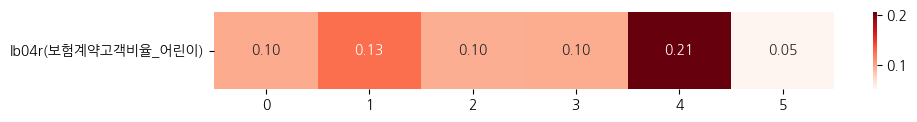

In [198]:
plt.figure(figsize=(10, 1))

#보험
heatmap = sns.heatmap(cluster_info_df.loc['lb04r(보험계약고객비율_어린이)', :].to_frame().T, cmap='Reds', annot=True, fmt=".2f")
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.plot()

In [ ]:
plt.figure(figsize=(10, 1))

#교육
heatmap = sns.heatmap(cluster_info_df.loc['교육', :].to_frame().T, cmap='Reds', annot=True, fmt=".2f")
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.plot()

[]

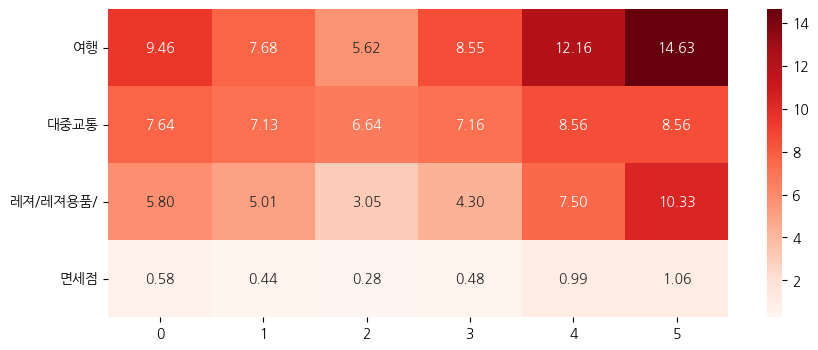

In [192]:
plt.figure(figsize=(10, 4))

#교육
heatmap = sns.heatmap(cluster_info_df.loc[['여행', '대중교통', '레져/레져용품/', '면세점'], :], cmap='Reds', annot=True, fmt=".2f")
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.plot()

[]

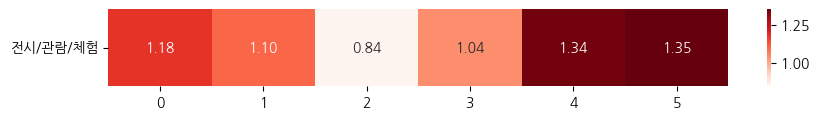

In [197]:
plt.figure(figsize=(10, 1))

#교육
heatmap = sns.heatmap(cluster_info_df.loc['전시/관람/체험', :].to_frame().T, cmap='Reds', annot=True, fmt=".2f")
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
plt.plot()

In [102]:
cluster_5['pk'].apply(lambda x: x[6:8]).value_counts()


pk
11    1514
26     316
41     297
28     288
27     186
30     136
29     125
31      41
Name: count, dtype: int64

In [103]:
cluster_5

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster,pk
89,2.243333,3.951667,5.986667,4.678333,0.166667,1.311667,0.666667,1.000000,1.228333,4.181667,2.835000,3.645000,6.751667,1.105000,1.266667,0.333333,1.000000,0.500000,0.833333,2.383333,1.721667,4.995000,0.166667,1.083333,5.833333,6.416667,0.333333,1.731667,0.833333,1.176667,6.328333,3.721667,0.111667,5,F-30e-11230710
283,2.172000,4.472000,5.584000,4.278000,0.200000,1.408000,0.600000,1.000000,1.280000,3.362000,2.624000,3.426000,6.926000,1.362000,1.184000,0.600000,1.000000,1.034000,1.086000,3.506000,1.478000,6.258000,0.000000,1.514000,8.000000,6.014000,0.000000,1.080000,0.500000,1.000000,2.120000,3.616000,0.108000,5,F-30e-11545690
413,2.331667,4.753333,5.428333,4.616667,1.291667,1.676667,1.000000,1.041667,1.416667,4.623333,3.345000,4.688333,9.393333,1.413333,1.293333,0.583333,1.000000,1.181667,1.098333,4.175000,1.536667,5.703333,1.583333,1.470000,3.360000,14.008333,0.166667,1.330000,1.333333,1.131667,1.925000,9.873333,0.118333,5,F-30e-11740600
540,2.312000,5.070000,4.872000,4.314000,1.400000,1.274000,0.400000,1.000000,1.246000,3.470000,3.204000,3.978000,8.228000,1.244000,1.520000,0.600000,1.000000,1.582000,1.040000,4.454000,1.472000,5.994000,0.000000,1.904000,4.020000,13.230000,0.200000,1.100000,1.700000,1.158000,1.740000,4.098000,0.156000,5,F-30e-26380602
663,2.133333,4.453333,4.058333,4.640000,0.833333,1.461667,1.000000,1.016667,1.298333,3.366667,2.528333,3.765000,9.506667,1.480000,1.093333,0.500000,1.021667,1.113333,1.025000,8.258333,1.733333,6.095000,0.000000,1.918333,5.206667,18.645000,0.000000,1.213333,0.583333,1.166667,2.493333,6.203333,0.126667,5,F-30e-27710250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2.416000,4.104000,8.050000,3.304000,1.550000,1.300000,0.800000,1.030000,1.296000,4.696000,3.102000,3.450000,6.954000,1.656000,1.318000,1.300000,1.000000,1.200000,1.038000,9.698000,1.952000,5.702000,1.700000,2.194000,4.052000,16.118000,0.200000,1.394000,2.584000,1.096000,2.450000,12.970000,0.036000,5,M-40s-41500253
7540,1.937500,4.825000,7.080000,4.942500,1.272500,1.250000,1.000000,1.030000,1.195000,4.557500,3.337500,3.297500,9.000000,1.667500,1.275000,1.255000,1.015000,1.117500,1.060000,8.075000,1.980000,6.057500,1.000000,1.880000,3.700000,14.335000,0.500000,1.340000,3.580000,1.085000,2.590000,13.617500,0.092500,5,M-40s-41570550
7541,2.425000,5.116667,7.476667,3.713333,1.491667,1.368333,1.033333,1.008333,1.308333,4.608333,3.015000,4.046667,8.253333,1.701667,1.263333,1.123333,1.066667,1.131667,1.061667,9.323333,1.816667,6.056667,0.555000,2.008333,3.070000,15.755000,0.666667,1.398333,3.513333,1.150000,2.498333,13.305000,0.050000,5,M-40s-41590259
7542,2.421667,4.485000,6.695000,5.140000,1.406667,1.451667,1.041667,1.010000,1.373333,4.596667,3.148333,3.293333,7.766667,1.651667,1.321667,1.223333,1.000000,1.168333,1.058333,9.288333,1.990000,5.928333,1.250000,1.950000,3.283333,16.243333,0.500000,1.401667,3.173333,1.115000,2.635000,13.938333,0.045000,5,M-40s-41590600


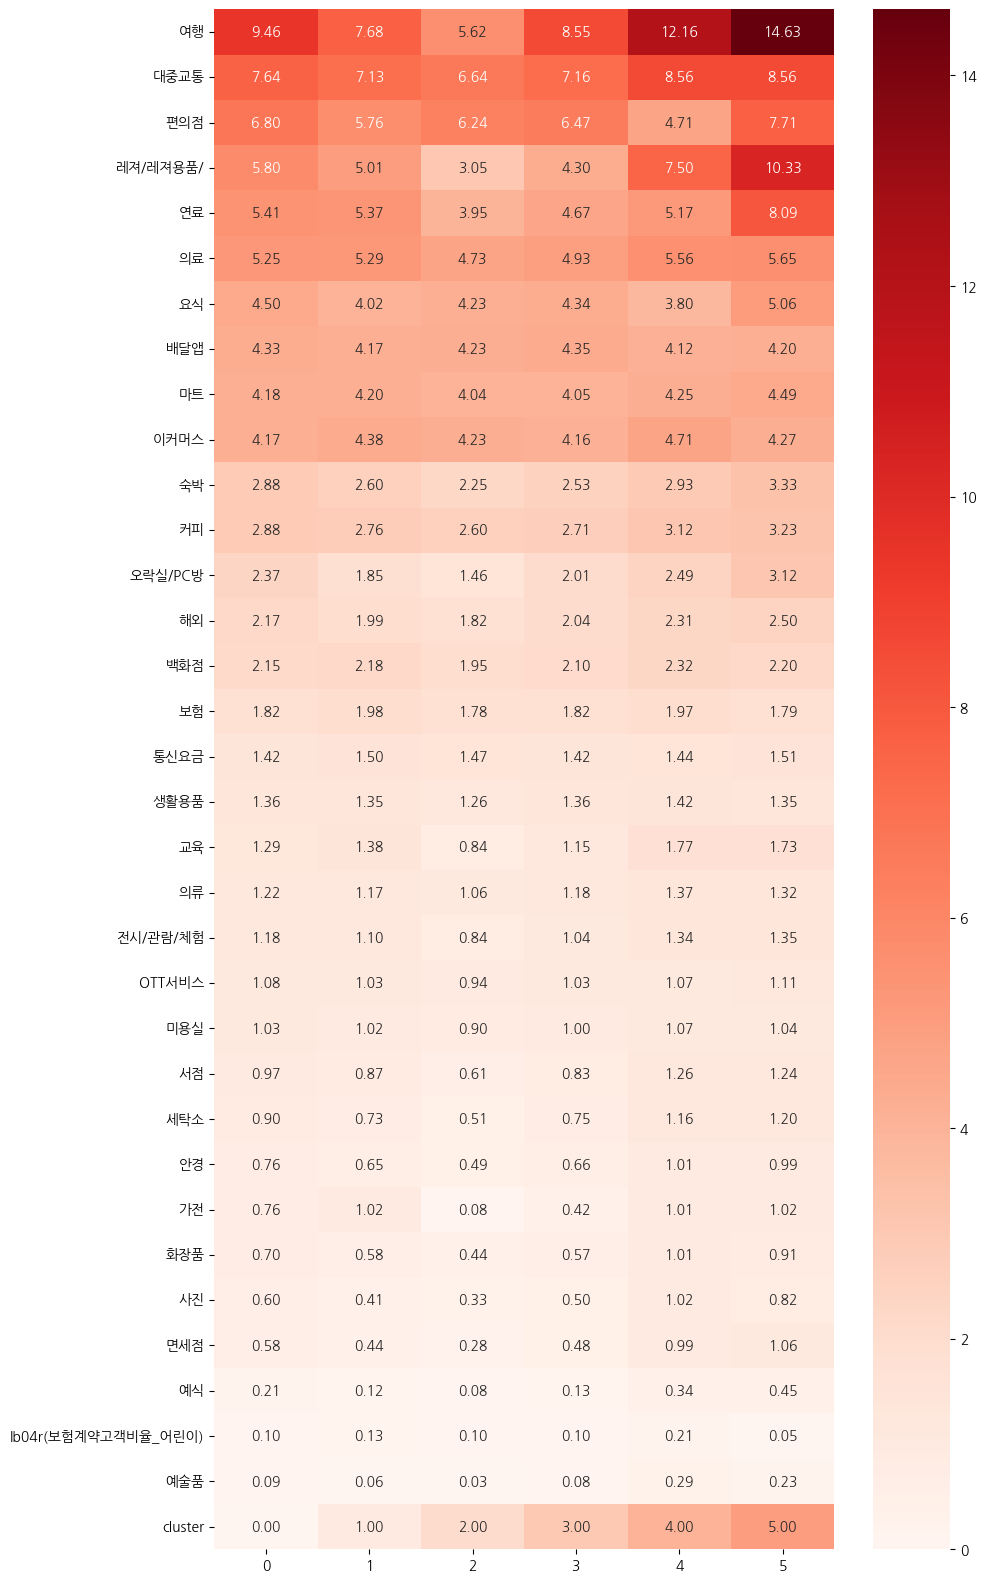

In [104]:
plt.figure(figsize=(10, 20))

sns.heatmap(cluster_info_df, cmap='Reds', annot=True, fmt=".2f")
plt.savefig('heatmap_image.png')

In [94]:
# 아니 다 여행이랑, 대중교통이 다 높아??
## 교육이 2나 된다
## 기부금도 다른 곳보다 높네
## 40대분들이 가장 소비건수가 크신듯
cluster_5.drop(columns='pk').mean().sort_values(ascending=False)

여행                     14.627971
레져/레져용품/               10.332633
대중교통                    8.555121
연료                      8.094137
편의점                     7.710620
의료                      5.650435
요식                      5.064852
cluster                 5.000000
마트                      4.488083
이커머스                    4.272228
배달앱                     4.196228
숙박                      3.334426
커피                      3.230083
오락실/PC방                 3.123910
해외                      2.501580
백화점                     2.197064
보험                      1.785286
교육                      1.725387
통신요금                    1.512236
생활용품                    1.354097
전시/관람/체험                1.352346
의류                      1.317425
서점                      1.242129
세탁소                     1.195085
OTT서비스                  1.113938
면세점                     1.056862
미용실                     1.044759
가전                      1.019070
안경                      0.993306
화장품                     0.907732
사진        

In [141]:
cluster_0

,pk2(성별),pk3(연령대),pk4(지역),백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster,pk2(성별),pk3(연령대),pk4(지역),cc01m(이용금액_백화점),cc02m(이용금액_마트),cc03m(이용금액_편의점),cc04m(이용금액_이커머스),cc05m(이용금액_면세점),cc06m(이용금액_의류),cc07m(이용금액_화장품),cc08m(이용금액_가전),cc09m(이용금액_생활용품),cc10o(이용금액_신차),cc11o(이용금액_중고차),cc12o(이용금액_수입차),cc13o(이용금액_오토바이),cd01m(이용금액_식당),cd02m(이용금액_대형고가커피),cd03m(이용금액_소형저가커피),cd04m(이용금액_배달앱),ce01m(이용금액_고속버스),ce02m(이용금액_택시),ce03m(이용금액_항공),ce04m(이용금액_철도),ce05m(이용금액_여객선),ce06m(이용금액_통신요금),ce07m(이용금액_서점),ce08m(이용금액_네컷사진),ce09m(이용금액_안경),ce10m(이용금액_세탁소),ce11m(이용금액_미용실),ce12m(이용금액_렌터카),ce13m(이용금액_주유소),ce14m(이용금액_LPG가스),ce15m(이용금액_전기차충전),cf01m(이용금액_학원학습지),cf02m(이용금액_병원),cf03m(이용금액_치과),cf04m(이용금액_약국),cf05m(이용금액_예식),cf06m(이용금액_장례),cf07m(이용금액_보험),cf08m(이용금액_기부금),cg01m(이용금액_특급호텔),cg02m(이용금액_숙박),cg03m(이용금액_여행사),cg04m(이용금액_제주여행),cg05m(이용금액_동해여행),cg06m(이용금액_남해여행),cg07m(이용금액_스포츠센터),cg08m(이용금액_수영장),cg09m(이용금액_당구장),cg10m(이용금액_실외골프장),cg11m(이용금액_실내골프장),cg12m(이용금액_테니스장),cg13m(이용금액_볼링장),cg14m(이용금액_놀이동산),cg15m(이용금액_자전거),cg16m(이용금액_레져용품),cg17m(이용금액_예술품),cg18m(이용금액_화원),cg19m(이용금액_전시/관람/체험),cg20m(이용금액_오락실/PC방),cg21m(이용금액_OTT서비스),cg22m(이용금액_해외여행직구),pk5,pk
13,F,30e,11110680,2.295000,4.603333,5.320000,5.745000,0.000000,1.000000,0.500000,0.833333,1.611667,3.491667,3.418333,3.256667,6.361667,1.380000,0.666667,0.333333,0.500000,0.166667,1.166667,1.421667,0.833333,5.145000,0.000000,2.075000,1.000000,7.166667,0.166667,0.833333,0.666667,1.000000,2.110000,1.833333,0.090000,0,F,30e,11110680.0,68138.391029,19965.853026,7172.859472,35004.611929,0.000000,42800.000000,0.000000,78800.0,19216.234198,0.0,0.0,0.0,0.0,27762.838977,15090.336620,4073.251748,27427.218930,13333.333333,11226.029360,138000.000000,30750.000000,0.000000,71701.840764,10833.333333,5000.000000,40000.0,11000.000000,54416.666667,81000.0,54225.867700,0.000000,0.000000,172750.000000,46944.169210,105309.022556,16268.619115,0.0,55000.000000,77920.558947,0.0,0.000000,42000.000000,0.0,101896.940419,16714.285714,23333.333333,498000.000000,0.0,0.0,0.000000,0.000000,0.0,27000.0,0.000000,0.0,78166.666667,25000.0,12500.000000,9750.000000,2500.000000,11000.000000,163933.583960,F-30e-11110680,F-30e-11110680
34,F,30e,11170530,3.235000,3.736667,5.483333,5.303333,0.833333,1.526667,0.583333,0.666667,1.613333,4.210000,3.238333,3.085000,8.836667,1.516667,1.166667,0.166667,0.833333,0.833333,1.056667,2.071667,1.311667,5.296667,0.000000,1.605000,2.026667,5.736667,0.000000,0.833333,0.166667,1.000000,1.591667,4.083333,0.091667,0,F,30e,11170530.0,36424.560055,15524.102903,7646.765457,31425.695315,66333.333333,55128.080618,60777.777778,36750.0,20884.467384,0.0,0.0,0.0,0.0,28075.383470,13869.211350,4535.070031,21143.802935,14586.466165,10032.021729,164300.000000,25799.719813,0.000000,47494.238917,34666.666667,5000.000000,99200.0,23083.333333,67540.935673,0.0,52375.227553,0.000000,0.000000,224900.532269,37961.424708,51753.968254,8725.427603,0.0,40500.000000,35256.706151,0.0,21200.000000,85958.997494,10000.0,33333.333333,35665.704666,5000.000000,115625.000000,0.0,0.0,177666.666667,0.000000,0.0,0.0,23500.000000,24000.0,96200.000000,0.0,19333.333333,14200.000000,1000.000000,11833.333333,79150.933266,F-30e-11170530,F-30e-11170530
51,F,30e,11200550,1.830000,4.188333,5.098333,5.390000,0.500000,1.155000,1.000000,0.666667,1.326667,4.253333,3.171667,3.878333,8.058333,1.396667,1.388333,0.166667,0.333333,1.278333,1.076667,2.833333,1.500000,5.676667,0.166667,1.313333,2.640000,5.875000,0.000000,1.366667,0.611667,1.378333,1.978333,3.083333,0.128333,0,F,30e,11200550.0,57348.642413,18463.483885,7573.971869,31237.557013,94000.000000,61403.874923,60500.000000,429000.0,25507.583671,0.0,0.0,0.0,0.0,30874.593557,17462.447784,6079.761905,26600.305989,13966.666667,10926.291290,19000.000000,27506.945209,20000.000000,58363.564093,10462.406015,25000.000000,27500.0,25807.884232,45950.695322,0.0,41277.036046,30000.000000,0.000000,80861.111111,58129.896039,111472.222

In [95]:
cluster_columns = float_data.columns
cluster_columns

Index(['백화점', '마트', '편의점', '이커머스', '면세점', '의류', '화장품', '가전', '생활용품', '요식',
       '커피', '배달앱', '대중교통', '통신요금', '서점', '사진', '안경', '세탁소', '미용실', '연료', '교육',
       '의료', '예식', '보험', '숙박', '여행', '예술품', '전시/관람/체험', '오락실/PC방', 'OTT서비스',
       '해외', '레져/레져용품/', 'lb04r(보험계약고객비율_어린이)', 'cluster', 'pk'],
      dtype='object')

<Axes: >

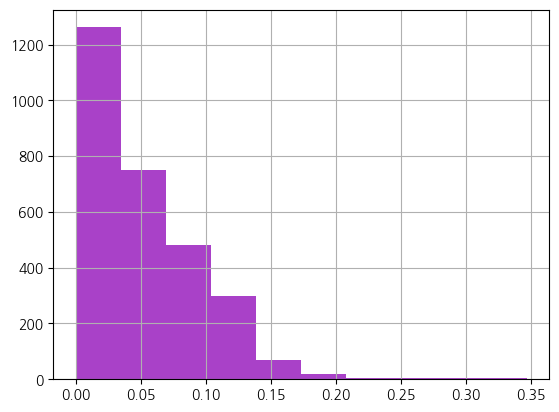

In [202]:
cluster_5['lb04r(보험계약고객비율_어린이)'].hist(color='#a941c8')

In [97]:
# 데이터 제공
float_data.to_csv('231007_cluster_middle+life_raw.csv', index=False)

In [115]:
cluster_

,백화점,마트,편의점,이커머스,면세점,의류,화장품,가전,생활용품,요식,커피,배달앱,대중교통,통신요금,서점,사진,안경,세탁소,미용실,연료,교육,의료,예식,보험,숙박,여행,예술품,전시/관람/체험,오락실/PC방,OTT서비스,해외,레져/레져용품/,lb04r(보험계약고객비율_어린이),cluster,pk,pk2(성별),pk3(연령대),pk4(지역),cc01m(이용금액_백화점),cc02m(이용금액_마트),cc03m(이용금액_편의점),cc04m(이용금액_이커머스),cc05m(이용금액_면세점),cc06m(이용금액_의류),cc07m(이용금액_화장품),cc08m(이용금액_가전),cc09m(이용금액_생활용품),cc10o(이용금액_신차),cc11o(이용금액_중고차),cc12o(이용금액_수입차),cc13o(이용금액_오토바이),cd01m(이용금액_식당),cd02m(이용금액_대형고가커피),cd03m(이용금액_소형저가커피),cd04m(이용금액_배달앱),ce01m(이용금액_고속버스),ce02m(이용금액_택시),ce03m(이용금액_항공),ce04m(이용금액_철도),ce05m(이용금액_여객선),ce06m(이용금액_통신요금),ce07m(이용금액_서점),ce08m(이용금액_네컷사진),ce09m(이용금액_안경),ce10m(이용금액_세탁소),ce11m(이용금액_미용실),ce12m(이용금액_렌터카),ce13m(이용금액_주유소),ce14m(이용금액_LPG가스),ce15m(이용금액_전기차충전),cf01m(이용금액_학원학습지),cf02m(이용금액_병원),cf03m(이용금액_치과),cf04m(이용금액_약국),cf05m(이용금액_예식),cf06m(이용금액_장례),cf07m(이용금액_보험),cf08m(이용금액_기부금),cg01m(이용금액_특급호텔),cg02m(이용금액_숙박),cg03m(이용금액_여행사),cg04m(이용금액_제주여행),cg05m(이용금액_동해여행),cg06m(이용금액_남해여행),cg07m(이용금액_스포츠센터),cg08m(이용금액_수영장),cg09m(이용금액_당구장),cg10m(이용금액_실외골프장),cg11m(이용금액_실내골프장),cg12m(이용금액_테니스장),cg13m(이용금액_볼링장),cg14m(이용금액_놀이동산),cg15m(이용금액_자전거),cg16m(이용금액_레져용품),cg17m(이용금액_예술품),cg18m(이용금액_화원),cg19m(이용금액_전시/관람/체험),cg20m(이용금액_오락실/PC방),cg21m(이용금액_OTT서비스),cg22m(이용금액_해외여행직구)
0,2.515000,3.016667,4.975000,5.360000,0.805000,1.640000,1.250000,1.000000,1.506667,4.190000,2.301667,4.288333,9.513333,1.513333,1.408333,0.500000,1.000000,0.991667,1.073333,2.603333,1.268333,5.545000,0.166667,1.950000,2.276667,15.770000,0.666667,1.203333,1.666667,1.101667,2.810000,3.433333,0.066667,4,F-30e-11110515,F,30e,11110515.0,42743.540662,23519.174579,6747.177065,31189.759542,83575.187970,65078.808006,91820.000000,77500.000000,26375.440195,0.000000,0.0,0.00,0.000000,28473.273223,17078.491721,4880.000000,24546.958713,12000.000000,9379.959233,327111.428571,41879.194895,5000.000000,61270.854336,22935.359717,5666.666667,125000.000000,0.000000,54201.372701,59000.0,49596.064594,46600.000000,0.000000,169070.165167,45338.303905,143251.378446,13930.310066,3.000000e+03,40300.000000,64043.374991,0.0,0.000000,126913.533835,40000.000000,64915.614705,27212.157982,231000.000000,107508.333333,0.000000,0.000000,252666.666667,0.000000,0.000000,113000.000000,31500.000000,0.000000,108600.000000,55750.000000,43129.239766,12077.022461,3000.000000,13461.852806,91216.089071
1,2.621667,2.970000,5.293333,4.568333,1.390000,1.246667,1.125000,1.000000,1.346667,4.363333,2.768333,4.265000,9.675000,1.305000,1.468333,1.000000,1.033333,1.210000,1.073333,2.236667,1.585000,5.833333,0.500000,1.276667,3.456667,10.328333,0.666667,1.290000,1.750000,1.091667,2.620000,4.683333,0.081667,4,F-30e-11110530,F,30e,11110530.0,52309.431599,18723.688479,6639.289714,35489.337206,99061.377246,66462.287546,49622.222222,55000.000000,17900.964001,0.000000,0.0,0.00,0.000000,29615.823554,16317.089912,4204.366484,25059.418327,8066.666667,9598.405069,303780.952381,44230.824028,36000.000000,56247.035992,26932.435612,5200.000000,100694.444444,22445.590472,58603.296726,67000.0,58253.901169,2000.000000,0.000000,194649.964446,55989.049685,132276.274519,12946.223031,1.752250e+06,52913.951546,80692.160793,0.0,105269.806734,192739.028849,28000.000000,23075.000000,75309.098543,68693.939394,126044.598961,16000.000000,0.000000,102000.000000,38666.666667,0.000000,49000.000000,9321.428571,0.000000,105000.000000,9750.000000,45500.000000,13377.341670,1423.076923,11918.306006,89801.312528
2,2.680000,3.275000,8.873333,2.956667,0.000000,1.666667,0.500000,0.000000,1.138333,4.498333,4.665000,4.273333,9.465000,1.415000,1.166667,0.333333,0.500000,0.333333,0.833333,2.570000,1.166667,5.393333,0.000000,1.170000,2.333333,6.750000,0.000000,0.750000,0.500000,1.000000,3.108333,2.583333,0.118333,2,F-30e-11110540,F,30e,11110540.0,42934.780187,30107.438611,6918.378979,40135.679661,0.000000,52000.000000,31250.000000,0.000000,17454.469507,0.000000,0.0,0.00,0.000000,28228.573759,10946.532999,3738.095238,28841.344587,15000.000000,11590.967542,234333.333333,25687.267267,0.000000,45264.901765,20466.666667,5000.000000,38333.333333,

In [ ]:
float_data

In [ ]:
per_amt_df = card_life_data[primary_col]

for amt_col,num_col in zip(card_selected_col_2, card_selected_col):
    amt = card_life_data[amt_col]
    num = card_life_data[num_col]

    # 건당 이용금액 series
    per_amt = amt/num

    # 새로운 col name(우선 뒤의 개별 합치고 => 중분류 작업을 원활하기 위해 금액 col그대로 사용)
    # col_name = f'건당{amt_col[6:-1]}'
    per_amt_df[amt_col] = per_amt

per_amt_df

In [ ]:
per_amt_df = card_life_data[primary_col]

for amt_col,num_col in zip(card_selected_col_2, card_selected_col):
    amt = card_life_data[amt_col]
    num = card_life_data[num_col]

    # 건당 이용금액 series
    per_amt = amt/num

    # 새로운 col name(우선 뒤의 개별 합치고 => 중분류 작업을 원활하기 위해 금액 col그대로 사용)
    # col_name = f'건당{amt_col[6:-1]}'
    per_amt_df[amt_col] = per_amt

per_amt_df